In [1]:
import collections
import itertools
import logging
import random
import sys
from collections import deque

from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import gym
import pfrl

import torch
from tqdm import tqdm

from torch import nn
from gym.wrappers import RescaleAction

from util.ppo import PPO_KL
from util.modules import  ortho_init, BetaPolicyModel
from conditioned_trp_env.envs.conditioned_trp_env import FoodClass

sns.set()
sns.set_context("talk")

logging.basicConfig(level=logging.INFO, stream=sys.stdout)
logger = logging.getLogger(__name__)


TIME_STEPS = 300
NUM_TICK = 11
NUM_SAMPLE = 100

RADIUS = 5
NUM_FOOD = 6

red_ticks = np.linspace(-0.5, 0.5, NUM_TICK)
blue_ticks = np.linspace(-0.5, 0.5, NUM_TICK)

#red_ticks = np.linspace(-1.0, 1.0, NUM_TICK)
#blue_ticks = np.linspace(-1.0, 1.0, NUM_TICK)

# red_ticks = np.linspace(-0.1, 0.1, NUM_TICK)
# blue_ticks = np.linspace(-0.1, 0.1, NUM_TICK)

##########################################################
# Seed
##########################################################

seed = 100

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)

env = gym.make(
    "conditioned_trp_env:SmallLowGearAntCTRP-v0",
    max_episode_steps=np.inf,
    internal_reset="setpoint",
    n_bins=20,
    sensor_range=16,
)
env = RescaleAction(env, 0, 1)
env = pfrl.wrappers.CastObservationToFloat32(env)

obs_space = env.observation_space
action_space = env.action_space

obs_size = obs_space.low.size
action_size = action_space.low.size

policy = BetaPolicyModel(obs_size=obs_size,
                         action_size=action_size,
                         hidden1=256,
                         hidden2=64)

value_func = torch.nn.Sequential(
    nn.Linear(obs_size, 256),
    nn.Tanh(),
    nn.Linear(256, 64),
    nn.Tanh(),
    nn.Linear(64, 1),
)

model = pfrl.nn.Branched(policy, value_func)

opt = torch.optim.Adam(model.parameters())

agent = PPO_KL(
    model=model,
    optimizer=opt,
    gpu=-1,
)


/opt/homebrew/Caskroom/miniforge/base/envs/ppo_pfrl/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [3]:
# agent.load(dirname="data/trp-homeostatic_shaped2021-08-17-19-14-42/150000000_finish")

# new paramas
param_dirs = [
    "data/result_trp_therm_oct2021/trp-homeostatic_shaped2021-09-30-14-54-11/150000000_finish",
    "data/result_trp_therm_oct2021/trp-homeostatic_shaped2021-09-30-14-40-15/150000000_finish",
    "data/result_trp_therm_oct2021/trp-homeostatic_shaped2021-09-28-17-38-42/150000000_finish",
    "data/result_trp_therm_oct2021/trp-homeostatic_shaped2021-09-28-17-26-31/150000000_finish",
    "data/result_trp_therm_oct2021/trp-homeostatic_shaped2021-10-02-12-18-57/150000000_finish",
    "data/result_trp_therm_oct2021/trp-homeostatic_shaped2021-10-02-12-41-02/150000000_finish"
]

#agent.load(dirname="data/result_trp_therm_oct2021/trp-homeostatic_shaped2021-09-30-14-54-11/150000000_finish")
# agent.load(dirname="data/result_trp_therm_oct2021/trp-homeostatic_shaped2021-09-30-14-40-15/150000000_finish")
# agent.load(dirname="data/result_trp_therm_oct2021/trp-homeostatic_shaped2021-09-28-17-38-42/150000000_finish")
# agent.load(dirname="data/result_trp_therm_oct2021/trp-homeostatic_shaped2021-09-28-17-26-31/150000000_finish")
#agent.load(dirname="data/result_trp_therm_oct2021/trp-homeostatic_shaped2021-10-02-12-18-57/150000000_finish")
#agent.load(dirname="data/result_trp_therm_oct2021/trp-homeostatic_shaped2021-10-02-12-41-02/150000000_finish")


for id_, d in enumerate(param_dirs):
    
    agent.load(d)
    
    data_red_matrix = np.zeros(shape=(NUM_TICK, NUM_TICK))
    data_blue_matrix = np.zeros(shape=(NUM_TICK, NUM_TICK))
    
    print(f"START NEW PARAM: {d}")

    for i, blue in enumerate(blue_ticks):
        for j, red in enumerate(red_ticks):

            obs = None

            for n in range(NUM_SAMPLE):
                obs = env.reset(initial_internal=(blue, red),
                                object_positions={"blue": [(RADIUS*np.cos(a), RADIUS*np.sin(a)) for a in np.random.uniform(-np.pi, np.pi, NUM_FOOD)],
                                                  "red": [(RADIUS*np.cos(a), RADIUS*np.sin(a)) for a in np.random.uniform(-np.pi, np.pi, NUM_FOOD)]})

                for _ in range(TIME_STEPS):

                    action = agent.act(obs)
                    obs, reward, done, info = env.step(action)
                    #env.render()

                    if done:
                        if info.get("food_type") == FoodClass.RED:
                            data_red_matrix[i, j] += 1
                        elif info.get("food_type") == FoodClass.BLUE:
                            data_blue_matrix[i, j] += 1
                        break

            print(f"{id_}/{len(param_dirs)} - internal @ {i*NUM_TICK + (j + 1)}/{NUM_TICK**2}: (blue, red) = ({blue}, {red}) [RESULT: blue/red: {data_blue_matrix[i, j]}/{data_red_matrix[i, j]}] ")


    data_red_matrix /= NUM_SAMPLE
    data_blue_matrix /= NUM_SAMPLE

    print(data_red_matrix)
    print(data_blue_matrix)

    # SAVE RESULTS
    np.save(f"data_matrices_blue_{id_}_full.npy", data_blue_matrix)
    np.save(f"data_matrices_red_{id_}_full.npy", data_red_matrix)

START NEW PARAM: data/result_trp_therm_oct2021/trp-homeostatic_shaped2021-09-30-14-54-11/150000000_finish
0/6 - internal @ 1/121: (blue, red) = (-1.0, -1.0) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 2/121: (blue, red) = (-1.0, -0.8) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 3/121: (blue, red) = (-1.0, -0.6) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 4/121: (blue, red) = (-1.0, -0.3999999999999999) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 5/121: (blue, red) = (-1.0, -0.19999999999999996) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 6/121: (blue, red) = (-1.0, 0.0) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 7/121: (blue, red) = (-1.0, 0.20000000000000018) [RESULT: blue/red: 2.0/1.0] 
0/6 - internal @ 8/121: (blue, red) = (-1.0, 0.40000000000000013) [RESULT: blue/red: 8.0/1.0] 
0/6 - internal @ 9/121: (blue, red) = (-1.0, 0.6000000000000001) [RESULT: blue/red: 1.0/0.0] 
0/6 - internal @ 10/121: (blue, red) = (-1.0, 0.8) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 11/

0/6 - internal @ 87/121: (blue, red) = (0.40000000000000013, 0.8) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 88/121: (blue, red) = (0.40000000000000013, 1.0) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 89/121: (blue, red) = (0.6000000000000001, -1.0) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 90/121: (blue, red) = (0.6000000000000001, -0.8) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 91/121: (blue, red) = (0.6000000000000001, -0.6) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 92/121: (blue, red) = (0.6000000000000001, -0.3999999999999999) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 93/121: (blue, red) = (0.6000000000000001, -0.19999999999999996) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 94/121: (blue, red) = (0.6000000000000001, 0.0) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 95/121: (blue, red) = (0.6000000000000001, 0.20000000000000018) [RESULT: blue/red: 0.0/0.0] 
0/6 - internal @ 96/121: (blue, red) = (0.6000000000000001, 0.40000000000000013) [RESULT: blue/red: 

1/6 - internal @ 41/121: (blue, red) = (-0.3999999999999999, 0.40000000000000013) [RESULT: blue/red: 0.0/0.0] 
1/6 - internal @ 42/121: (blue, red) = (-0.3999999999999999, 0.6000000000000001) [RESULT: blue/red: 0.0/0.0] 
1/6 - internal @ 43/121: (blue, red) = (-0.3999999999999999, 0.8) [RESULT: blue/red: 0.0/0.0] 
1/6 - internal @ 44/121: (blue, red) = (-0.3999999999999999, 1.0) [RESULT: blue/red: 0.0/0.0] 
1/6 - internal @ 45/121: (blue, red) = (-0.19999999999999996, -1.0) [RESULT: blue/red: 0.0/0.0] 
1/6 - internal @ 46/121: (blue, red) = (-0.19999999999999996, -0.8) [RESULT: blue/red: 0.0/0.0] 
1/6 - internal @ 47/121: (blue, red) = (-0.19999999999999996, -0.6) [RESULT: blue/red: 1.0/0.0] 
1/6 - internal @ 48/121: (blue, red) = (-0.19999999999999996, -0.3999999999999999) [RESULT: blue/red: 21.0/11.0] 
1/6 - internal @ 49/121: (blue, red) = (-0.19999999999999996, -0.19999999999999996) [RESULT: blue/red: 58.0/28.0] 
1/6 - internal @ 50/121: (blue, red) = (-0.19999999999999996, 0.0) [R

2/6 - internal @ 1/121: (blue, red) = (-1.0, -1.0) [RESULT: blue/red: 0.0/0.0] 
2/6 - internal @ 2/121: (blue, red) = (-1.0, -0.8) [RESULT: blue/red: 0.0/0.0] 
2/6 - internal @ 3/121: (blue, red) = (-1.0, -0.6) [RESULT: blue/red: 0.0/0.0] 
2/6 - internal @ 4/121: (blue, red) = (-1.0, -0.3999999999999999) [RESULT: blue/red: 0.0/0.0] 
2/6 - internal @ 5/121: (blue, red) = (-1.0, -0.19999999999999996) [RESULT: blue/red: 3.0/3.0] 
2/6 - internal @ 6/121: (blue, red) = (-1.0, 0.0) [RESULT: blue/red: 6.0/15.0] 
2/6 - internal @ 7/121: (blue, red) = (-1.0, 0.20000000000000018) [RESULT: blue/red: 15.0/17.0] 
2/6 - internal @ 8/121: (blue, red) = (-1.0, 0.40000000000000013) [RESULT: blue/red: 3.0/8.0] 
2/6 - internal @ 9/121: (blue, red) = (-1.0, 0.6000000000000001) [RESULT: blue/red: 3.0/1.0] 
2/6 - internal @ 10/121: (blue, red) = (-1.0, 0.8) [RESULT: blue/red: 0.0/0.0] 
2/6 - internal @ 11/121: (blue, red) = (-1.0, 1.0) [RESULT: blue/red: 0.0/0.0] 
2/6 - internal @ 12/121: (blue, red) = (-0.

2/6 - internal @ 87/121: (blue, red) = (0.40000000000000013, 0.8) [RESULT: blue/red: 0.0/0.0] 
2/6 - internal @ 88/121: (blue, red) = (0.40000000000000013, 1.0) [RESULT: blue/red: 0.0/0.0] 
2/6 - internal @ 89/121: (blue, red) = (0.6000000000000001, -1.0) [RESULT: blue/red: 6.0/8.0] 
2/6 - internal @ 90/121: (blue, red) = (0.6000000000000001, -0.8) [RESULT: blue/red: 10.0/40.0] 
2/6 - internal @ 91/121: (blue, red) = (0.6000000000000001, -0.6) [RESULT: blue/red: 8.0/49.0] 
2/6 - internal @ 92/121: (blue, red) = (0.6000000000000001, -0.3999999999999999) [RESULT: blue/red: 0.0/23.0] 
2/6 - internal @ 93/121: (blue, red) = (0.6000000000000001, -0.19999999999999996) [RESULT: blue/red: 0.0/0.0] 
2/6 - internal @ 94/121: (blue, red) = (0.6000000000000001, 0.0) [RESULT: blue/red: 0.0/0.0] 
2/6 - internal @ 95/121: (blue, red) = (0.6000000000000001, 0.20000000000000018) [RESULT: blue/red: 0.0/0.0] 
2/6 - internal @ 96/121: (blue, red) = (0.6000000000000001, 0.40000000000000013) [RESULT: blue/r

3/6 - internal @ 41/121: (blue, red) = (-0.3999999999999999, 0.40000000000000013) [RESULT: blue/red: 1.0/0.0] 
3/6 - internal @ 42/121: (blue, red) = (-0.3999999999999999, 0.6000000000000001) [RESULT: blue/red: 0.0/0.0] 
3/6 - internal @ 43/121: (blue, red) = (-0.3999999999999999, 0.8) [RESULT: blue/red: 0.0/0.0] 
3/6 - internal @ 44/121: (blue, red) = (-0.3999999999999999, 1.0) [RESULT: blue/red: 0.0/0.0] 
3/6 - internal @ 45/121: (blue, red) = (-0.19999999999999996, -1.0) [RESULT: blue/red: 0.0/0.0] 
3/6 - internal @ 46/121: (blue, red) = (-0.19999999999999996, -0.8) [RESULT: blue/red: 0.0/0.0] 
3/6 - internal @ 47/121: (blue, red) = (-0.19999999999999996, -0.6) [RESULT: blue/red: 1.0/3.0] 
3/6 - internal @ 48/121: (blue, red) = (-0.19999999999999996, -0.3999999999999999) [RESULT: blue/red: 13.0/54.0] 
3/6 - internal @ 49/121: (blue, red) = (-0.19999999999999996, -0.19999999999999996) [RESULT: blue/red: 44.0/50.0] 
3/6 - internal @ 50/121: (blue, red) = (-0.19999999999999996, 0.0) [R

4/6 - internal @ 1/121: (blue, red) = (-1.0, -1.0) [RESULT: blue/red: 0.0/0.0] 
4/6 - internal @ 2/121: (blue, red) = (-1.0, -0.8) [RESULT: blue/red: 0.0/0.0] 
4/6 - internal @ 3/121: (blue, red) = (-1.0, -0.6) [RESULT: blue/red: 0.0/1.0] 
4/6 - internal @ 4/121: (blue, red) = (-1.0, -0.3999999999999999) [RESULT: blue/red: 3.0/2.0] 
4/6 - internal @ 5/121: (blue, red) = (-1.0, -0.19999999999999996) [RESULT: blue/red: 1.0/2.0] 
4/6 - internal @ 6/121: (blue, red) = (-1.0, 0.0) [RESULT: blue/red: 0.0/2.0] 
4/6 - internal @ 7/121: (blue, red) = (-1.0, 0.20000000000000018) [RESULT: blue/red: 1.0/0.0] 
4/6 - internal @ 8/121: (blue, red) = (-1.0, 0.40000000000000013) [RESULT: blue/red: 0.0/0.0] 
4/6 - internal @ 9/121: (blue, red) = (-1.0, 0.6000000000000001) [RESULT: blue/red: 0.0/0.0] 
4/6 - internal @ 10/121: (blue, red) = (-1.0, 0.8) [RESULT: blue/red: 0.0/0.0] 
4/6 - internal @ 11/121: (blue, red) = (-1.0, 1.0) [RESULT: blue/red: 0.0/0.0] 
4/6 - internal @ 12/121: (blue, red) = (-0.8, 

4/6 - internal @ 87/121: (blue, red) = (0.40000000000000013, 0.8) [RESULT: blue/red: 0.0/0.0] 
4/6 - internal @ 88/121: (blue, red) = (0.40000000000000013, 1.0) [RESULT: blue/red: 0.0/0.0] 
4/6 - internal @ 89/121: (blue, red) = (0.6000000000000001, -1.0) [RESULT: blue/red: 0.0/0.0] 
4/6 - internal @ 90/121: (blue, red) = (0.6000000000000001, -0.8) [RESULT: blue/red: 1.0/1.0] 
4/6 - internal @ 91/121: (blue, red) = (0.6000000000000001, -0.6) [RESULT: blue/red: 1.0/1.0] 
4/6 - internal @ 92/121: (blue, red) = (0.6000000000000001, -0.3999999999999999) [RESULT: blue/red: 0.0/2.0] 
4/6 - internal @ 93/121: (blue, red) = (0.6000000000000001, -0.19999999999999996) [RESULT: blue/red: 0.0/0.0] 
4/6 - internal @ 94/121: (blue, red) = (0.6000000000000001, 0.0) [RESULT: blue/red: 0.0/0.0] 
4/6 - internal @ 95/121: (blue, red) = (0.6000000000000001, 0.20000000000000018) [RESULT: blue/red: 0.0/0.0] 
4/6 - internal @ 96/121: (blue, red) = (0.6000000000000001, 0.40000000000000013) [RESULT: blue/red: 

5/6 - internal @ 41/121: (blue, red) = (-0.3999999999999999, 0.40000000000000013) [RESULT: blue/red: 25.0/41.0] 
5/6 - internal @ 42/121: (blue, red) = (-0.3999999999999999, 0.6000000000000001) [RESULT: blue/red: 21.0/3.0] 
5/6 - internal @ 43/121: (blue, red) = (-0.3999999999999999, 0.8) [RESULT: blue/red: 4.0/0.0] 
5/6 - internal @ 44/121: (blue, red) = (-0.3999999999999999, 1.0) [RESULT: blue/red: 0.0/0.0] 
5/6 - internal @ 45/121: (blue, red) = (-0.19999999999999996, -1.0) [RESULT: blue/red: 0.0/0.0] 
5/6 - internal @ 46/121: (blue, red) = (-0.19999999999999996, -0.8) [RESULT: blue/red: 0.0/0.0] 
5/6 - internal @ 47/121: (blue, red) = (-0.19999999999999996, -0.6) [RESULT: blue/red: 18.0/21.0] 
5/6 - internal @ 48/121: (blue, red) = (-0.19999999999999996, -0.3999999999999999) [RESULT: blue/red: 28.0/58.0] 
5/6 - internal @ 49/121: (blue, red) = (-0.19999999999999996, -0.19999999999999996) [RESULT: blue/red: 31.0/59.0] 
5/6 - internal @ 50/121: (blue, red) = (-0.19999999999999996, 0.

In [ ]:
import numpy as np

# LOAD DATA
n = 0
data_blue_matrix = np.load(f"data_matrices_blue{n}.npy")
data_red_matrix = np.load(f"data_matrices_red{n}.npy")

print("[i, j] = [blue_index, red_index]")
print("blue")
print(data_blue_matrix.transpose())

print("red")
print(data_red_matrix.transpose())

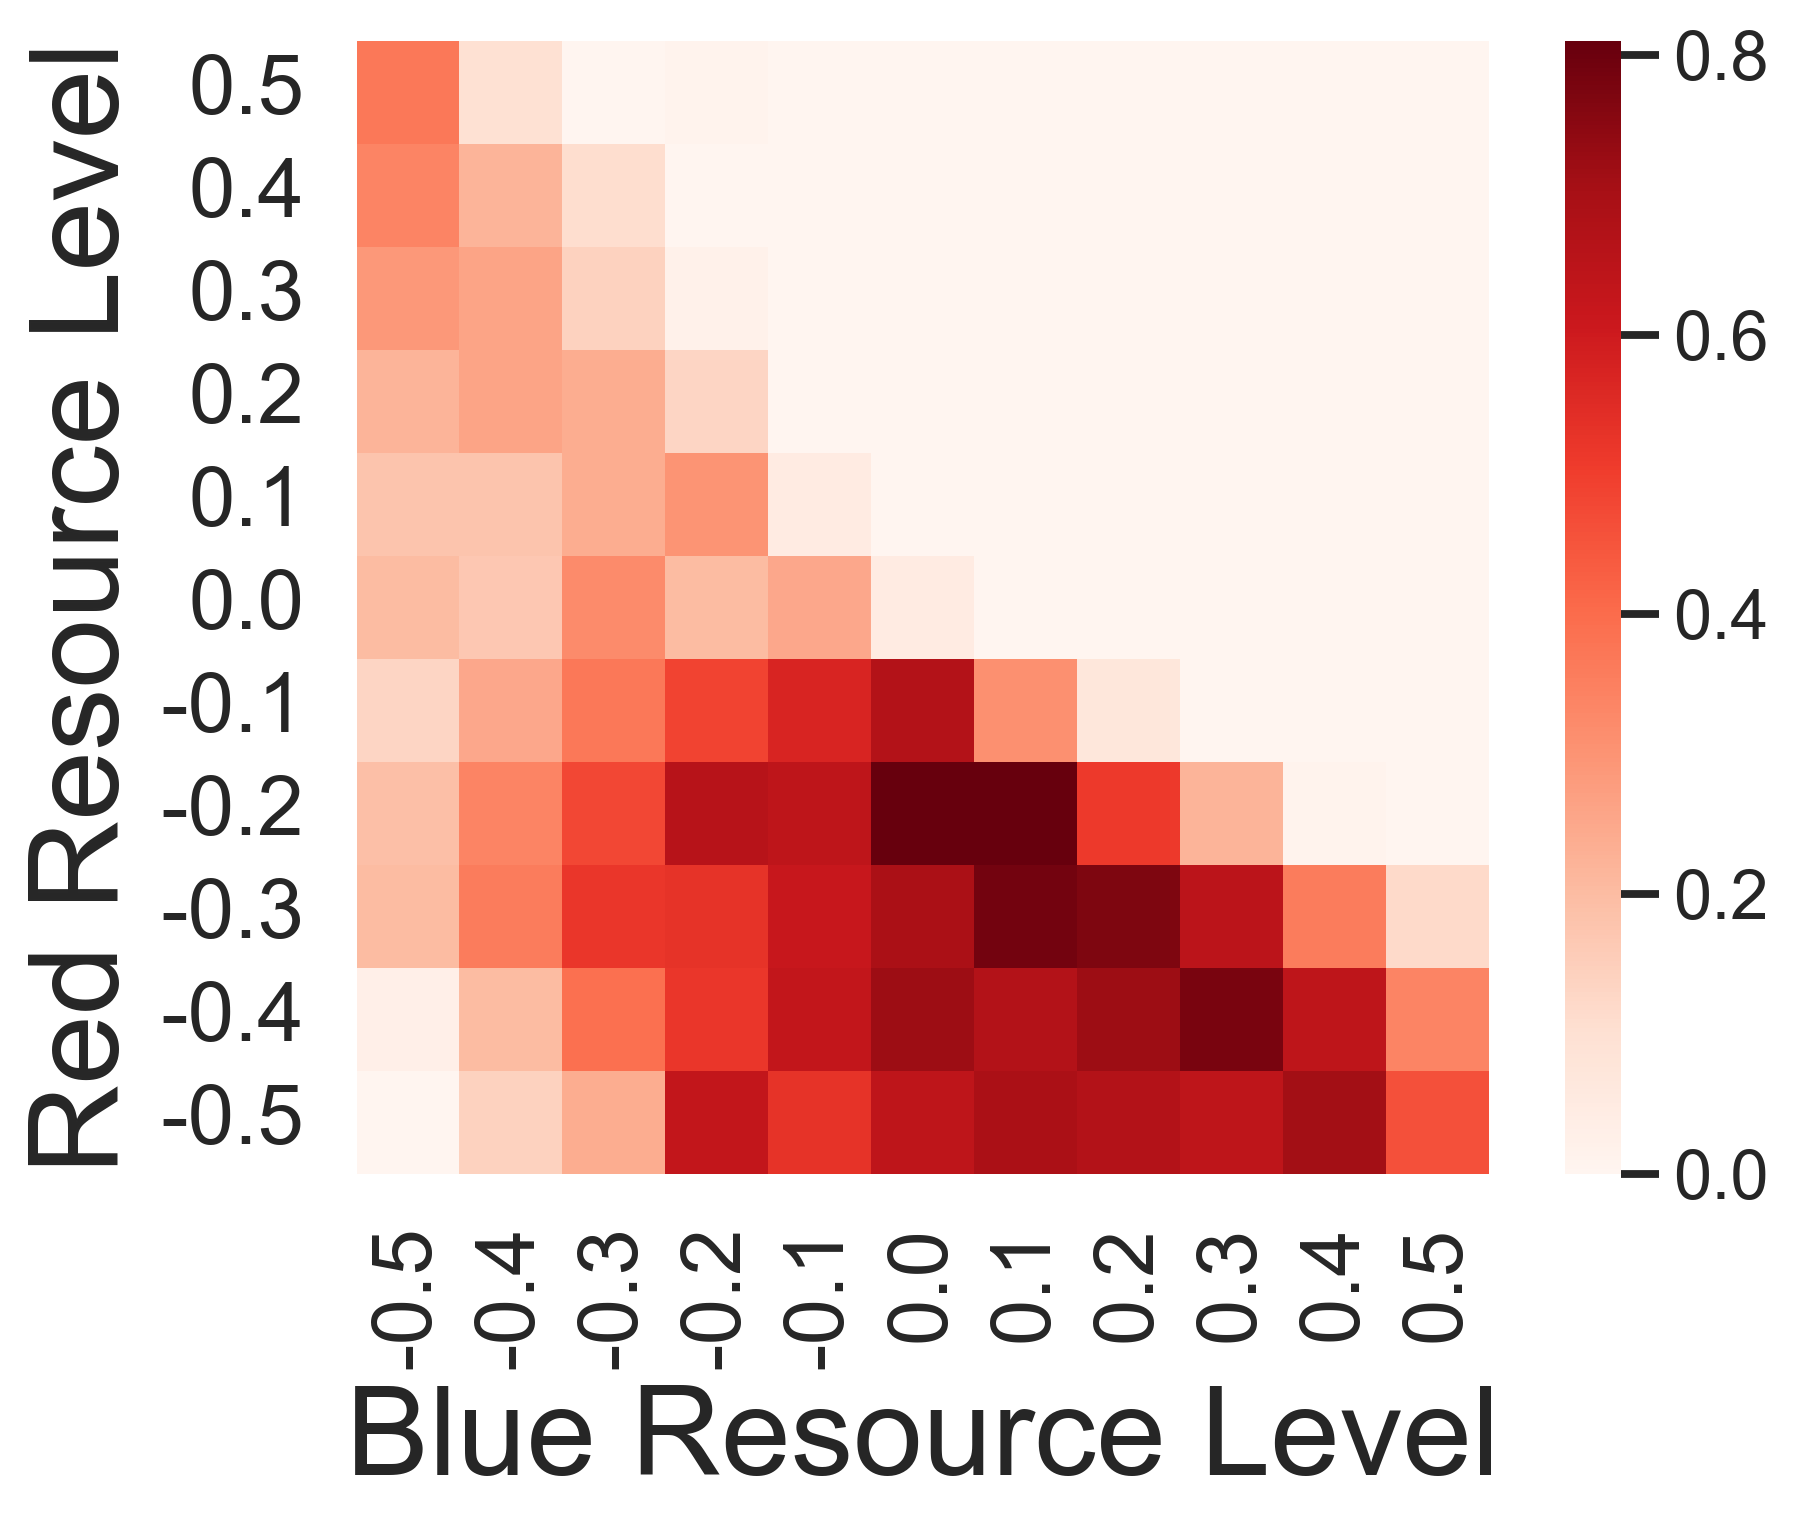

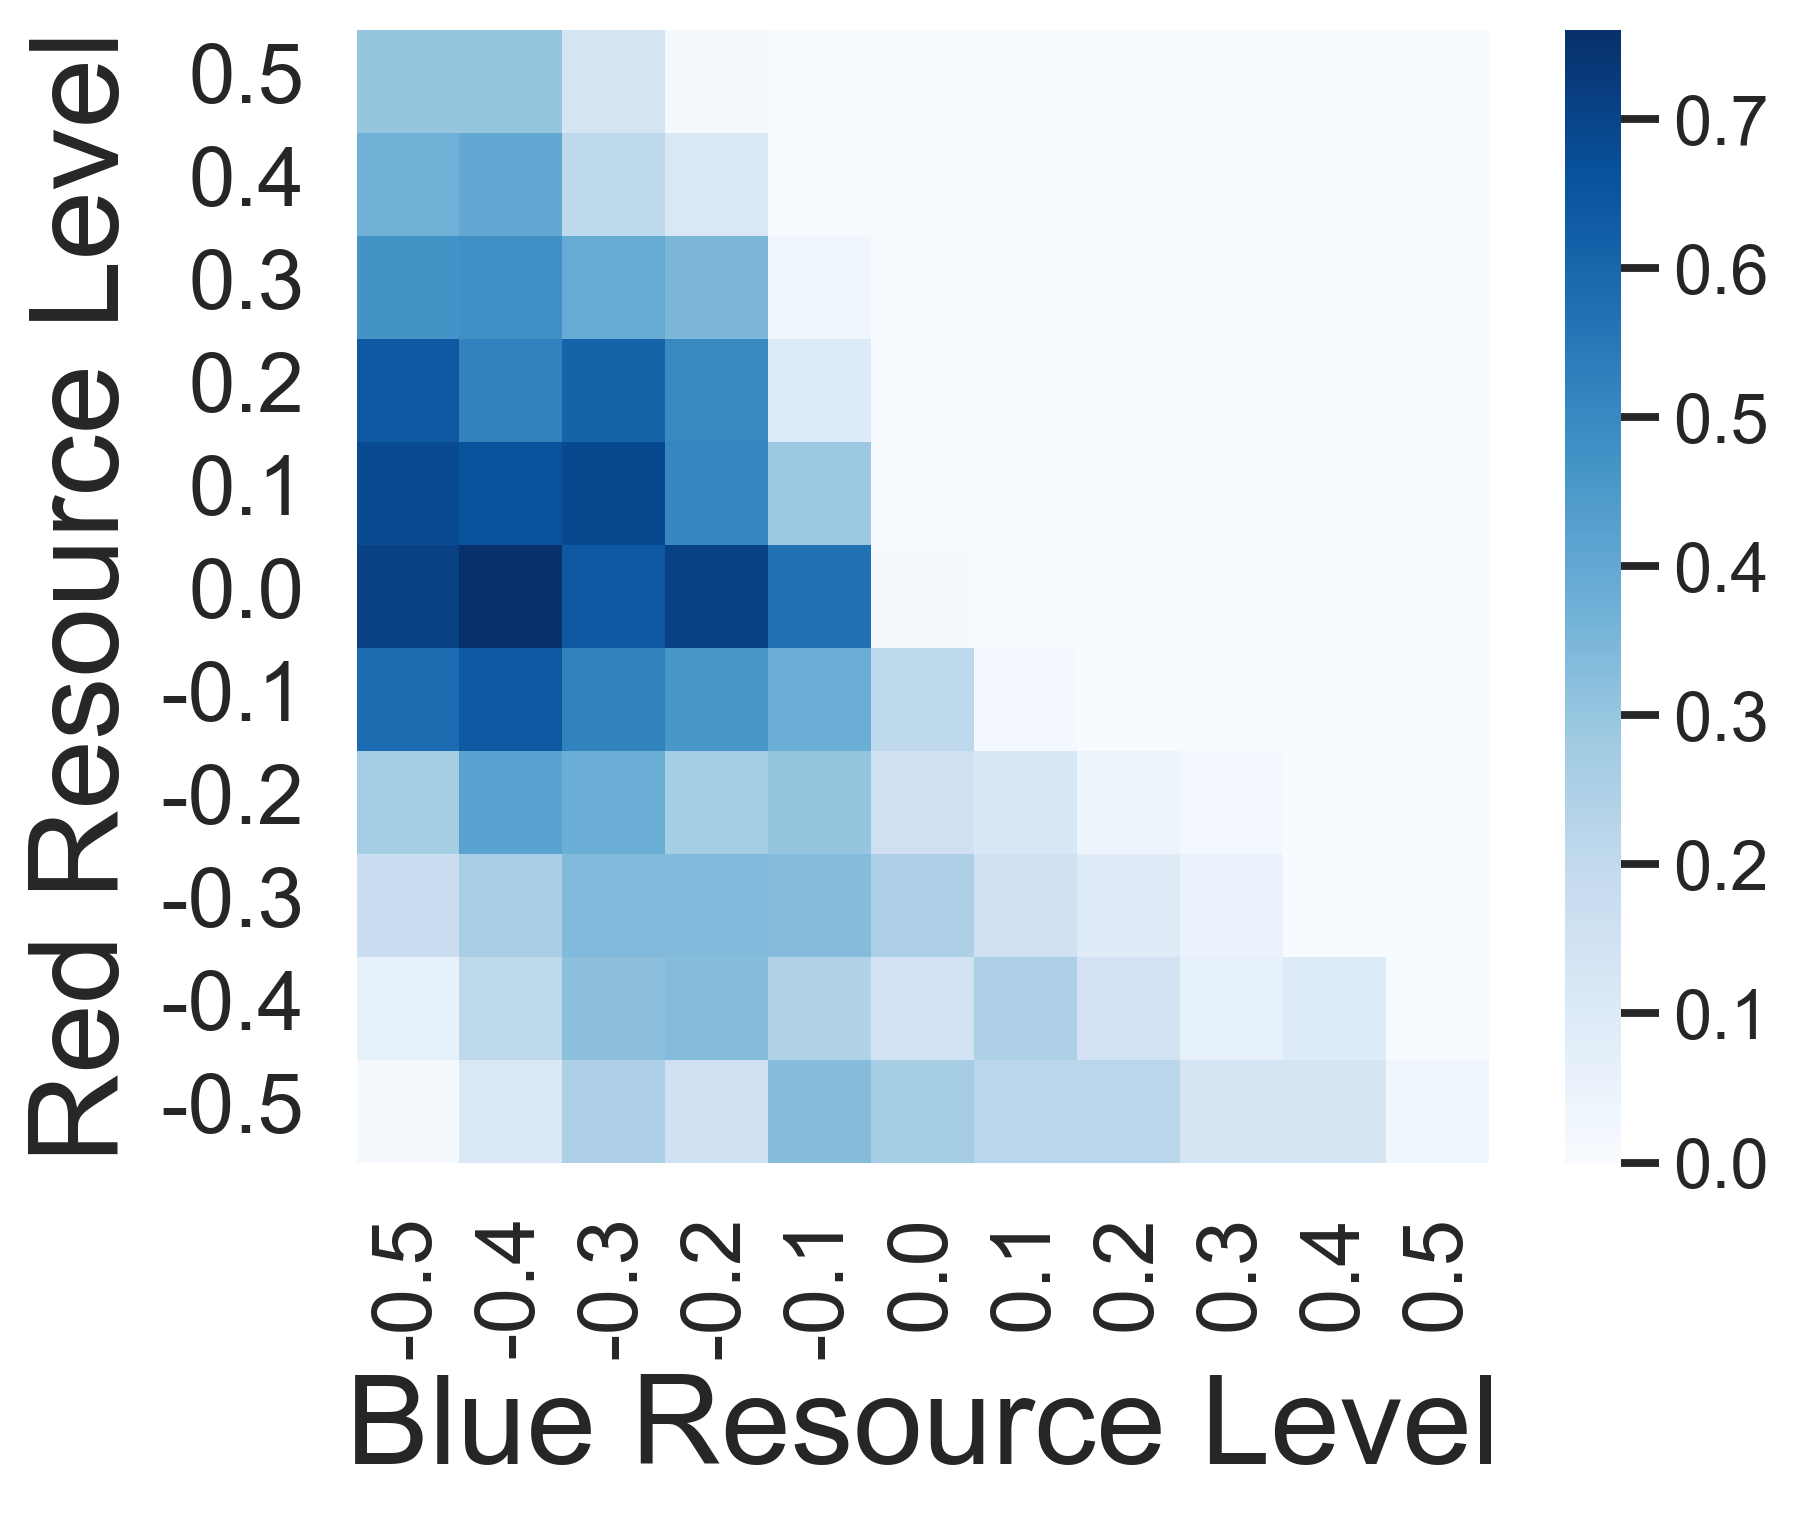

In [3]:
sns.set_context("talk")

plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap(data_red_matrix.transpose(),
                 cmap="Reds", #"binary_r",
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("red_matrix.png", bbox_inches='tight')
plt.show()

plt.figure(figsize=(6.5, 5), dpi=300)
ax =sns.heatmap(data_blue_matrix.transpose(),
                cmap="Blues", #"binary_r",
                square=True,
                xticklabels=blue_ticks.round(2),
                yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("blue_matrix.png", bbox_inches='tight')

/Users/naotoyoshida/.local/share/virtualenvs/ppo_pfrl-dDkQBMDa/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


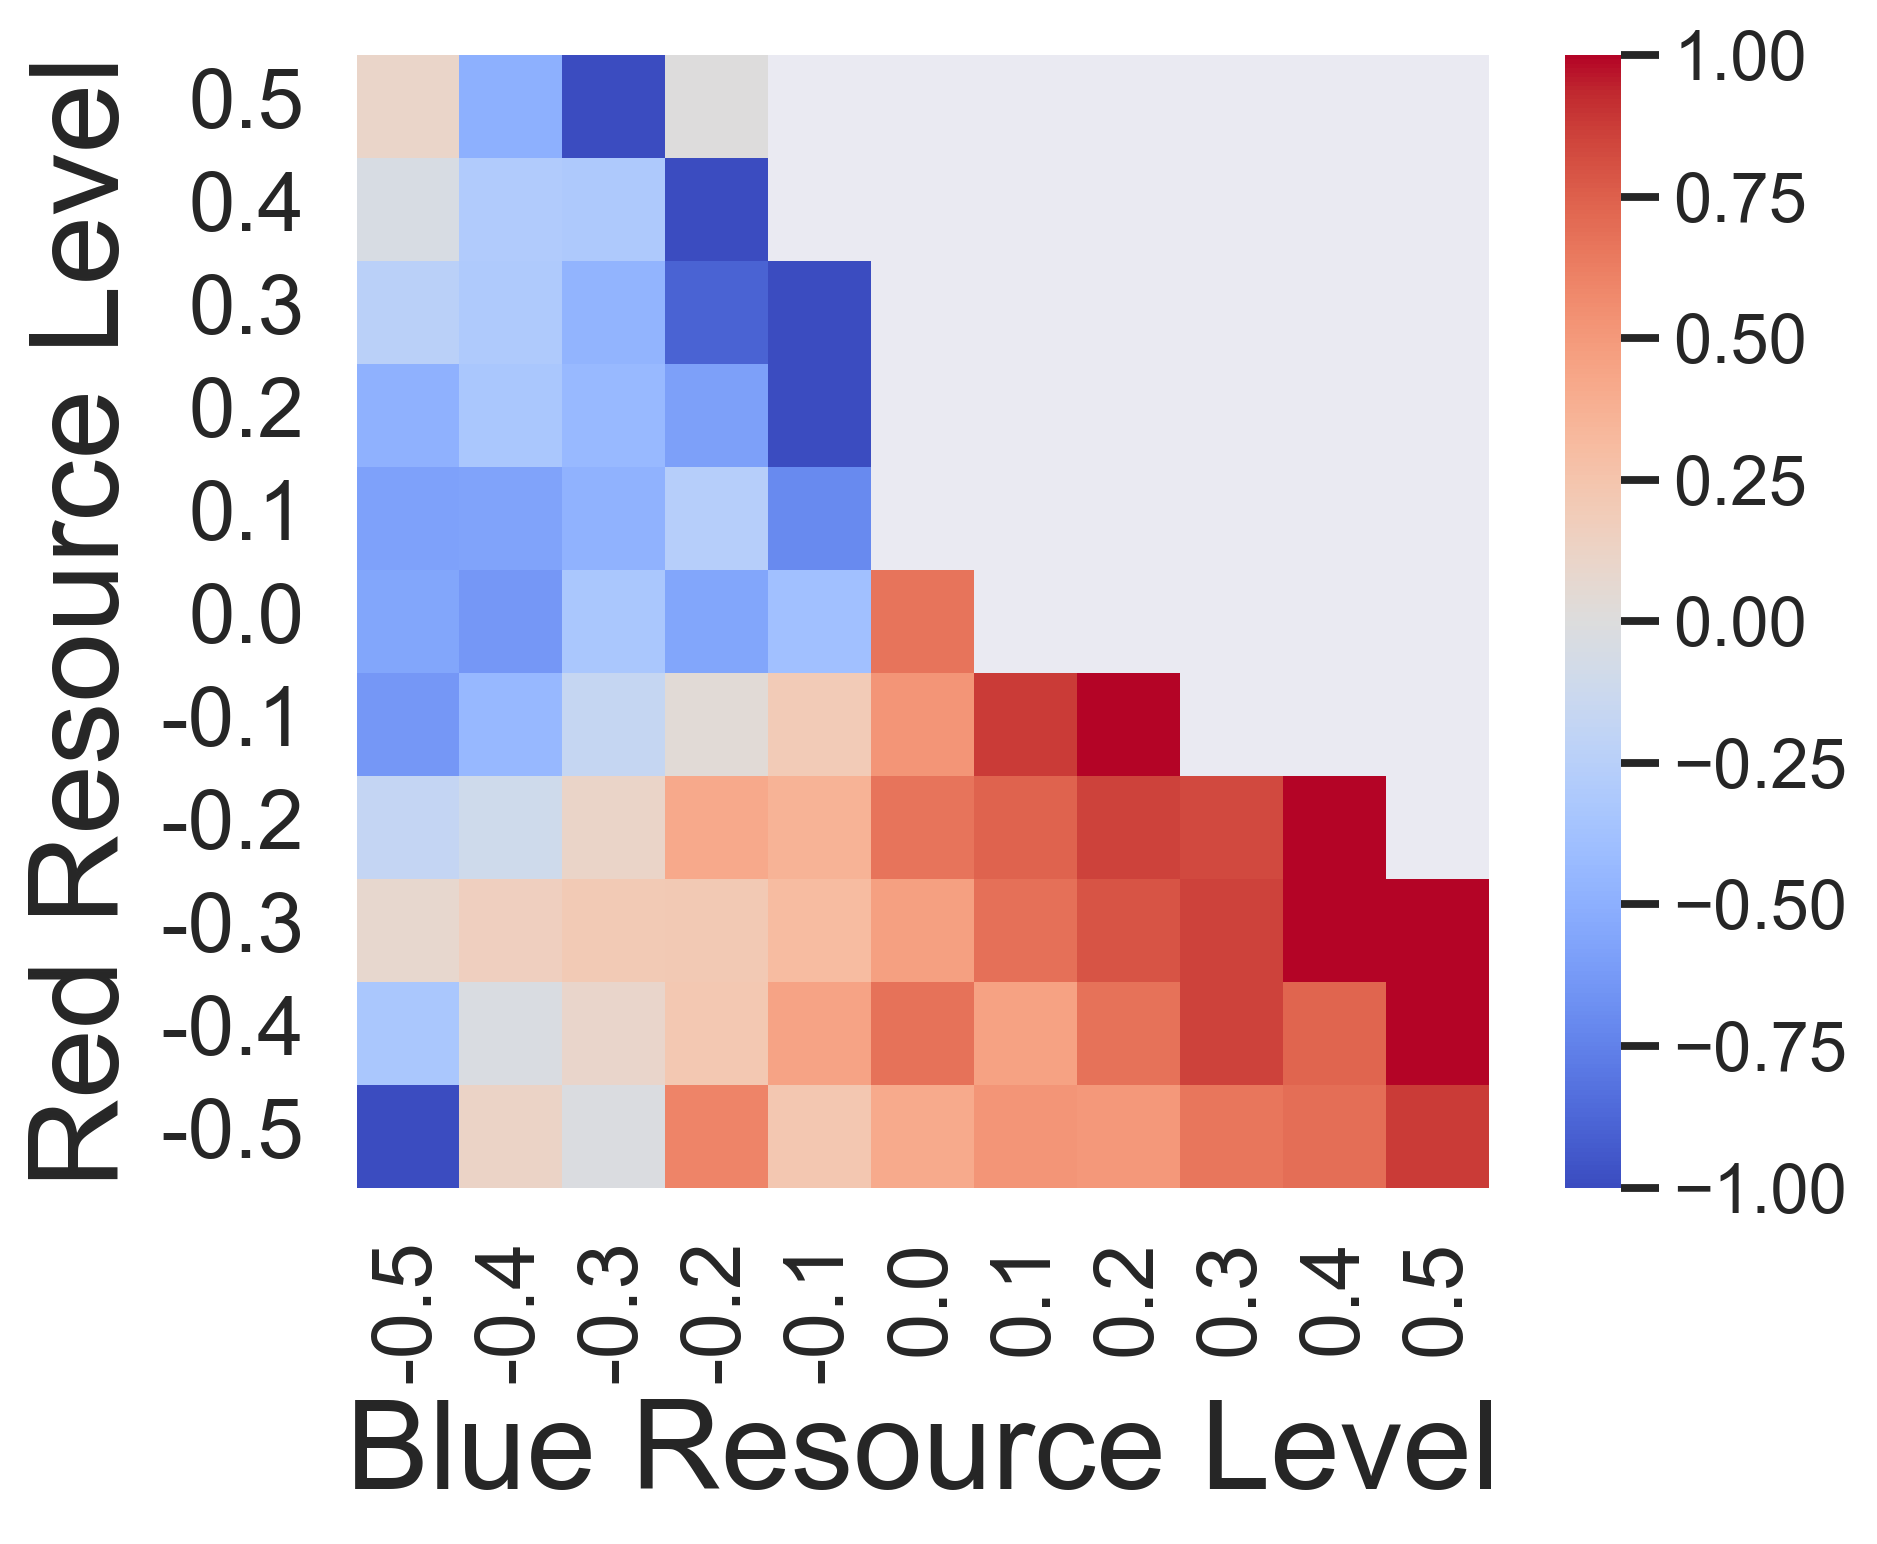

In [4]:
plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap(((data_red_matrix - data_blue_matrix)/(data_blue_matrix + data_red_matrix)).transpose(),
                 cmap='coolwarm',
                 center=0,
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("ba_pref_scaled.png", bbox_inches='tight')
plt.show()

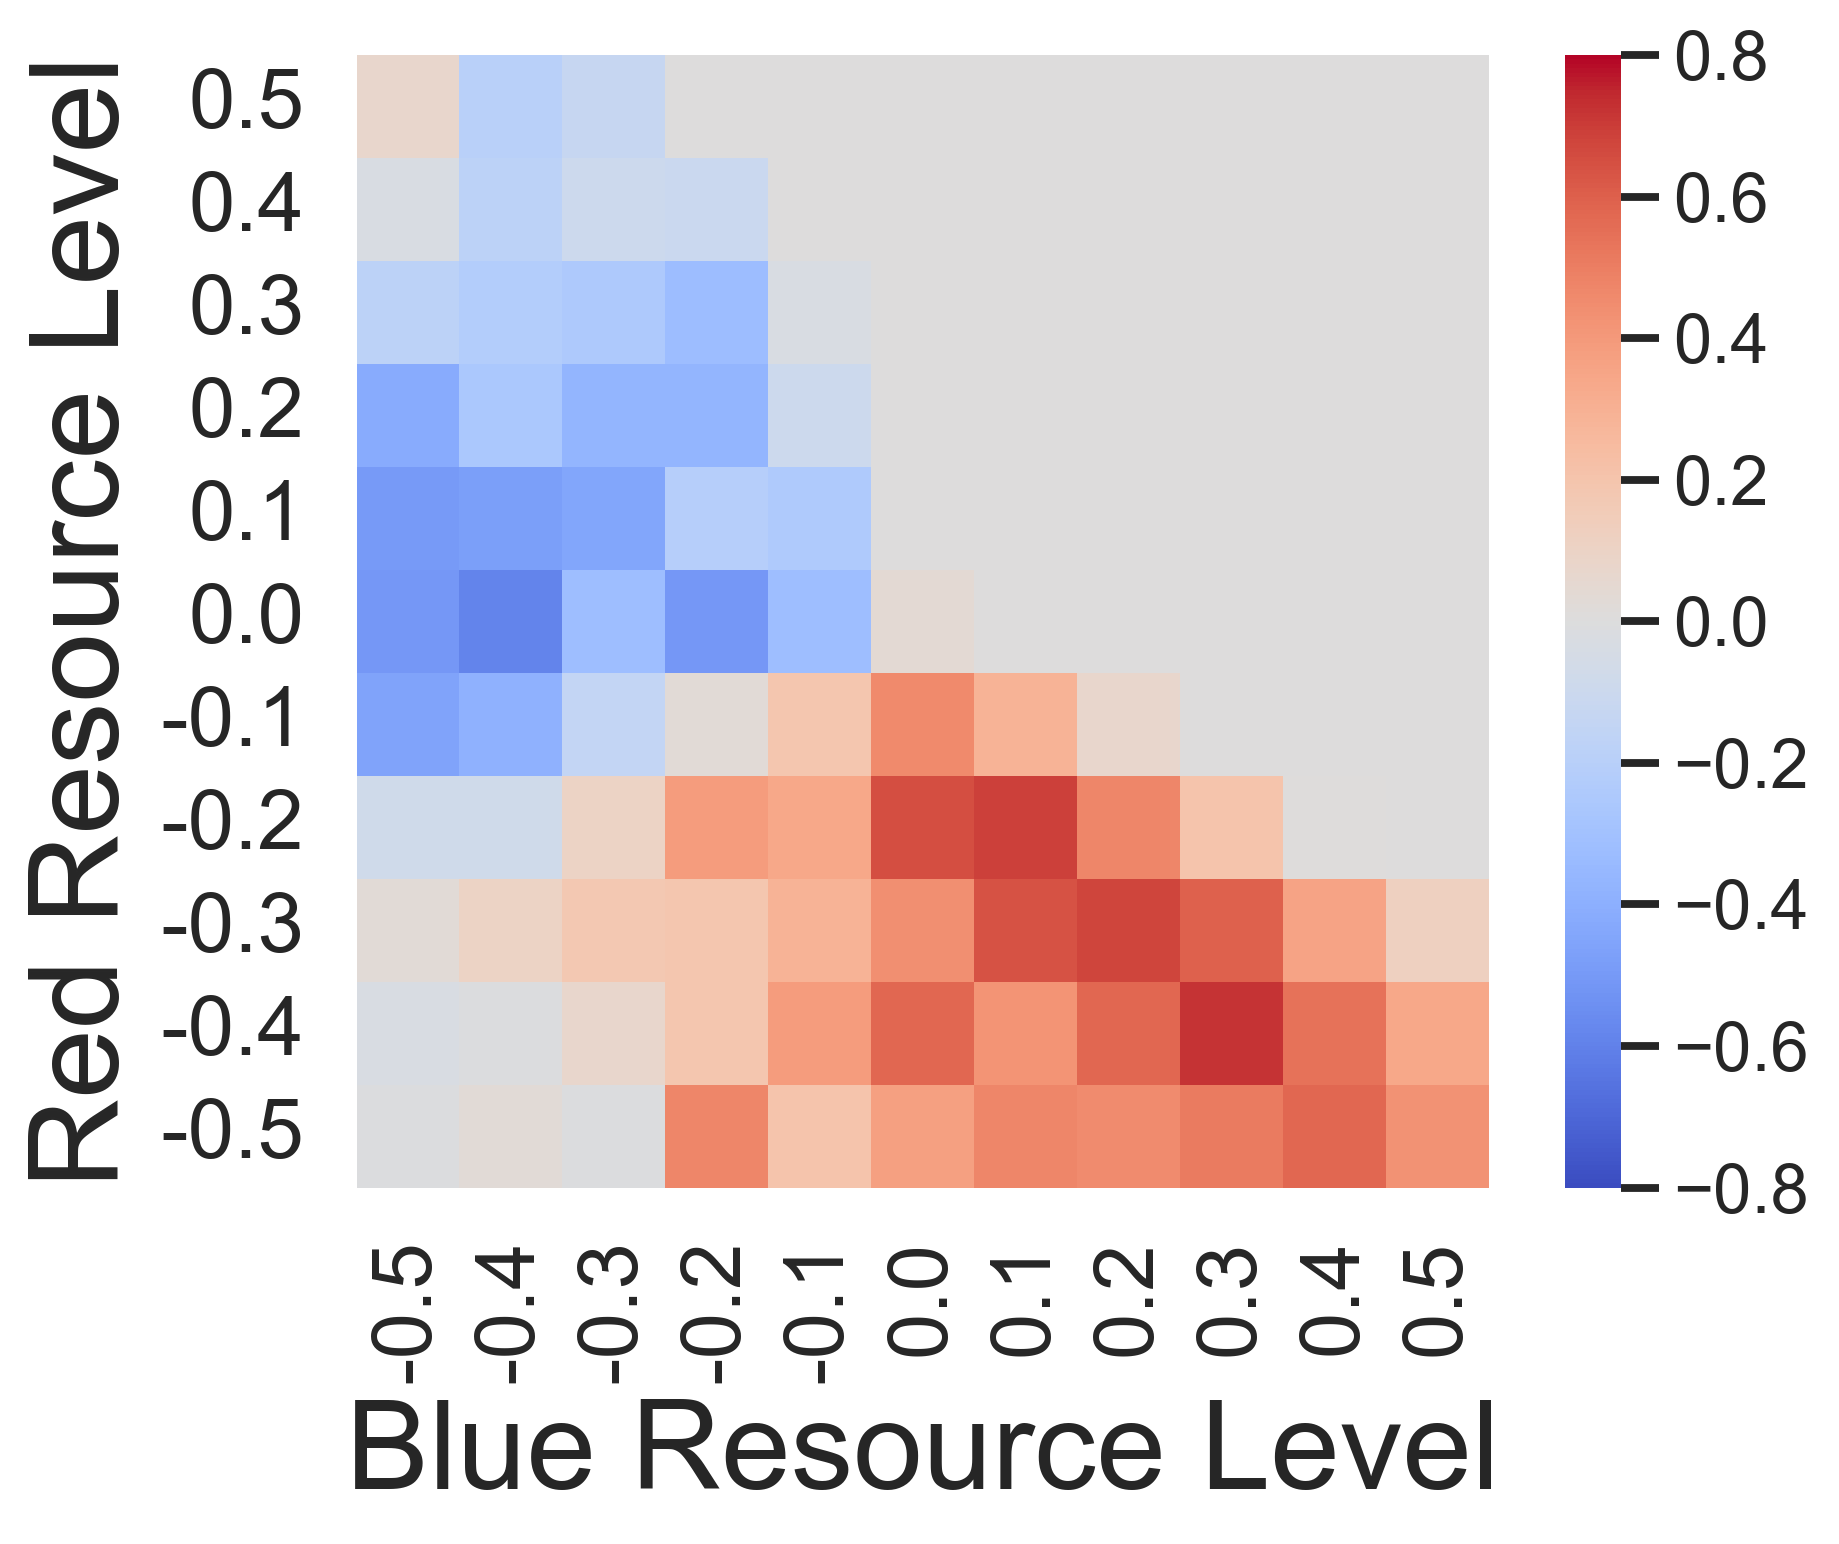

In [5]:
plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix - data_blue_matrix).transpose(),
                 cmap='coolwarm',
                 center=0,
                 vmin=-0.8,
                 vmax=0.8,
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("ba_ratio.png", bbox_inches='tight')

plt.show()

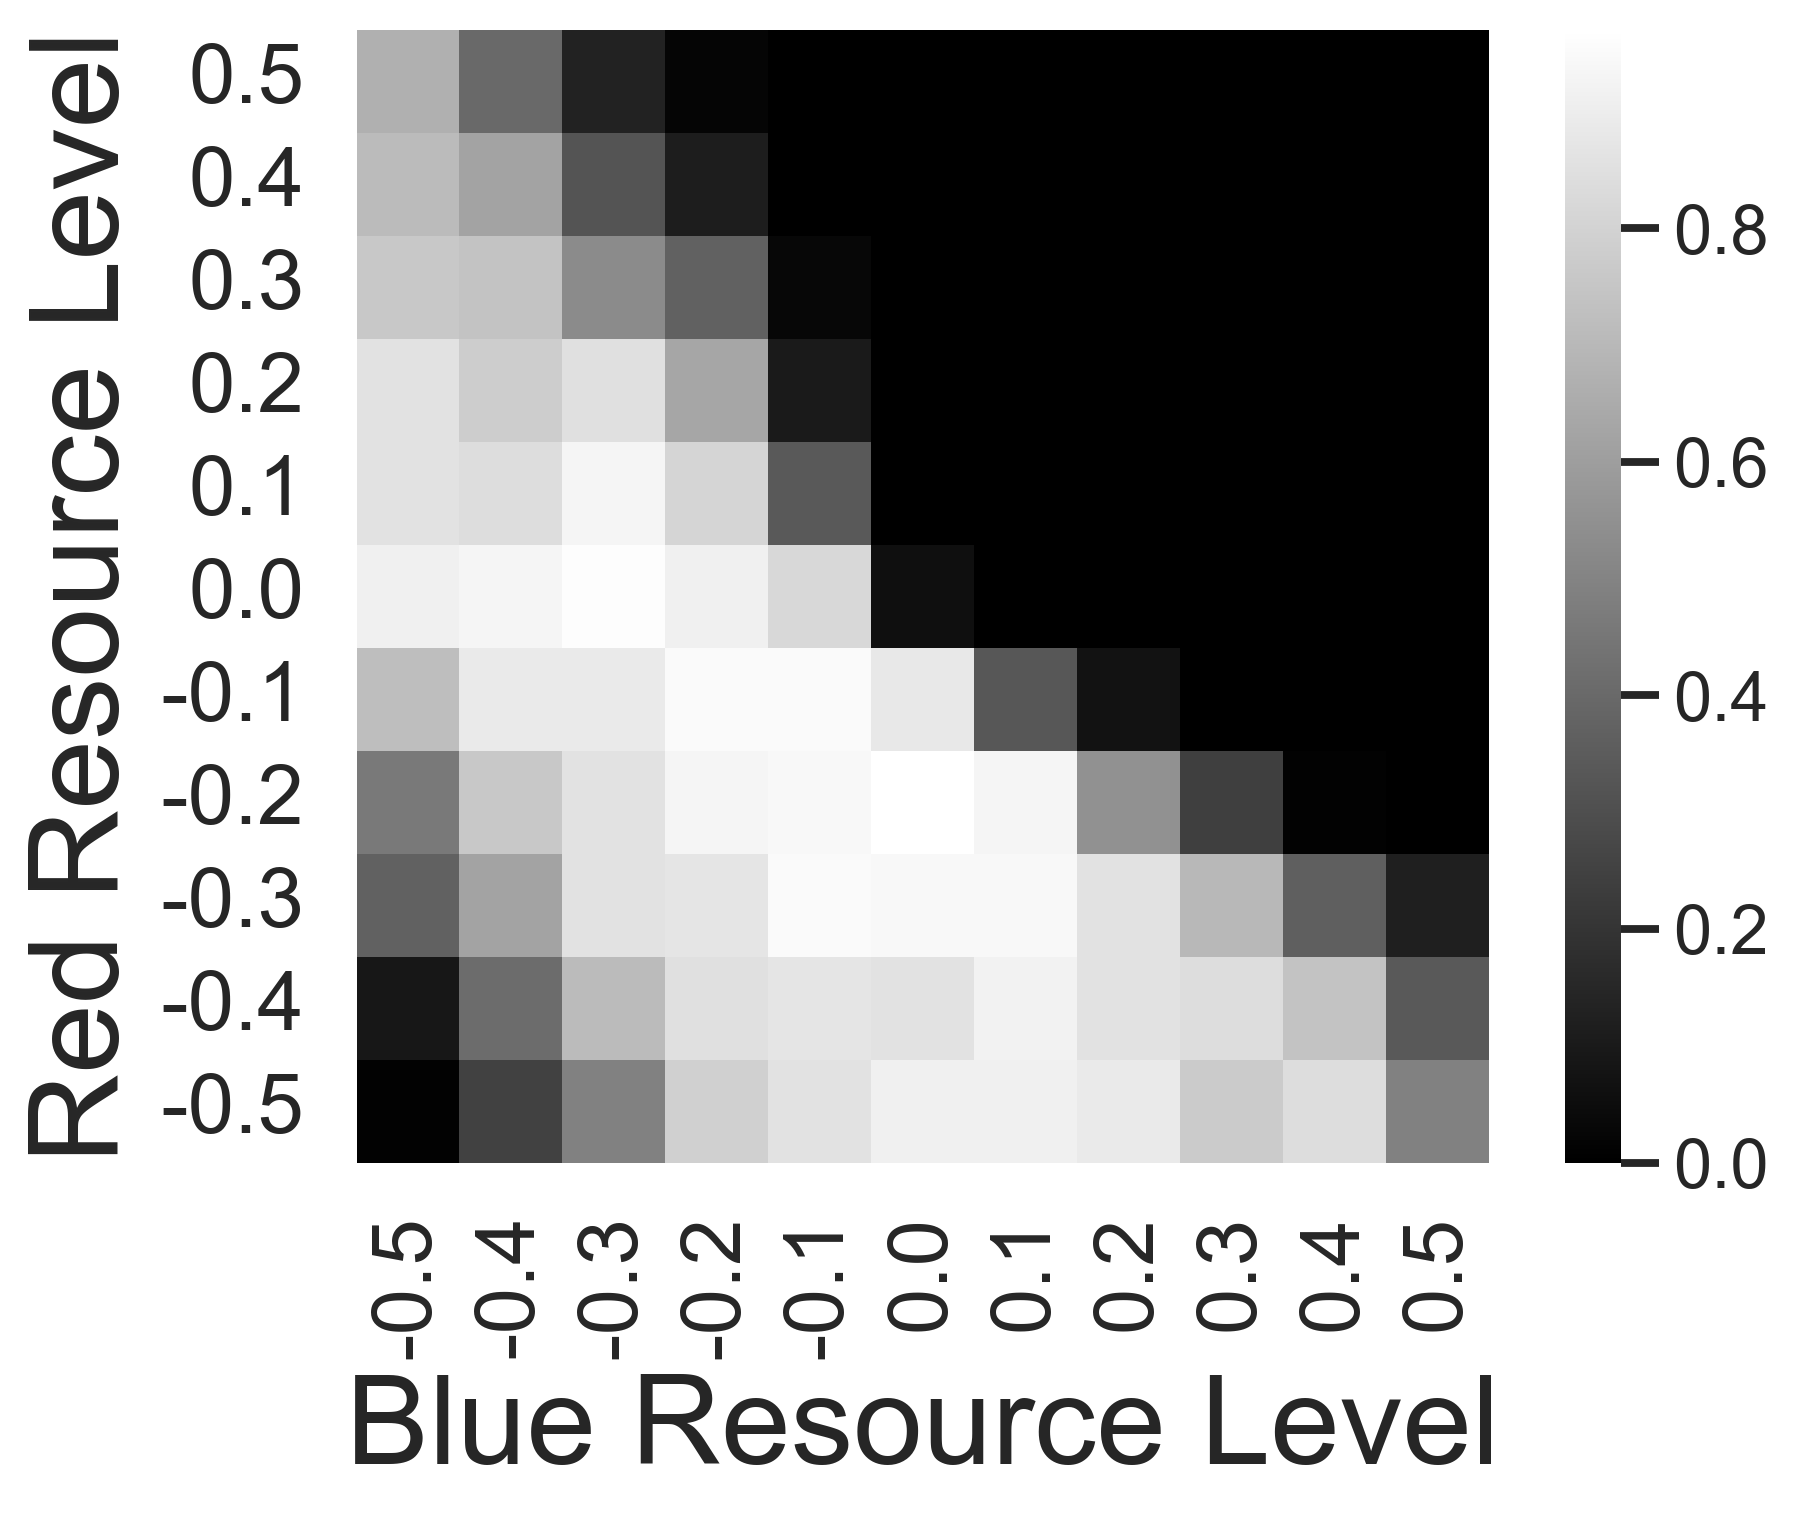

In [6]:
plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix + data_blue_matrix).transpose(),
                 cmap="binary_r",
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)
ax.invert_yaxis()

plt.savefig("ba_collection.png", bbox_inches='tight')

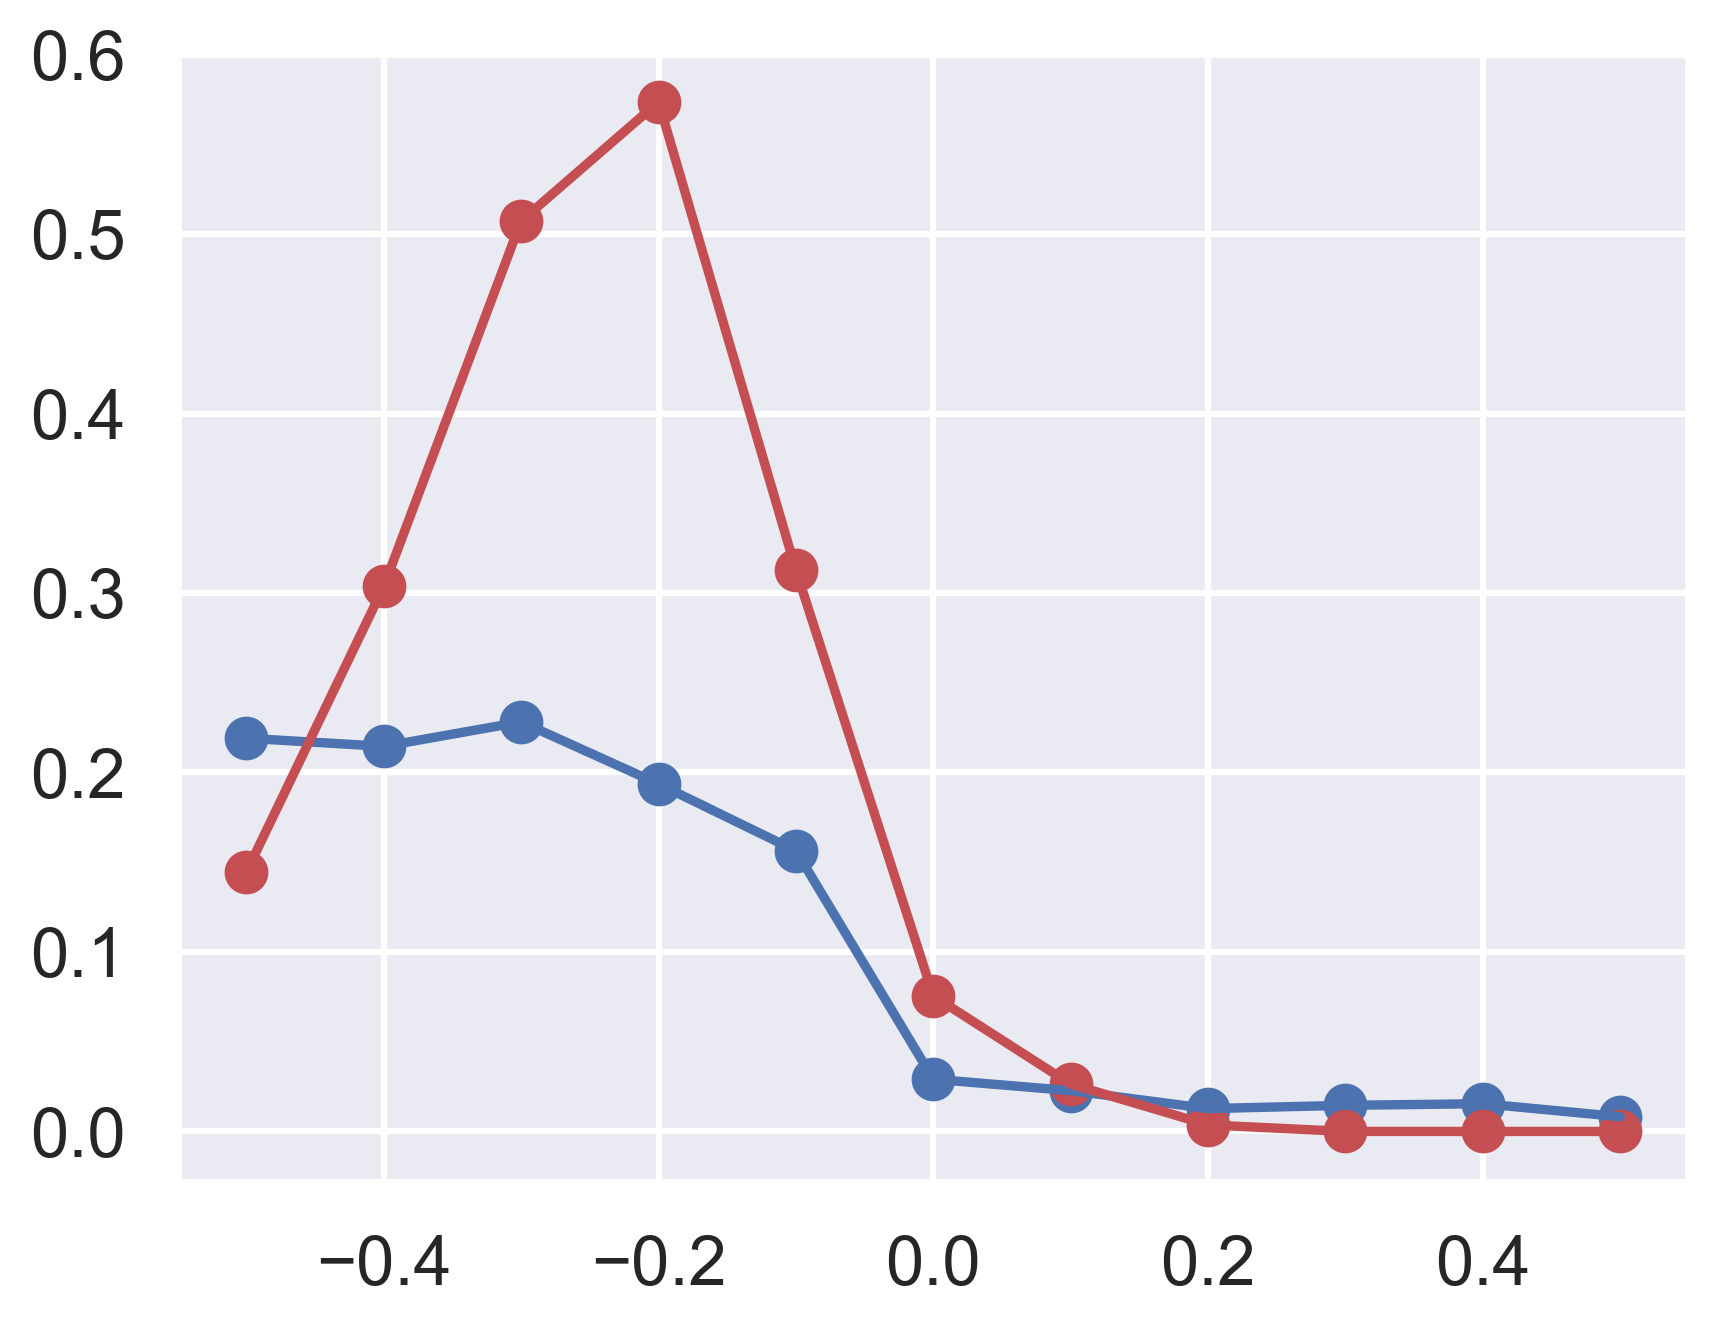

In [9]:
plt.figure(figsize=(6.5, 5), dpi=300)

plt.plot(blue_ticks, (data_blue_matrix / NUM_TICK).sum(axis=1), "b");
plt.plot(red_ticks, (data_red_matrix / NUM_TICK).sum(axis=0), "r");

plt.scatter(x=blue_ticks, y=(data_blue_matrix / NUM_TICK).sum(axis=1), c="b")
plt.scatter(x=red_ticks, y=(data_red_matrix / NUM_TICK).sum(axis=0), c="r")

plt.savefig("capturing_dist.png", bbox_inches='tight')

In [10]:
# Sampling Interoception distribution
time_limit = 50000

red_intero = []
blue_intero = []

env_trp = gym.make(
    "trp_env:SmallLowGearAntTRP-v0",
    max_episode_steps=np.inf,
    internal_reset="setpoint",
    n_bins=20,
    sensor_range=16,
)
env_trp = RescaleAction(env_trp, 0, 1)
env_trp = pfrl.wrappers.CastObservationToFloat32(env_trp)

t = 0
obs = env_trp.reset()
done = False
for _ in range(time_limit):
    intero = env_trp.get_interoception()
    blue_intero.append(intero[0])
    red_intero.append(intero[1])
    
    action = agent.act(obs)
    obs, _, done, _ = env_trp.step(action)
    t += 1
    if t % 5000 == 0:
        print(t)
    #env_trp.render()
    if done or t > time_limit:
        break

blue_intero = np.array(blue_intero)
red_intero = np.array(red_intero)
print("sampling done.: ", blue_intero.size)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
sampling done.:  50000


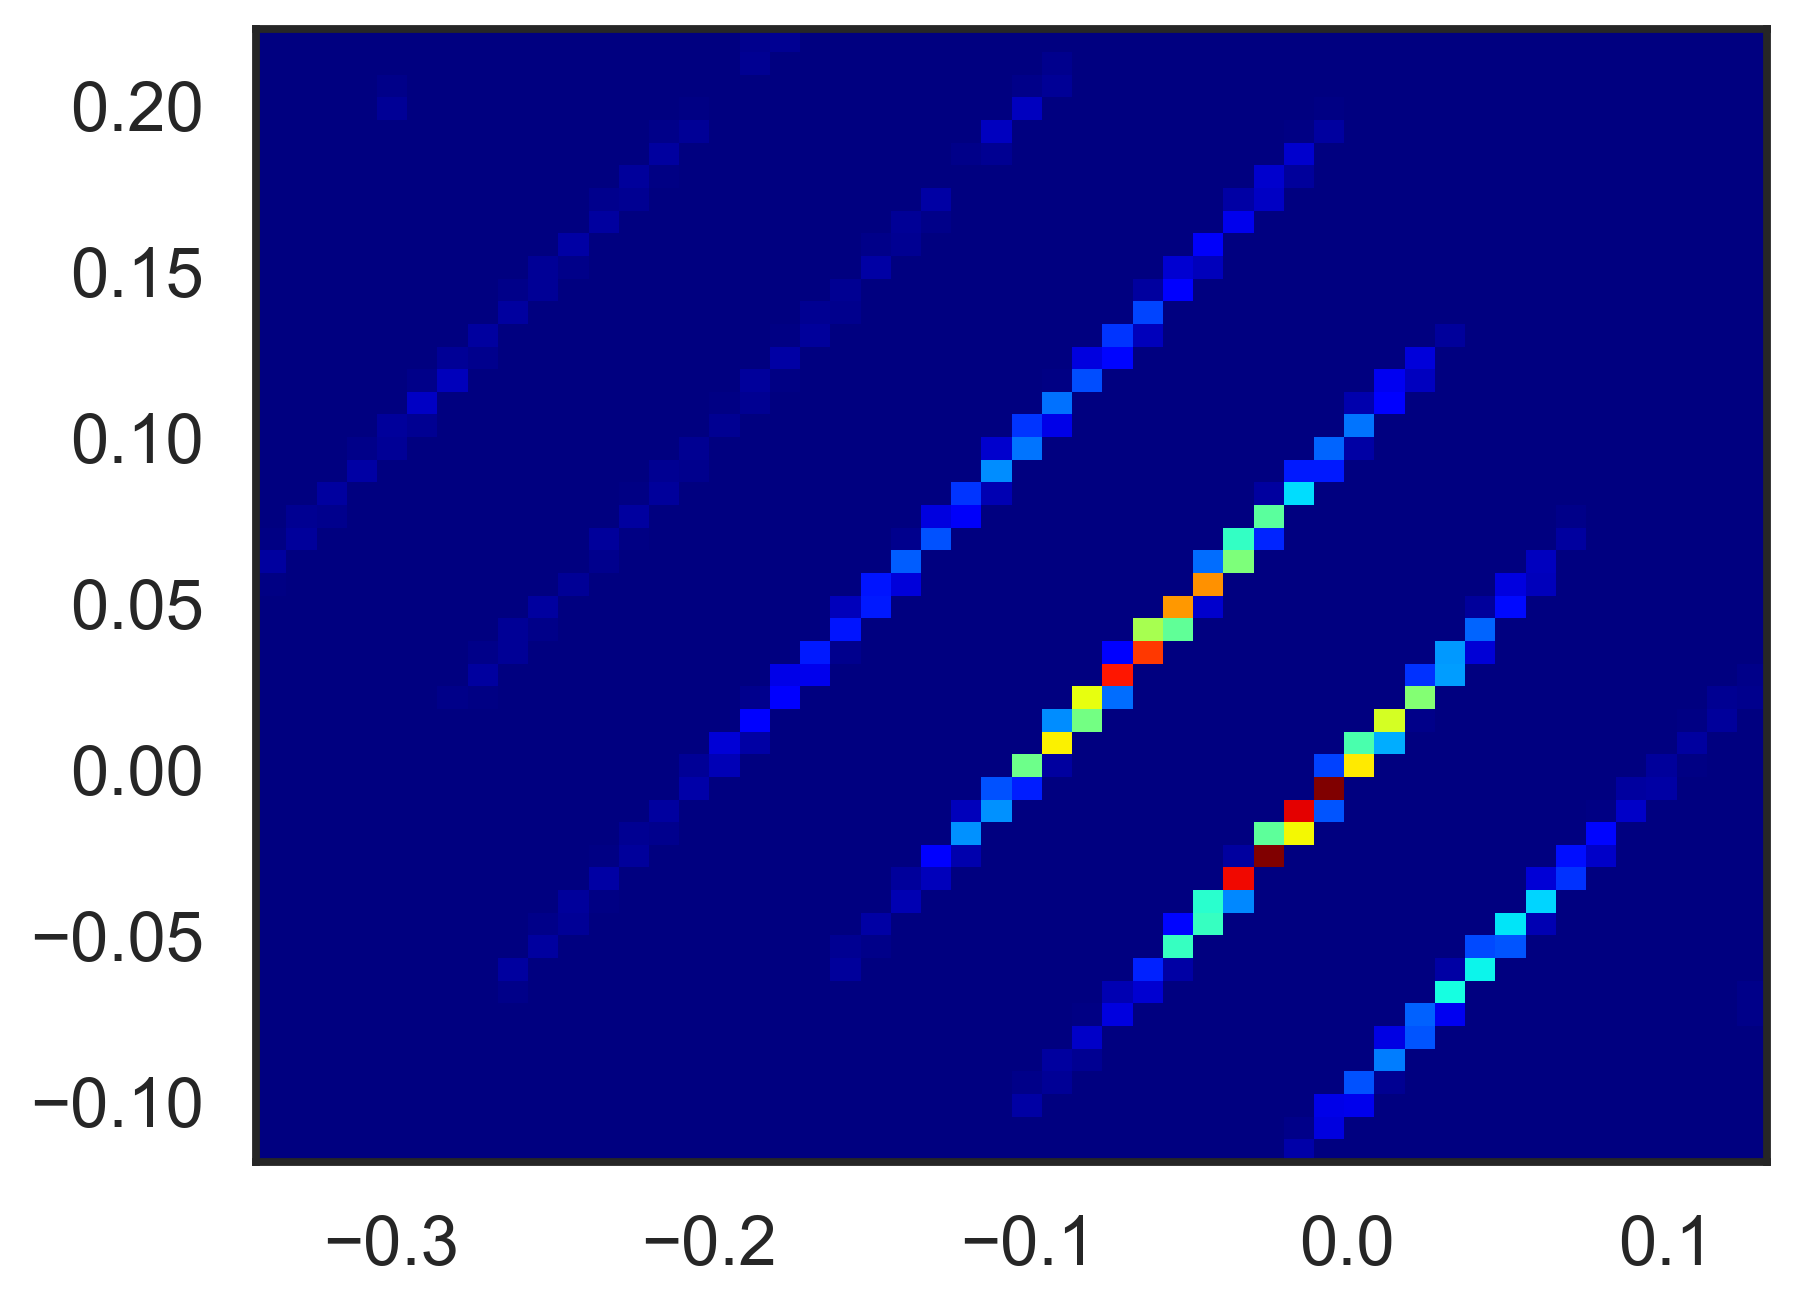

In [11]:
sns.set_style("white")
plt.figure(figsize=(6.5, 5), dpi=300)

# Basic 2D density plot
plt.hist2d(blue_intero,
           red_intero,
           cmap=plt.cm.jet, bins=50)
plt.show()

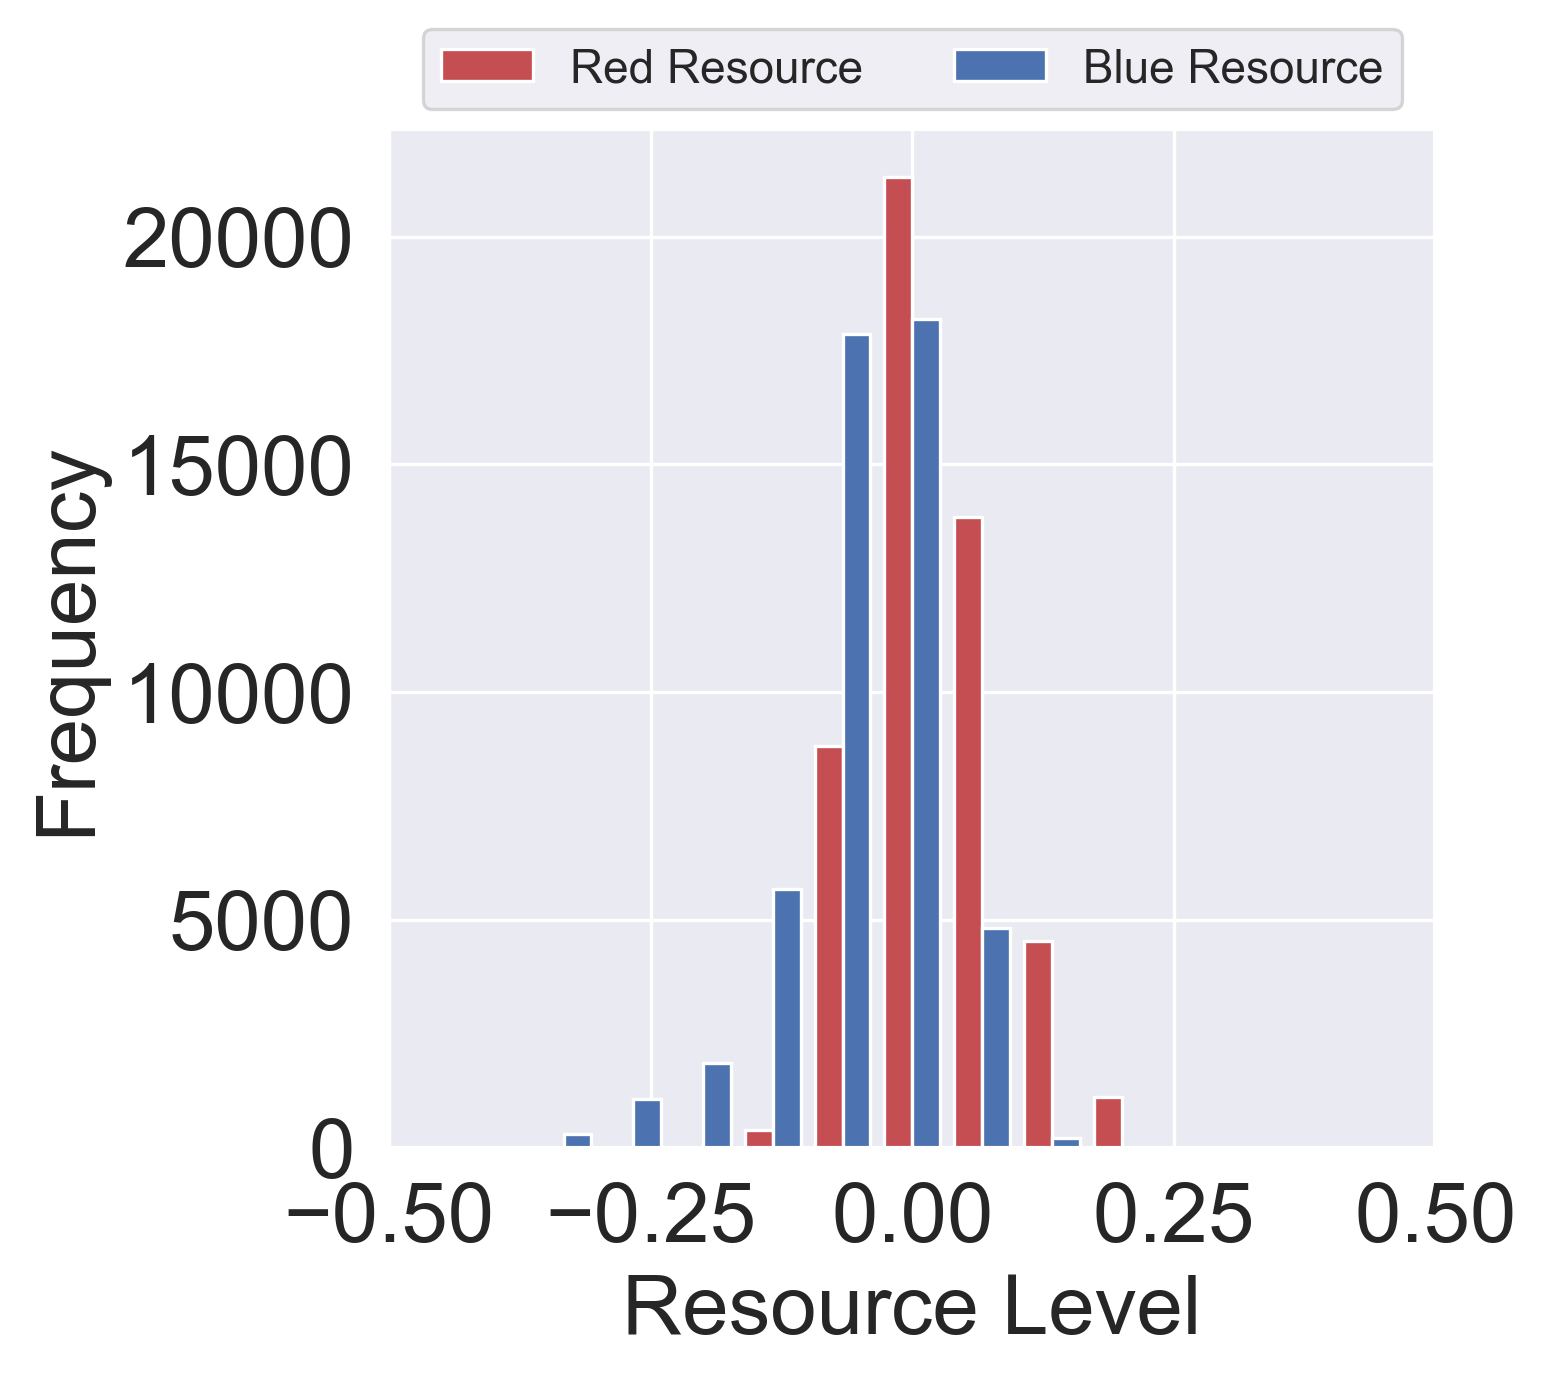

In [12]:
# plt.hist(blue_intero, color=(0, 0, 1, 0.2), density=True)
# plt.hist(red_intero, color=(1, 0, 0, 0.2), density=True)
sns.set()
sns.set_context("paper")

plt.figure(figsize=(4.5, 4.5), dpi=300)
y = np.hstack([red_intero.reshape(time_limit, 1), blue_intero.reshape(time_limit, 1)])
plt.hist(y, color=["r", "b"], bins=15, range=(-0.5, 0.5))
plt.xlim([-0.5, 0.5])
#plt.xticks([-0.5, -0.25, 0, 0.25, 0.5])

plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Resource Level", fontsize=20)
plt.legend(["Red Resource", "Blue Resource"],
           bbox_to_anchor=(0.5, 1.12), loc='upper center', ncol=4, prop={'size': 11})
plt.tick_params(labelsize=20)

# from scipy.stats import norm
# bmu, bsigma = norm.fit(blue_intero)
# rmu, rsigma = norm.fit(red_intero)

# print(bmu, bsigma)
# print(rmu, rsigma)
# x = np.linspace(-0.3, 0.3, 100)
# y = norm.pdf(x, loc=0, scale=0.06)
# plt.plot(x, y, color=(0,0,0,0.3))

plt.savefig("intero_distribution50000", bbox_inches='tight')

# 8x2 TRP Experiment

START NEW PARAM: data/trp8x2-homeostatic_shaped2021-12-09-16-33-32/150000000_finish/
0/5 - internal @ 1/121: (blue, red) = (-0.5, -0.5) [RESULT: blue/red: 0.0/0.0] 
0/5 - internal @ 2/121: (blue, red) = (-0.5, -0.4) [RESULT: blue/red: 0.0/0.0] 
0/5 - internal @ 3/121: (blue, red) = (-0.5, -0.3) [RESULT: blue/red: 1.0/0.0] 
0/5 - internal @ 4/121: (blue, red) = (-0.5, -0.19999999999999996) [RESULT: blue/red: 22.0/3.0] 
0/5 - internal @ 5/121: (blue, red) = (-0.5, -0.09999999999999998) [RESULT: blue/red: 30.0/11.0] 
0/5 - internal @ 6/121: (blue, red) = (-0.5, 0.0) [RESULT: blue/red: 21.0/4.0] 
0/5 - internal @ 7/121: (blue, red) = (-0.5, 0.10000000000000009) [RESULT: blue/red: 1.0/4.0] 
0/5 - internal @ 8/121: (blue, red) = (-0.5, 0.20000000000000007) [RESULT: blue/red: 0.0/0.0] 
0/5 - internal @ 9/121: (blue, red) = (-0.5, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 
0/5 - internal @ 10/121: (blue, red) = (-0.5, 0.4) [RESULT: blue/red: 0.0/0.0] 
0/5 - internal @ 11/121: (blue, red

0/5 - internal @ 86/121: (blue, red) = (0.20000000000000007, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 
0/5 - internal @ 87/121: (blue, red) = (0.20000000000000007, 0.4) [RESULT: blue/red: 0.0/0.0] 
0/5 - internal @ 88/121: (blue, red) = (0.20000000000000007, 0.5) [RESULT: blue/red: 0.0/0.0] 
0/5 - internal @ 89/121: (blue, red) = (0.30000000000000004, -0.5) [RESULT: blue/red: 6.0/29.0] 
0/5 - internal @ 90/121: (blue, red) = (0.30000000000000004, -0.4) [RESULT: blue/red: 17.0/47.0] 
0/5 - internal @ 91/121: (blue, red) = (0.30000000000000004, -0.3) [RESULT: blue/red: 14.0/73.0] 
0/5 - internal @ 92/121: (blue, red) = (0.30000000000000004, -0.19999999999999996) [RESULT: blue/red: 8.0/54.0] 
0/5 - internal @ 93/121: (blue, red) = (0.30000000000000004, -0.09999999999999998) [RESULT: blue/red: 0.0/10.0] 
0/5 - internal @ 94/121: (blue, red) = (0.30000000000000004, 0.0) [RESULT: blue/red: 0.0/0.0] 
0/5 - internal @ 95/121: (blue, red) = (0.30000000000000004, 0.10000000000000009) [RE

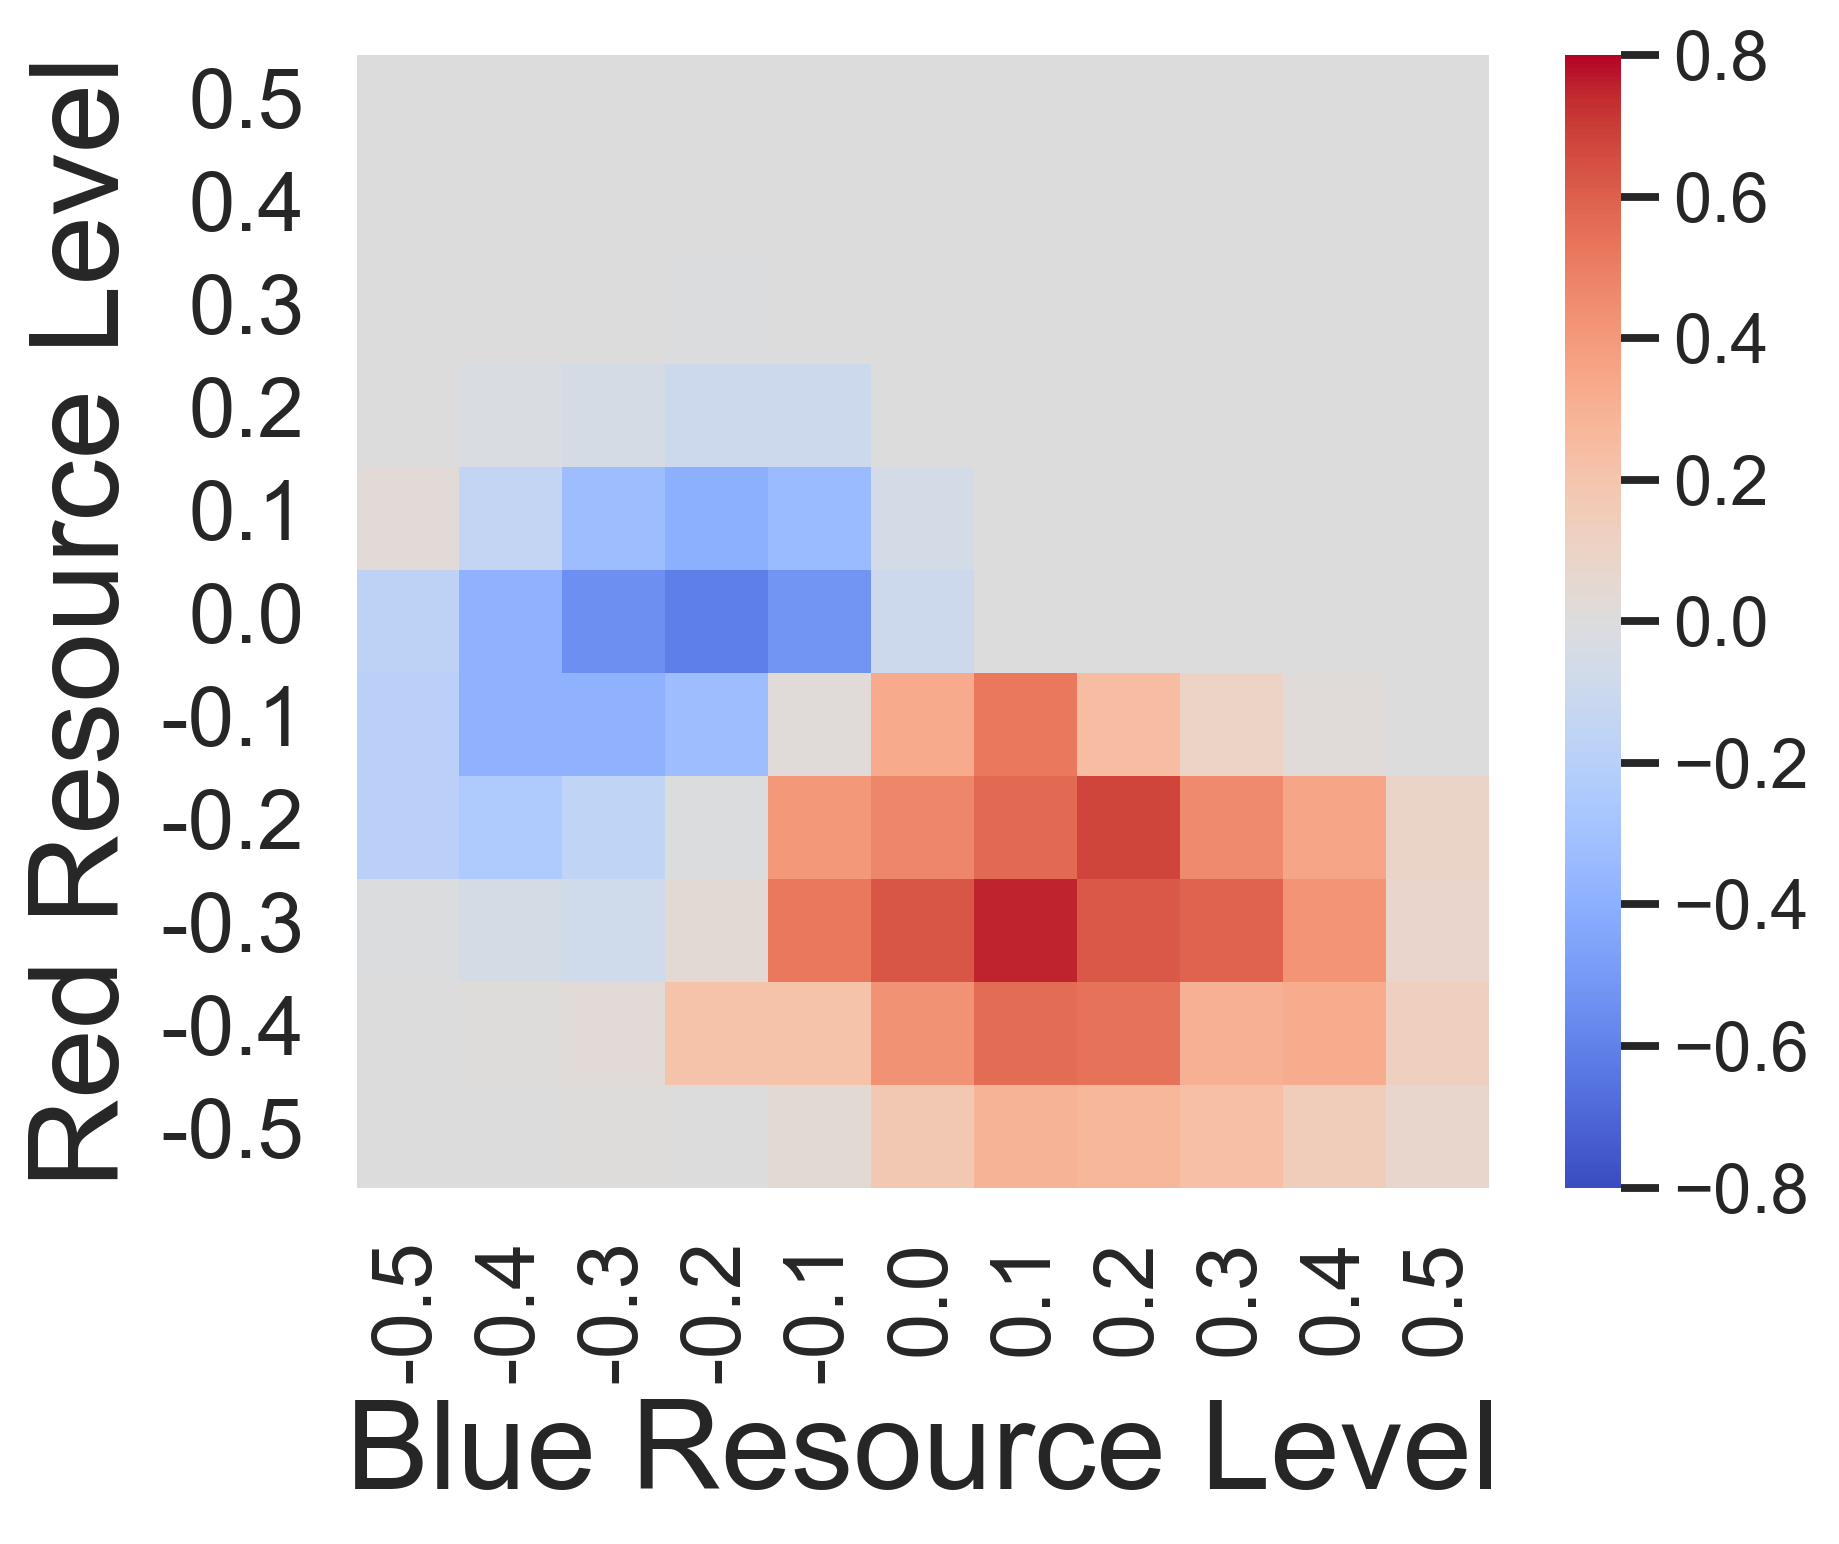

START NEW PARAM: data/trp8x2-homeostatic_shaped2021-12-09-16-37-00/150000000_finish/
1/5 - internal @ 1/121: (blue, red) = (-0.5, -0.5) [RESULT: blue/red: 37.0/42.0] 
1/5 - internal @ 2/121: (blue, red) = (-0.5, -0.4) [RESULT: blue/red: 53.0/30.0] 
1/5 - internal @ 3/121: (blue, red) = (-0.5, -0.3) [RESULT: blue/red: 54.0/33.0] 
1/5 - internal @ 4/121: (blue, red) = (-0.5, -0.19999999999999996) [RESULT: blue/red: 51.0/15.0] 
1/5 - internal @ 5/121: (blue, red) = (-0.5, -0.09999999999999998) [RESULT: blue/red: 40.0/14.0] 
1/5 - internal @ 6/121: (blue, red) = (-0.5, 0.0) [RESULT: blue/red: 17.0/6.0] 
1/5 - internal @ 7/121: (blue, red) = (-0.5, 0.10000000000000009) [RESULT: blue/red: 7.0/1.0] 
1/5 - internal @ 8/121: (blue, red) = (-0.5, 0.20000000000000007) [RESULT: blue/red: 0.0/0.0] 
1/5 - internal @ 9/121: (blue, red) = (-0.5, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 
1/5 - internal @ 10/121: (blue, red) = (-0.5, 0.4) [RESULT: blue/red: 0.0/0.0] 
1/5 - internal @ 11/121: (bl

1/5 - internal @ 86/121: (blue, red) = (0.20000000000000007, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 
1/5 - internal @ 87/121: (blue, red) = (0.20000000000000007, 0.4) [RESULT: blue/red: 0.0/0.0] 
1/5 - internal @ 88/121: (blue, red) = (0.20000000000000007, 0.5) [RESULT: blue/red: 0.0/0.0] 
1/5 - internal @ 89/121: (blue, red) = (0.30000000000000004, -0.5) [RESULT: blue/red: 0.0/31.0] 
1/5 - internal @ 90/121: (blue, red) = (0.30000000000000004, -0.4) [RESULT: blue/red: 6.0/52.0] 
1/5 - internal @ 91/121: (blue, red) = (0.30000000000000004, -0.3) [RESULT: blue/red: 6.0/45.0] 
1/5 - internal @ 92/121: (blue, red) = (0.30000000000000004, -0.19999999999999996) [RESULT: blue/red: 0.0/12.0] 
1/5 - internal @ 93/121: (blue, red) = (0.30000000000000004, -0.09999999999999998) [RESULT: blue/red: 0.0/0.0] 
1/5 - internal @ 94/121: (blue, red) = (0.30000000000000004, 0.0) [RESULT: blue/red: 0.0/0.0] 
1/5 - internal @ 95/121: (blue, red) = (0.30000000000000004, 0.10000000000000009) [RESUL

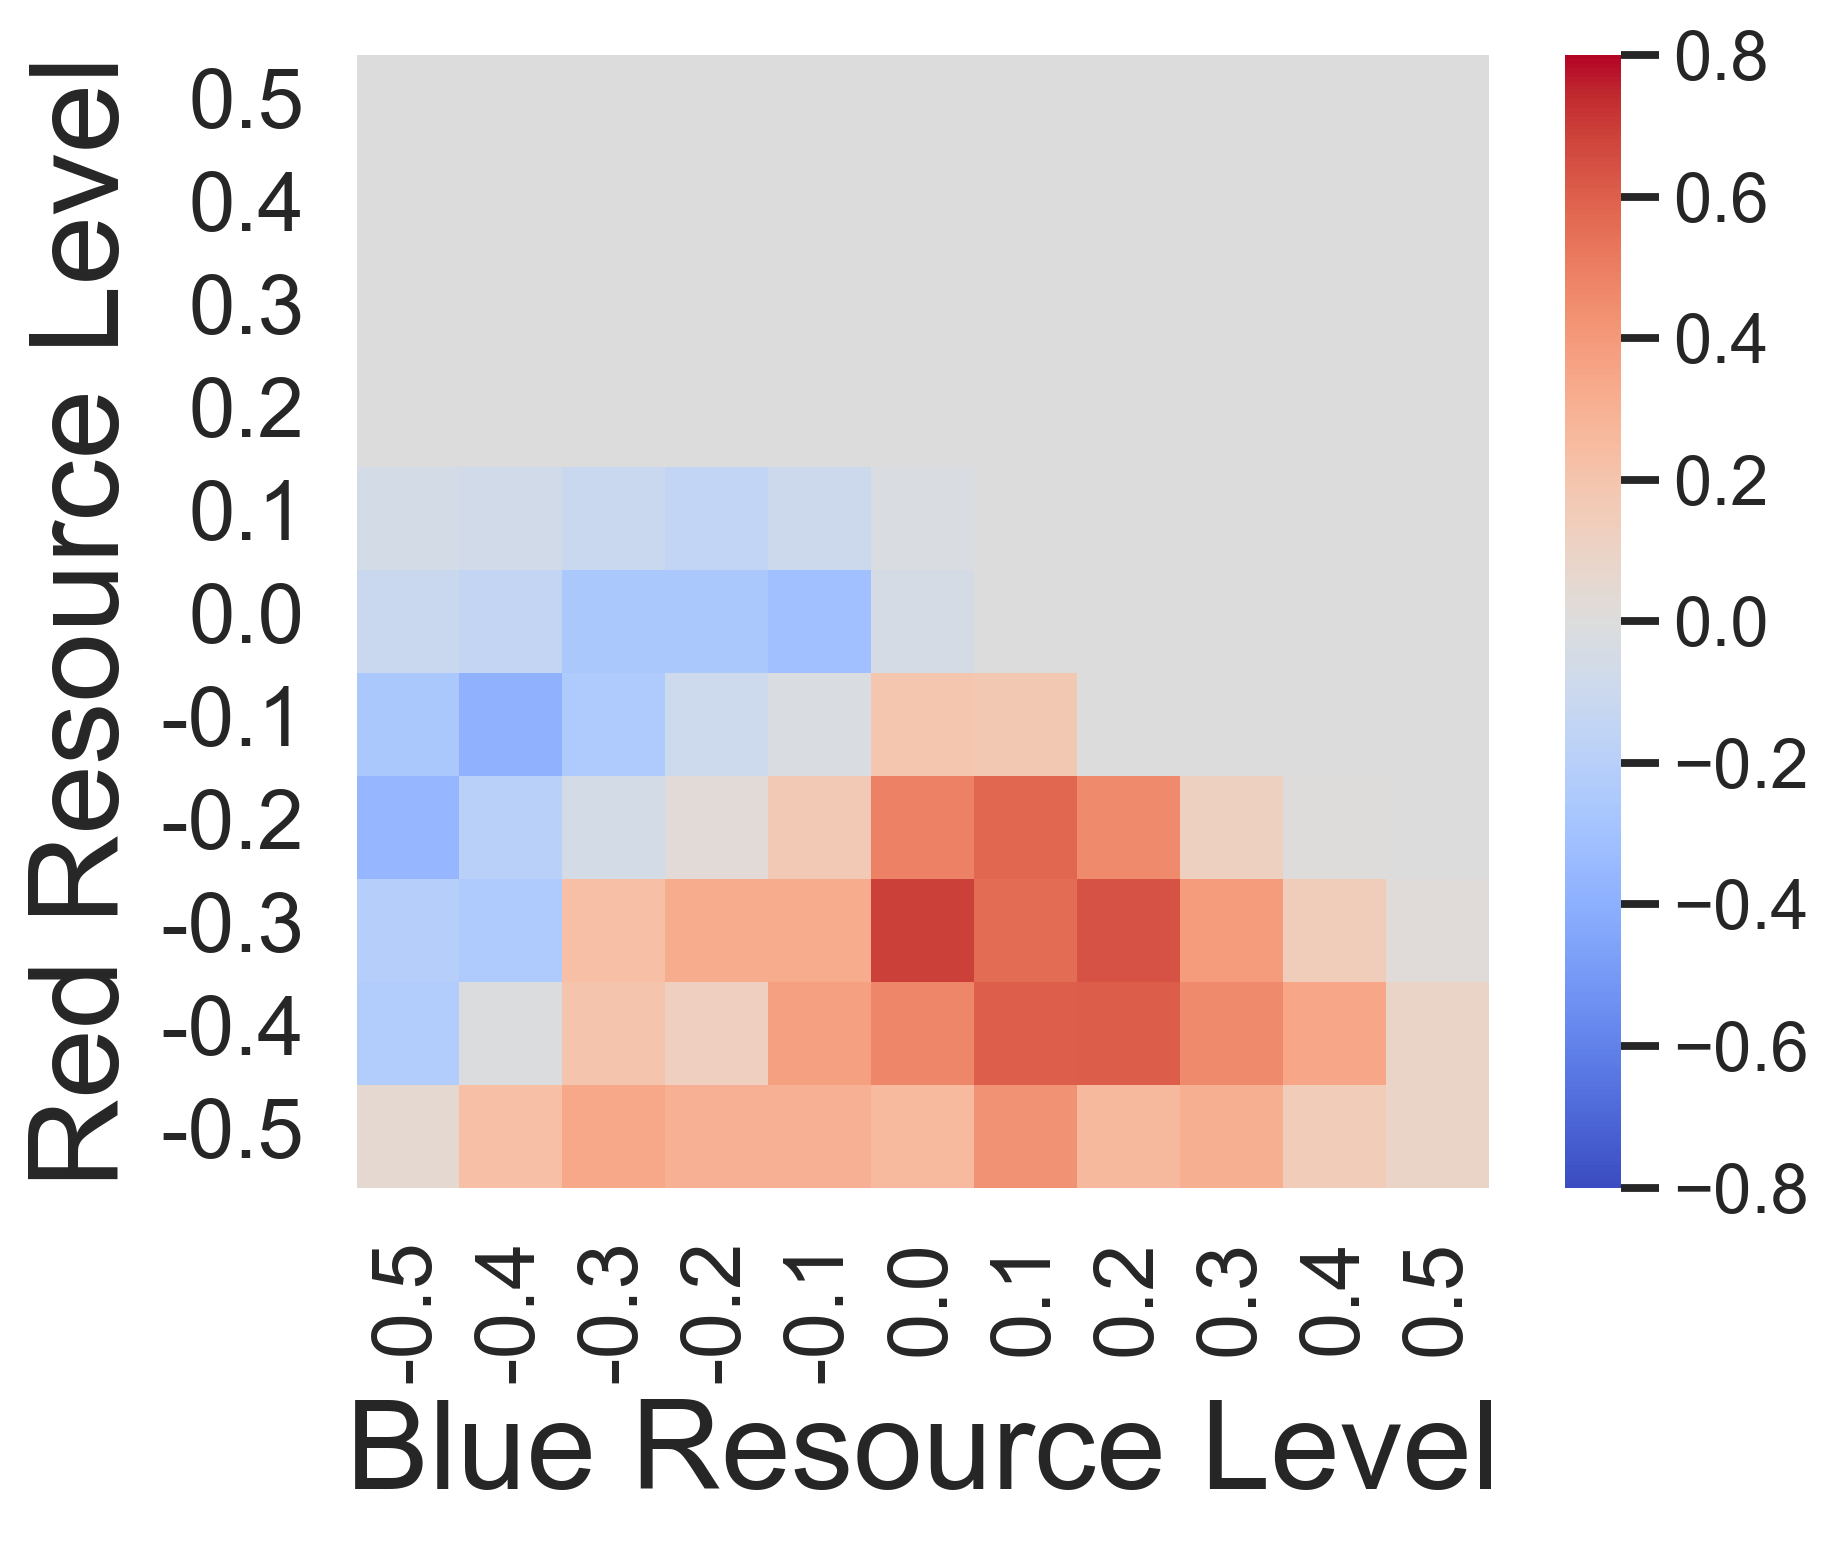

START NEW PARAM: data/trp8x2-homeostatic_shaped2021-12-13-20-03-09/150000000_finish/
2/5 - internal @ 1/121: (blue, red) = (-0.5, -0.5) [RESULT: blue/red: 0.0/0.0] 
2/5 - internal @ 2/121: (blue, red) = (-0.5, -0.4) [RESULT: blue/red: 0.0/0.0] 
2/5 - internal @ 3/121: (blue, red) = (-0.5, -0.3) [RESULT: blue/red: 0.0/0.0] 
2/5 - internal @ 4/121: (blue, red) = (-0.5, -0.19999999999999996) [RESULT: blue/red: 0.0/0.0] 
2/5 - internal @ 5/121: (blue, red) = (-0.5, -0.09999999999999998) [RESULT: blue/red: 0.0/0.0] 
2/5 - internal @ 6/121: (blue, red) = (-0.5, 0.0) [RESULT: blue/red: 0.0/0.0] 
2/5 - internal @ 7/121: (blue, red) = (-0.5, 0.10000000000000009) [RESULT: blue/red: 0.0/0.0] 
2/5 - internal @ 8/121: (blue, red) = (-0.5, 0.20000000000000007) [RESULT: blue/red: 0.0/0.0] 
2/5 - internal @ 9/121: (blue, red) = (-0.5, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 
2/5 - internal @ 10/121: (blue, red) = (-0.5, 0.4) [RESULT: blue/red: 0.0/0.0] 
2/5 - internal @ 11/121: (blue, red) = 

2/5 - internal @ 86/121: (blue, red) = (0.20000000000000007, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 
2/5 - internal @ 87/121: (blue, red) = (0.20000000000000007, 0.4) [RESULT: blue/red: 0.0/0.0] 
2/5 - internal @ 88/121: (blue, red) = (0.20000000000000007, 0.5) [RESULT: blue/red: 0.0/0.0] 
2/5 - internal @ 89/121: (blue, red) = (0.30000000000000004, -0.5) [RESULT: blue/red: 2.0/43.0] 
2/5 - internal @ 90/121: (blue, red) = (0.30000000000000004, -0.4) [RESULT: blue/red: 8.0/65.0] 
2/5 - internal @ 91/121: (blue, red) = (0.30000000000000004, -0.3) [RESULT: blue/red: 5.0/70.0] 
2/5 - internal @ 92/121: (blue, red) = (0.30000000000000004, -0.19999999999999996) [RESULT: blue/red: 1.0/39.0] 
2/5 - internal @ 93/121: (blue, red) = (0.30000000000000004, -0.09999999999999998) [RESULT: blue/red: 0.0/0.0] 
2/5 - internal @ 94/121: (blue, red) = (0.30000000000000004, 0.0) [RESULT: blue/red: 0.0/0.0] 
2/5 - internal @ 95/121: (blue, red) = (0.30000000000000004, 0.10000000000000009) [RESUL

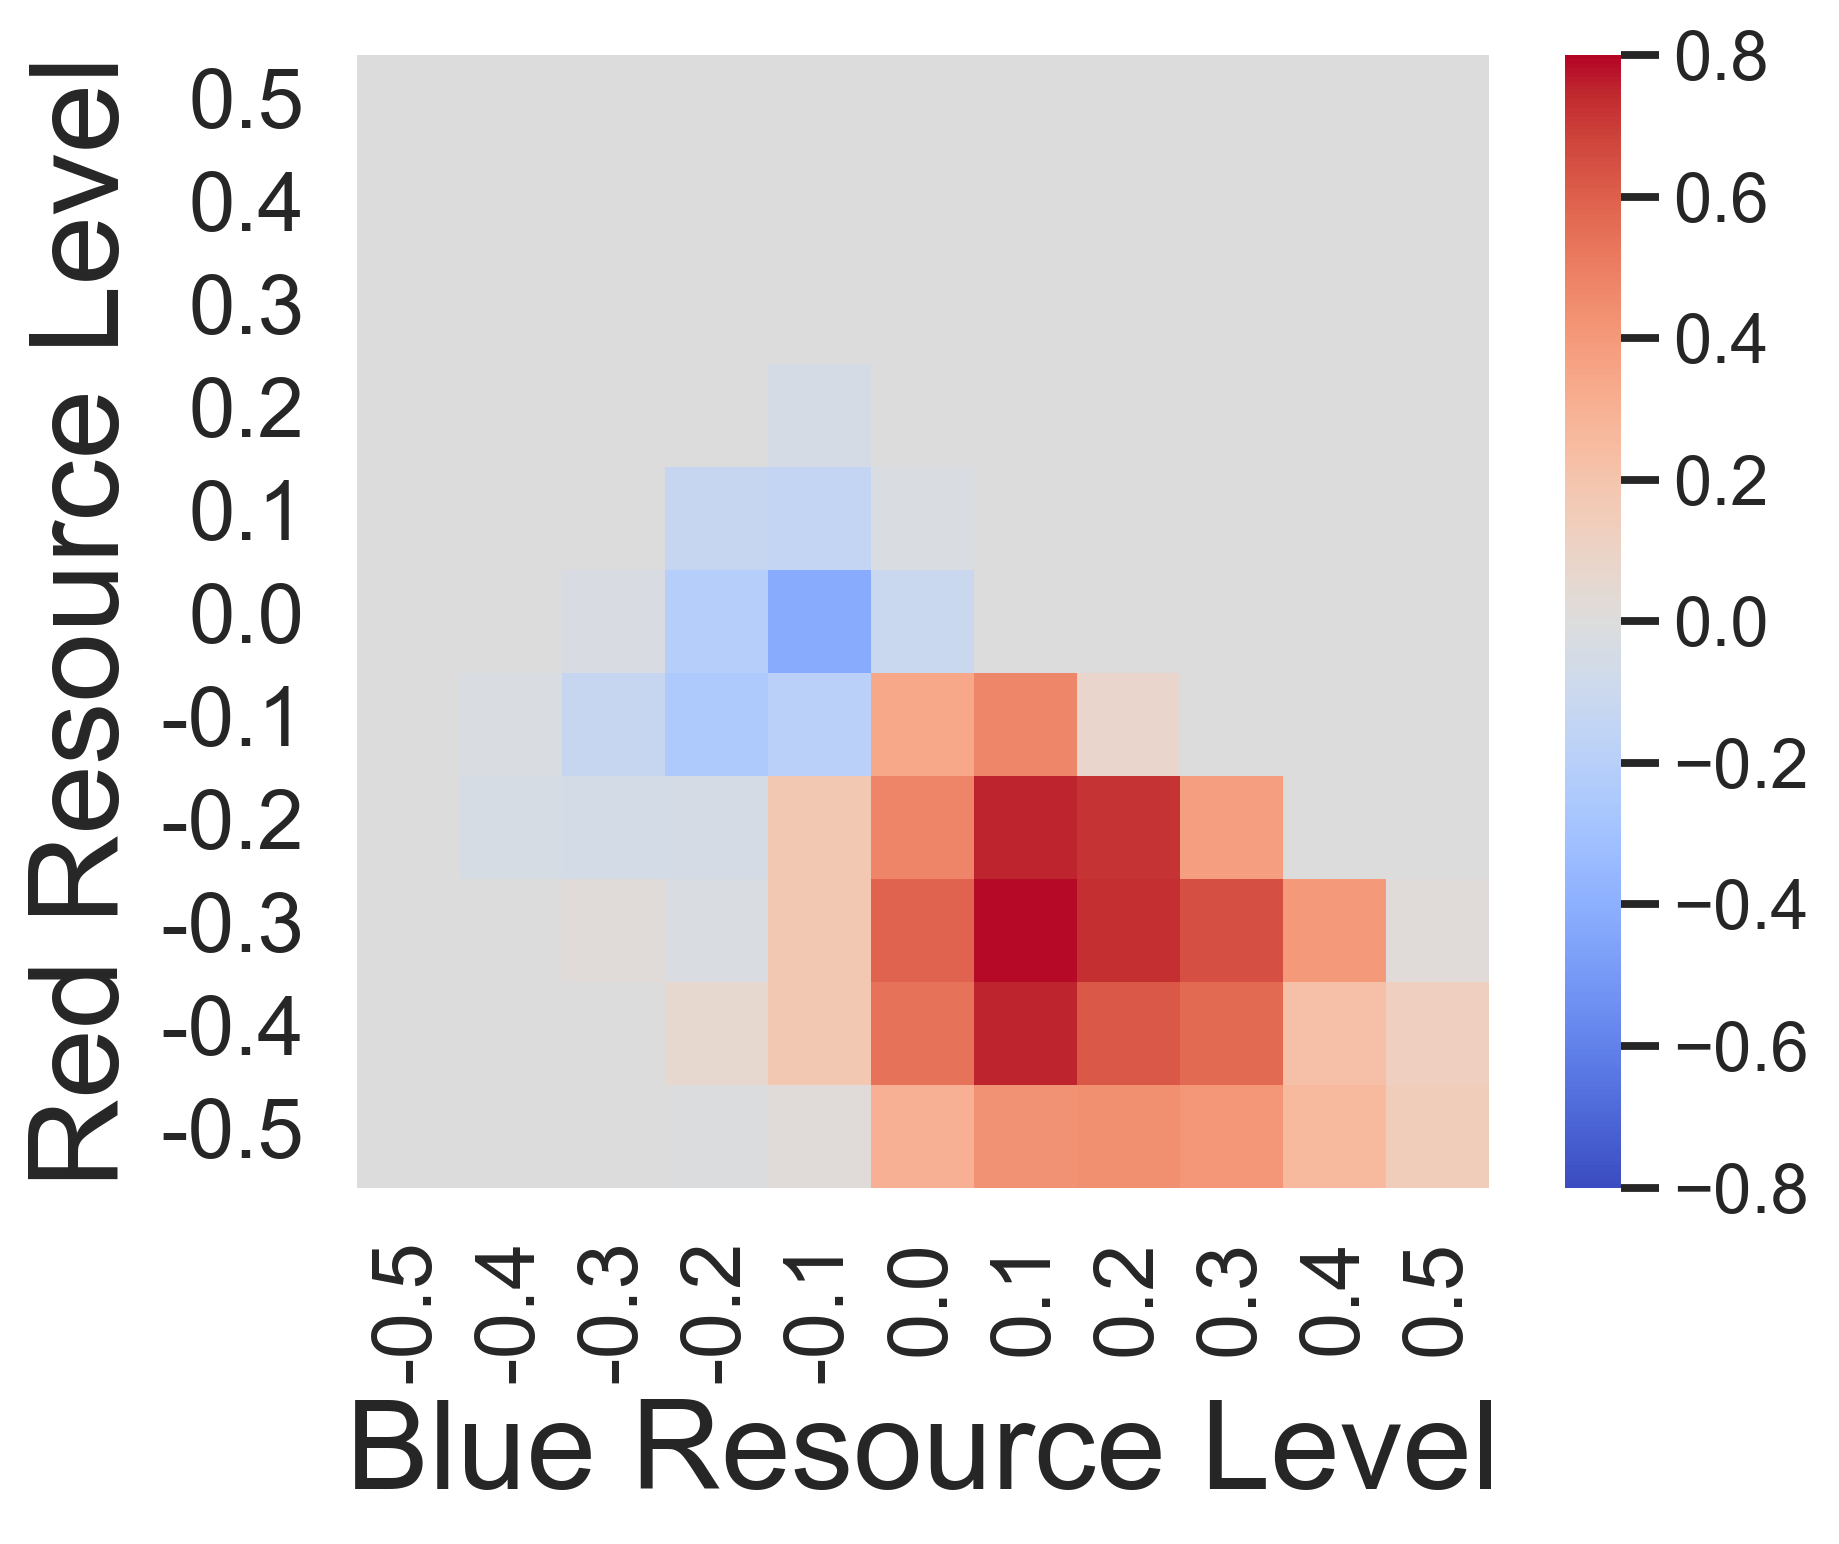

START NEW PARAM: data/trp8x2-homeostatic_shaped2021-12-13-20-05-16/150000000_finish/
3/5 - internal @ 1/121: (blue, red) = (-0.5, -0.5) [RESULT: blue/red: 0.0/0.0] 
3/5 - internal @ 2/121: (blue, red) = (-0.5, -0.4) [RESULT: blue/red: 0.0/0.0] 
3/5 - internal @ 3/121: (blue, red) = (-0.5, -0.3) [RESULT: blue/red: 0.0/0.0] 
3/5 - internal @ 4/121: (blue, red) = (-0.5, -0.19999999999999996) [RESULT: blue/red: 0.0/0.0] 
3/5 - internal @ 5/121: (blue, red) = (-0.5, -0.09999999999999998) [RESULT: blue/red: 0.0/0.0] 
3/5 - internal @ 6/121: (blue, red) = (-0.5, 0.0) [RESULT: blue/red: 2.0/2.0] 
3/5 - internal @ 7/121: (blue, red) = (-0.5, 0.10000000000000009) [RESULT: blue/red: 22.0/5.0] 
3/5 - internal @ 8/121: (blue, red) = (-0.5, 0.20000000000000007) [RESULT: blue/red: 17.0/10.0] 
3/5 - internal @ 9/121: (blue, red) = (-0.5, 0.30000000000000004) [RESULT: blue/red: 17.0/3.0] 
3/5 - internal @ 10/121: (blue, red) = (-0.5, 0.4) [RESULT: blue/red: 1.0/0.0] 
3/5 - internal @ 11/121: (blue, red

3/5 - internal @ 86/121: (blue, red) = (0.20000000000000007, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 
3/5 - internal @ 87/121: (blue, red) = (0.20000000000000007, 0.4) [RESULT: blue/red: 0.0/0.0] 
3/5 - internal @ 88/121: (blue, red) = (0.20000000000000007, 0.5) [RESULT: blue/red: 0.0/0.0] 
3/5 - internal @ 89/121: (blue, red) = (0.30000000000000004, -0.5) [RESULT: blue/red: 19.0/64.0] 
3/5 - internal @ 90/121: (blue, red) = (0.30000000000000004, -0.4) [RESULT: blue/red: 17.0/76.0] 
3/5 - internal @ 91/121: (blue, red) = (0.30000000000000004, -0.3) [RESULT: blue/red: 10.0/80.0] 
3/5 - internal @ 92/121: (blue, red) = (0.30000000000000004, -0.19999999999999996) [RESULT: blue/red: 4.0/43.0] 
3/5 - internal @ 93/121: (blue, red) = (0.30000000000000004, -0.09999999999999998) [RESULT: blue/red: 0.0/2.0] 
3/5 - internal @ 94/121: (blue, red) = (0.30000000000000004, 0.0) [RESULT: blue/red: 0.0/0.0] 
3/5 - internal @ 95/121: (blue, red) = (0.30000000000000004, 0.10000000000000009) [RE

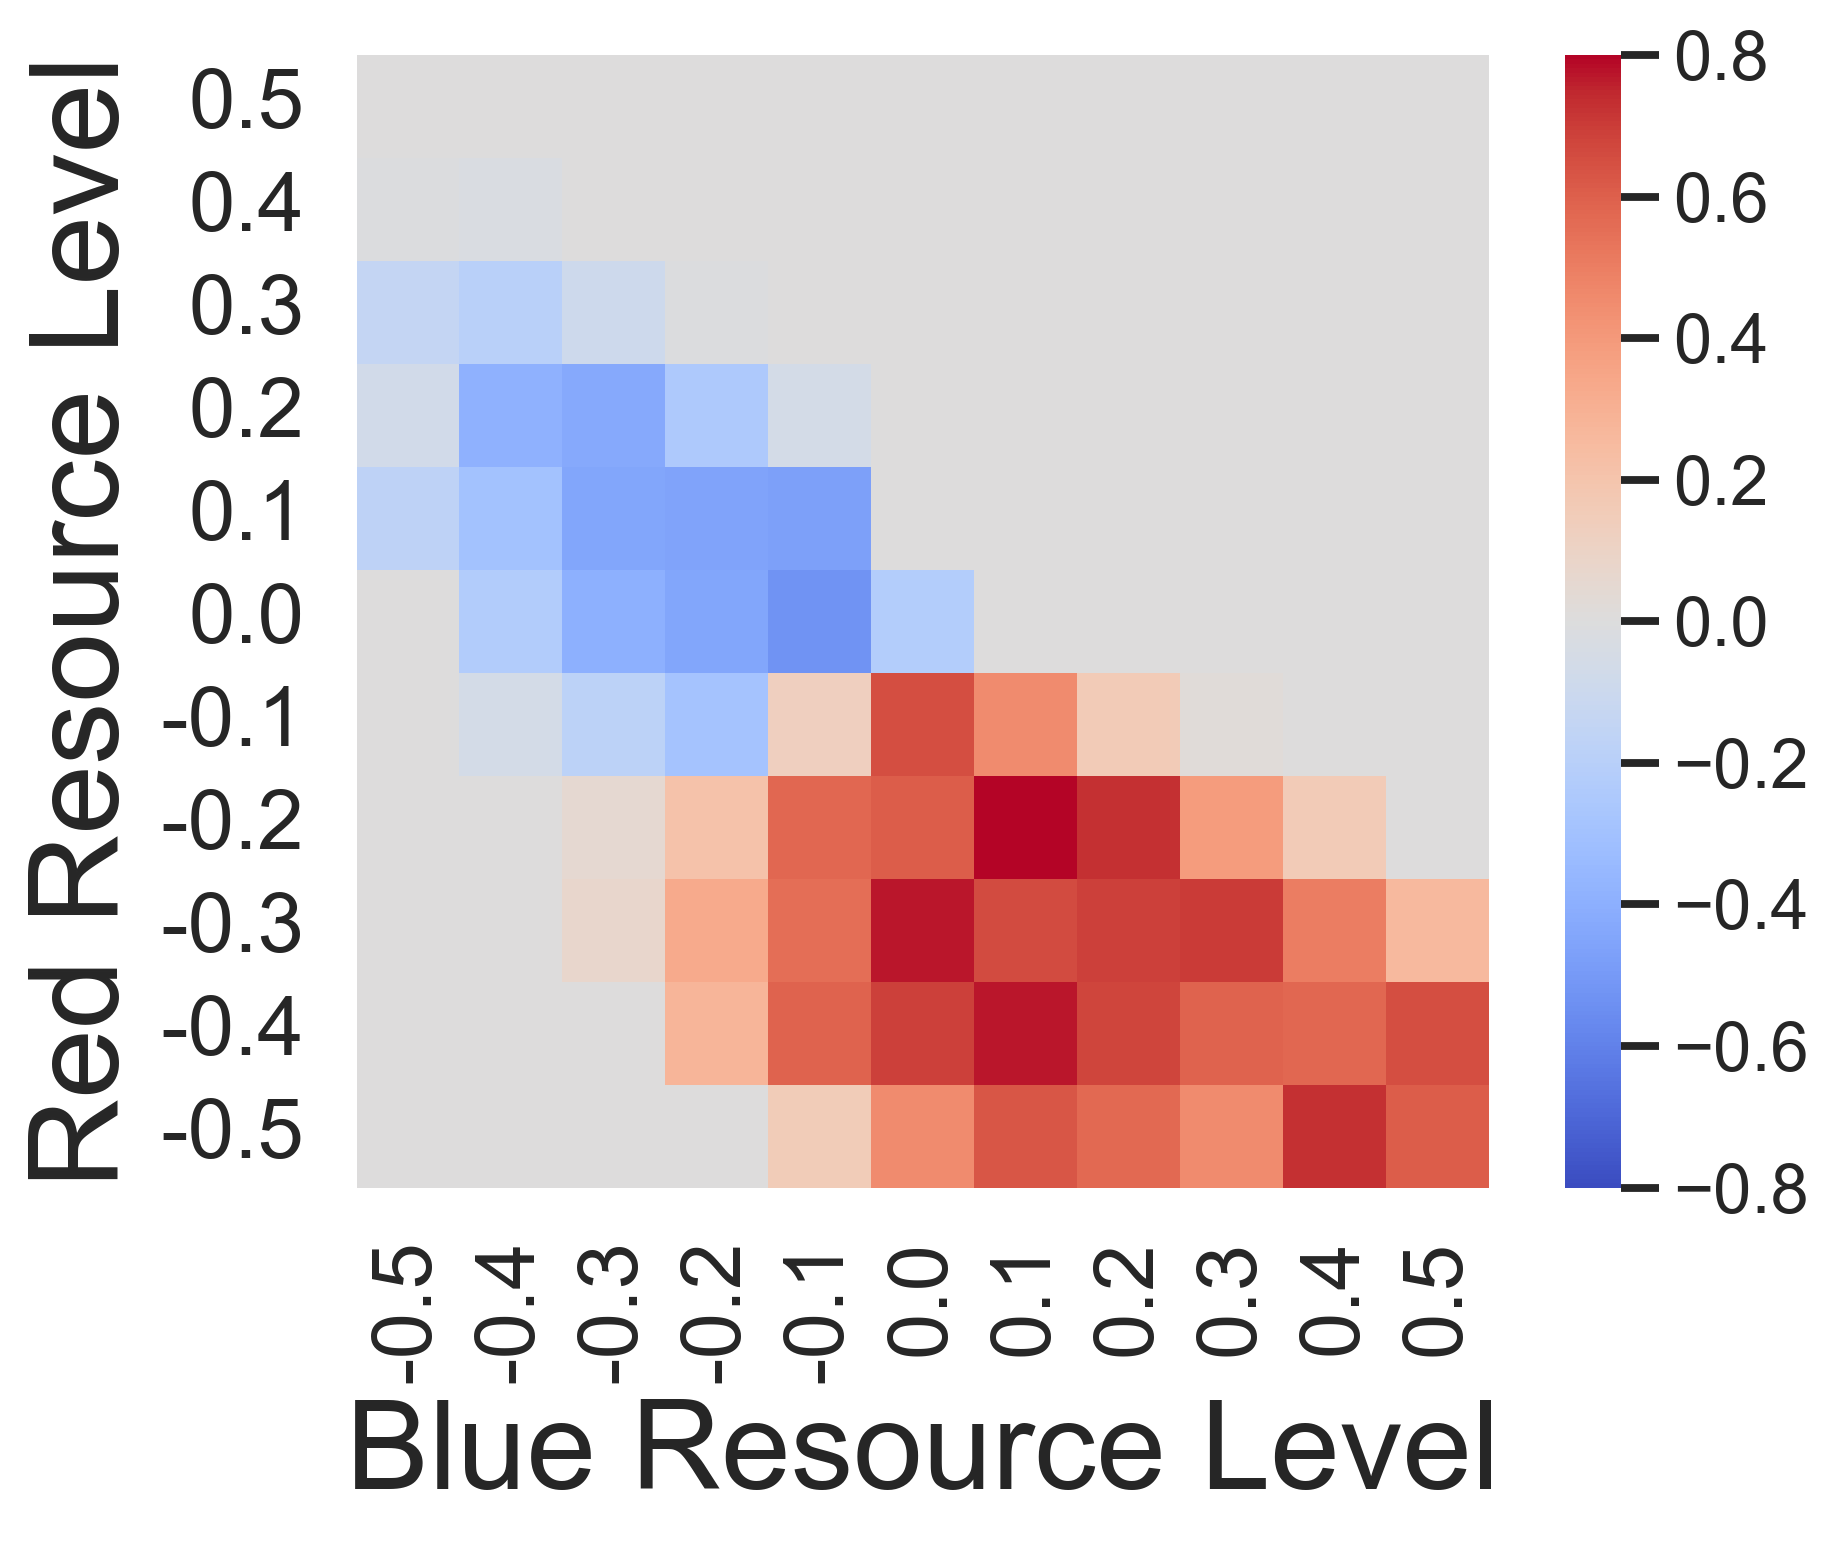

START NEW PARAM: data/trp8x2-homeostatic_shaped2021-12-13-20-06-40/150000000_finish/
4/5 - internal @ 1/121: (blue, red) = (-0.5, -0.5) [RESULT: blue/red: 2.0/6.0] 
4/5 - internal @ 2/121: (blue, red) = (-0.5, -0.4) [RESULT: blue/red: 18.0/18.0] 
4/5 - internal @ 3/121: (blue, red) = (-0.5, -0.3) [RESULT: blue/red: 32.0/26.0] 
4/5 - internal @ 4/121: (blue, red) = (-0.5, -0.19999999999999996) [RESULT: blue/red: 34.0/24.0] 
4/5 - internal @ 5/121: (blue, red) = (-0.5, -0.09999999999999998) [RESULT: blue/red: 35.0/22.0] 
4/5 - internal @ 6/121: (blue, red) = (-0.5, 0.0) [RESULT: blue/red: 35.0/12.0] 
4/5 - internal @ 7/121: (blue, red) = (-0.5, 0.10000000000000009) [RESULT: blue/red: 20.0/1.0] 
4/5 - internal @ 8/121: (blue, red) = (-0.5, 0.20000000000000007) [RESULT: blue/red: 2.0/0.0] 
4/5 - internal @ 9/121: (blue, red) = (-0.5, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 
4/5 - internal @ 10/121: (blue, red) = (-0.5, 0.4) [RESULT: blue/red: 0.0/0.0] 
4/5 - internal @ 11/121: (bl

4/5 - internal @ 86/121: (blue, red) = (0.20000000000000007, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 
4/5 - internal @ 87/121: (blue, red) = (0.20000000000000007, 0.4) [RESULT: blue/red: 0.0/0.0] 
4/5 - internal @ 88/121: (blue, red) = (0.20000000000000007, 0.5) [RESULT: blue/red: 0.0/0.0] 
4/5 - internal @ 89/121: (blue, red) = (0.30000000000000004, -0.5) [RESULT: blue/red: 2.0/27.0] 
4/5 - internal @ 90/121: (blue, red) = (0.30000000000000004, -0.4) [RESULT: blue/red: 2.0/53.0] 
4/5 - internal @ 91/121: (blue, red) = (0.30000000000000004, -0.3) [RESULT: blue/red: 0.0/75.0] 
4/5 - internal @ 92/121: (blue, red) = (0.30000000000000004, -0.19999999999999996) [RESULT: blue/red: 1.0/48.0] 
4/5 - internal @ 93/121: (blue, red) = (0.30000000000000004, -0.09999999999999998) [RESULT: blue/red: 0.0/3.0] 
4/5 - internal @ 94/121: (blue, red) = (0.30000000000000004, 0.0) [RESULT: blue/red: 0.0/0.0] 
4/5 - internal @ 95/121: (blue, red) = (0.30000000000000004, 0.10000000000000009) [RESUL

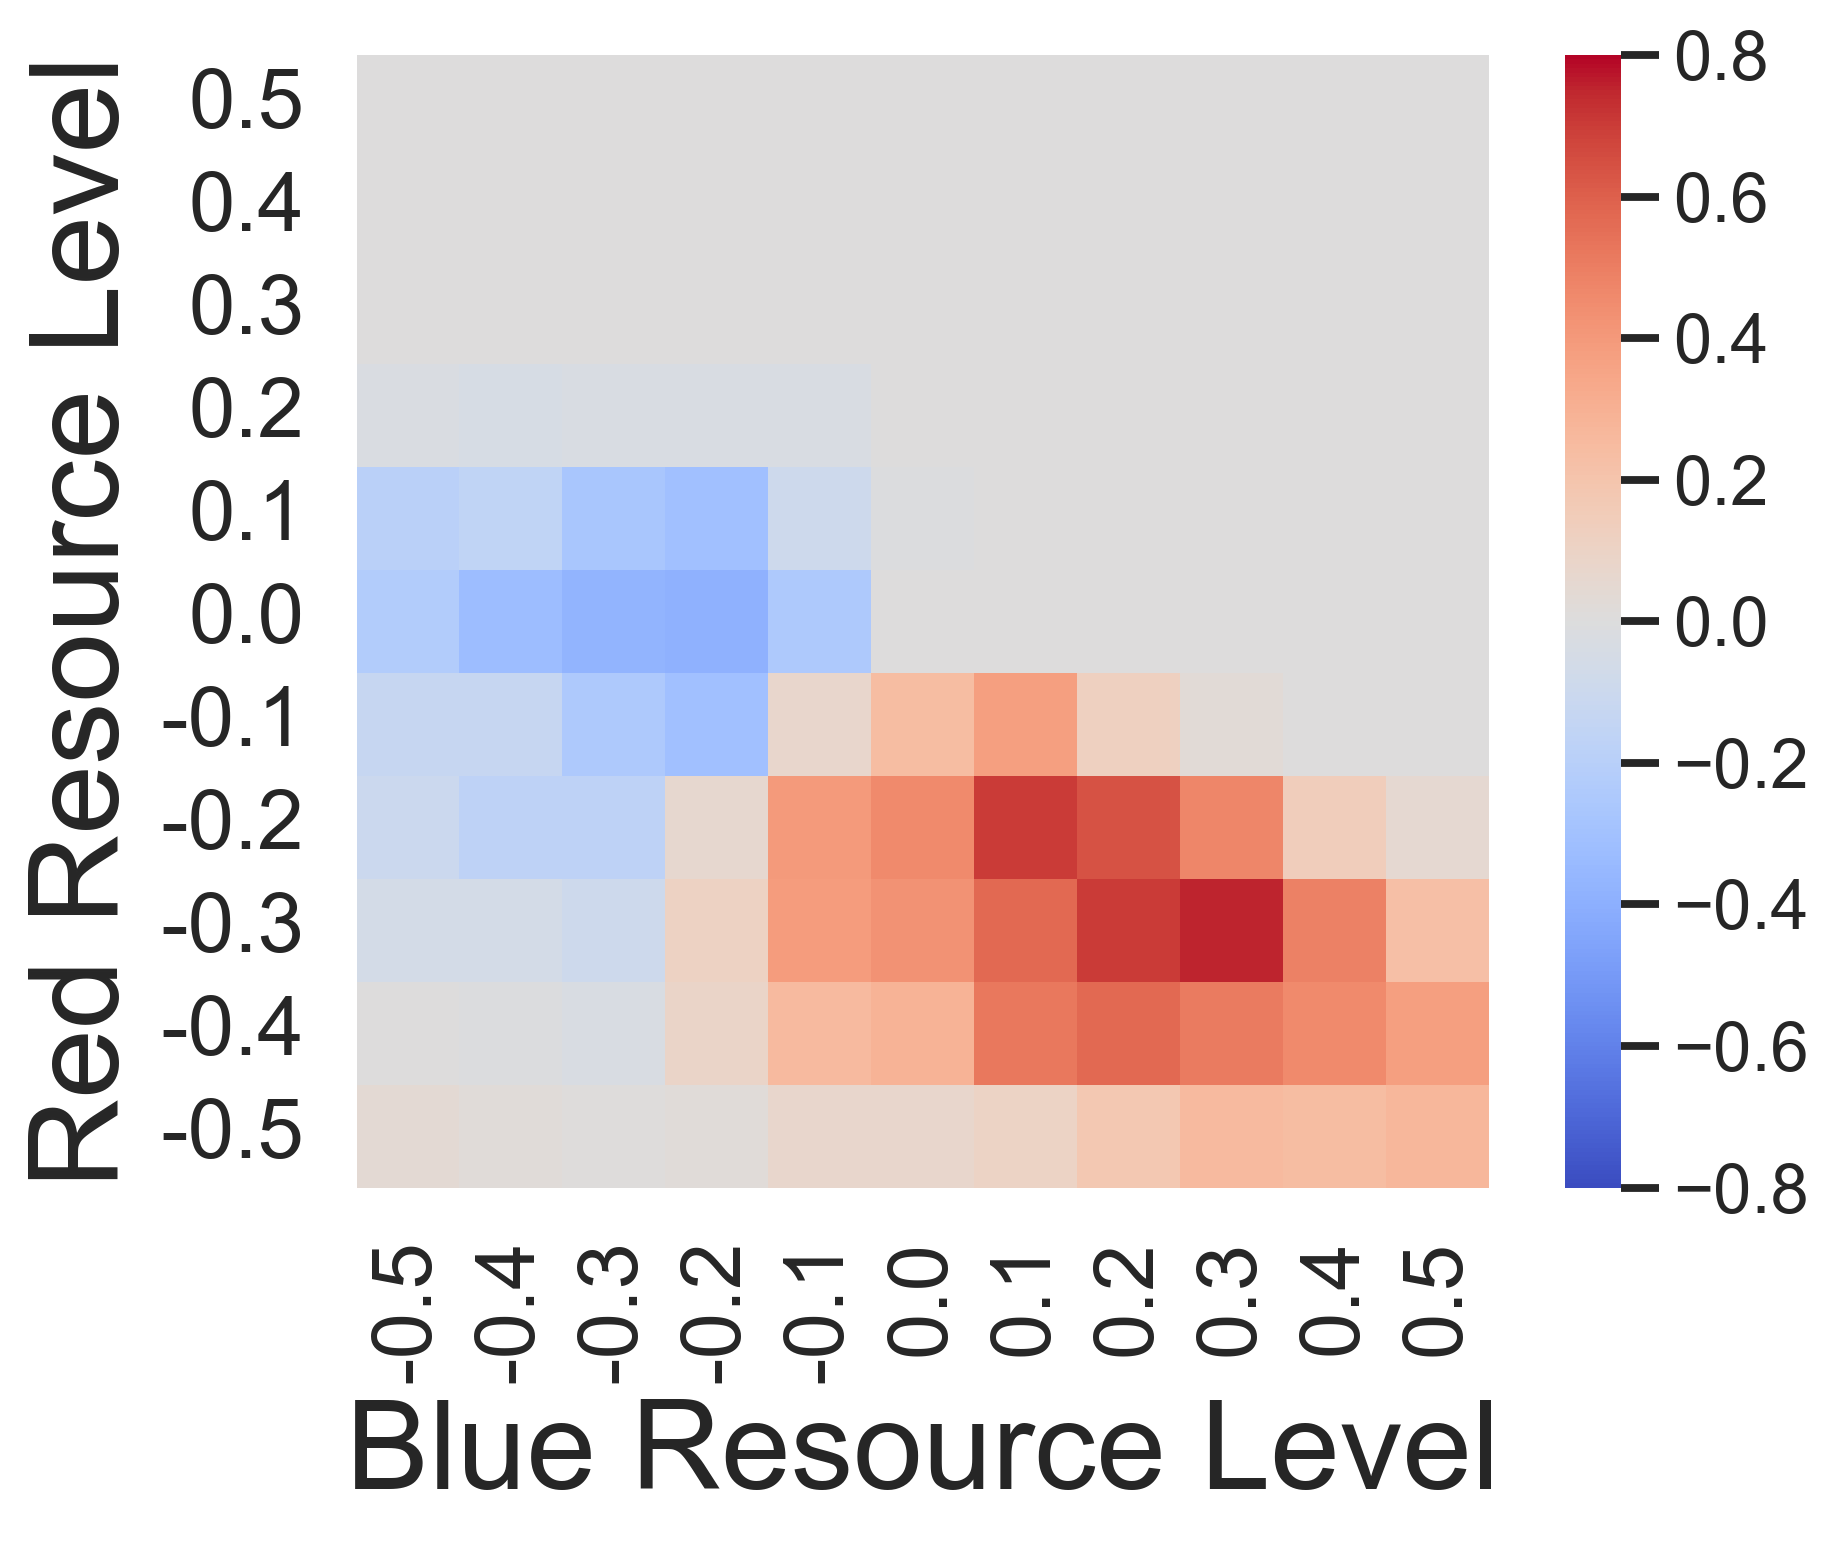

In [6]:
# paramas
param_dirs = [
    "data/trp8x2-homeostatic_shaped2021-12-09-16-33-32/150000000_finish/",
    "data/trp8x2-homeostatic_shaped2021-12-09-16-37-00/150000000_finish/",
    "data/trp8x2-homeostatic_shaped2021-12-13-20-03-09/150000000_finish/",
    "data/trp8x2-homeostatic_shaped2021-12-13-20-05-16/150000000_finish/",
    "data/trp8x2-homeostatic_shaped2021-12-13-20-06-40/150000000_finish/",
]

for id_, d in enumerate(param_dirs):
    
    agent.load(d)
    
    data_red_matrix = np.zeros(shape=(NUM_TICK, NUM_TICK))
    data_blue_matrix = np.zeros(shape=(NUM_TICK, NUM_TICK))
    
    print(f"START NEW PARAM: {d}")

    for i, blue in enumerate(blue_ticks):
        for j, red in enumerate(red_ticks):

            obs = None

            for n in range(NUM_SAMPLE):
                obs = env.reset(initial_internal=(blue, red),
                                object_positions={"blue": [(RADIUS*np.cos(a), RADIUS*np.sin(a)) for a in np.random.uniform(-np.pi, np.pi, NUM_FOOD)],
                                                  "red": [(RADIUS*np.cos(a), RADIUS*np.sin(a)) for a in np.random.uniform(-np.pi, np.pi, NUM_FOOD)]})

                for _ in range(TIME_STEPS):

                    action = agent.act(obs)
                    obs, reward, done, info = env.step(action)
                    #env.render()

                    if done:
                        if info.get("food_type") == FoodClass.RED:
                            data_red_matrix[i, j] += 1
                        elif info.get("food_type") == FoodClass.BLUE:
                            data_blue_matrix[i, j] += 1
                        break

            print(f"{id_}/{len(param_dirs)} - internal @ {i*NUM_TICK + (j + 1)}/{NUM_TICK**2}: (blue, red) = ({blue}, {red}) [RESULT: blue/red: {data_blue_matrix[i, j]}/{data_red_matrix[i, j]}] ")


    data_red_matrix /= NUM_SAMPLE
    data_blue_matrix /= NUM_SAMPLE
    
    # plot
    plt.figure(figsize=(6.5, 5), dpi=300)
    ax = sns.heatmap((data_red_matrix - data_blue_matrix).transpose(),
                     cmap='coolwarm',
                     center=0,
                     vmin=-0.8,
                     vmax=0.8,
                     square=True,
                     xticklabels=blue_ticks.round(2),
                     yticklabels=red_ticks.round(2))
    ax.invert_yaxis()
    ax.set_ylabel("Red Resource Level", fontsize=30)
    ax.set_xlabel("Blue Resource Level", fontsize=30)
    plt.tick_params(labelsize=20)

    plt.savefig(f"ba_ratio_8x2_{id_}.png", bbox_inches='tight')
    plt.show()

    # SAVE RESULTS
    np.save(f"data_matrices_blue_8x2_{id_}.npy", data_blue_matrix)
    np.save(f"data_matrices_red_8x2_{id_}.npy", data_red_matrix)

# 5x5 Experiment

In [55]:
#agent.load(dirname="data_analysis/trp5x5-homeostatic_shaped2021-08-20-16-49-18/150000000_finish")

# new params
#agent.load(dirname="data/result_trp_therm_oct2021/trp5x5-homeostatic_shaped2021-10-19-12-50-09/150000000_finish")
#agent.load(dirname="data/result_trp_therm_oct2021/trp5x5-homeostatic_shaped2021-10-20-23-46-39/150000000_finish")
#agent.load(dirname="data/result_trp_therm_oct2021/trp5x5-homeostatic_shaped2021-10-22-11-00-34/150000000_finish")
#agent.load(dirname="data/result_trp_therm_oct2021/trp5x5-homeostatic_shaped2021-10-24-00-08-08/150000000_finish")
agent.load(dirname="data/result_trp_therm_oct2021/trp5x5-homeostatic_shaped2021-10-25-18-32-02/150000000_finish")


data_red_matrix_5x5 = np.zeros(shape=(NUM_TICK, NUM_TICK))
data_blue_matrix_5x5 = np.zeros(shape=(NUM_TICK, NUM_TICK))

for i, blue in enumerate(blue_ticks):
    for j, red in enumerate(red_ticks):

        obs = None

        for n in tqdm(range(NUM_SAMPLE)):
            obs = env.reset(initial_internal=(blue, red),
                            object_positions={"blue": [(RADIUS*np.cos(a), RADIUS*np.sin(a)) for a in np.random.uniform(-np.pi, np.pi, NUM_FOOD)],
                                              "red": [(RADIUS*np.cos(a), RADIUS*np.sin(a)) for a in np.random.uniform(-np.pi, np.pi, NUM_FOOD)]})

            for _ in range(TIME_STEPS):

                action = agent.act(obs)
                obs, reward, done, info = env.step(action)
#                 env.render()

                if done:
                    if info.get("food_type") == FoodClass.RED:
                        data_red_matrix_5x5[i, j] += 1
                    elif info.get("food_type") == FoodClass.BLUE:
                        data_blue_matrix_5x5[i, j] += 1
                    break

        print(f"internal @ {i*NUM_TICK + (j + 1)}/{NUM_TICK**2}: (blue, red) = ({blue}, {red}) [RESULT: blue/red: {data_blue_matrix[i, j]}/{data_red_matrix[i, j]}] ")


data_red_matrix_5x5 /= NUM_SAMPLE
data_blue_matrix_5x5 /= NUM_SAMPLE

env.close()

print(data_red_matrix_5x5)
print(data_blue_matrix_5x5)

np.save("data_matrices_blue_5x5.npy", data_blue_matrix_5x5)
np.save("data_matrices_red_5x5.npy", data_red_matrix_5x5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.14it/s]


internal @ 1/121: (blue, red) = (-0.5, -0.5) [RESULT: blue/red: 0.0/0.02] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.53it/s]


internal @ 2/121: (blue, red) = (-0.5, -0.4) [RESULT: blue/red: 0.03/0.03] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.14it/s]


internal @ 3/121: (blue, red) = (-0.5, -0.3) [RESULT: blue/red: 0.1/0.16] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.27it/s]


internal @ 4/121: (blue, red) = (-0.5, -0.19999999999999996) [RESULT: blue/red: 0.21/0.48] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.37it/s]


internal @ 5/121: (blue, red) = (-0.5, -0.09999999999999998) [RESULT: blue/red: 0.51/0.37] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.10it/s]


internal @ 6/121: (blue, red) = (-0.5, 0.0) [RESULT: blue/red: 0.69/0.17] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.36it/s]


internal @ 7/121: (blue, red) = (-0.5, 0.10000000000000009) [RESULT: blue/red: 0.52/0.09] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.24it/s]


internal @ 8/121: (blue, red) = (-0.5, 0.20000000000000007) [RESULT: blue/red: 0.33/0.02] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


internal @ 9/121: (blue, red) = (-0.5, 0.30000000000000004) [RESULT: blue/red: 0.02/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.23it/s]


internal @ 10/121: (blue, red) = (-0.5, 0.4) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.22it/s]


internal @ 11/121: (blue, red) = (-0.5, 0.5) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.67it/s]


internal @ 12/121: (blue, red) = (-0.4, -0.5) [RESULT: blue/red: 0.0/0.03] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.01it/s]


internal @ 13/121: (blue, red) = (-0.4, -0.4) [RESULT: blue/red: 0.0/0.08] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.18it/s]


internal @ 14/121: (blue, red) = (-0.4, -0.3) [RESULT: blue/red: 0.02/0.3] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.74it/s]


internal @ 15/121: (blue, red) = (-0.4, -0.19999999999999996) [RESULT: blue/red: 0.2/0.63] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.86it/s]


internal @ 16/121: (blue, red) = (-0.4, -0.09999999999999998) [RESULT: blue/red: 0.5/0.35] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.85it/s]


internal @ 17/121: (blue, red) = (-0.4, 0.0) [RESULT: blue/red: 0.67/0.21] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s]


internal @ 18/121: (blue, red) = (-0.4, 0.10000000000000009) [RESULT: blue/red: 0.54/0.09] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.52it/s]


internal @ 19/121: (blue, red) = (-0.4, 0.20000000000000007) [RESULT: blue/red: 0.37/0.01] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.40it/s]


internal @ 20/121: (blue, red) = (-0.4, 0.30000000000000004) [RESULT: blue/red: 0.06/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]


internal @ 21/121: (blue, red) = (-0.4, 0.4) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.92it/s]


internal @ 22/121: (blue, red) = (-0.4, 0.5) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.56it/s]


internal @ 23/121: (blue, red) = (-0.3, -0.5) [RESULT: blue/red: 0.01/0.03] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.80it/s]


internal @ 24/121: (blue, red) = (-0.3, -0.4) [RESULT: blue/red: 0.06/0.19] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.10it/s]


internal @ 25/121: (blue, red) = (-0.3, -0.3) [RESULT: blue/red: 0.14/0.49] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]


internal @ 26/121: (blue, red) = (-0.3, -0.19999999999999996) [RESULT: blue/red: 0.19/0.73] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.80it/s]


internal @ 27/121: (blue, red) = (-0.3, -0.09999999999999998) [RESULT: blue/red: 0.51/0.38] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.90it/s]


internal @ 28/121: (blue, red) = (-0.3, 0.0) [RESULT: blue/red: 0.73/0.13] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.71it/s]


internal @ 29/121: (blue, red) = (-0.3, 0.10000000000000009) [RESULT: blue/red: 0.62/0.04] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


internal @ 30/121: (blue, red) = (-0.3, 0.20000000000000007) [RESULT: blue/red: 0.25/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


internal @ 31/121: (blue, red) = (-0.3, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


internal @ 32/121: (blue, red) = (-0.3, 0.4) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.16it/s]


internal @ 33/121: (blue, red) = (-0.3, 0.5) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.12it/s]


internal @ 34/121: (blue, red) = (-0.19999999999999996, -0.5) [RESULT: blue/red: 0.02/0.17] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.82it/s]


internal @ 35/121: (blue, red) = (-0.19999999999999996, -0.4) [RESULT: blue/red: 0.0/0.4] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.19it/s]


internal @ 36/121: (blue, red) = (-0.19999999999999996, -0.3) [RESULT: blue/red: 0.13/0.67] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.88it/s]


internal @ 37/121: (blue, red) = (-0.19999999999999996, -0.19999999999999996) [RESULT: blue/red: 0.14/0.73] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.55it/s]


internal @ 38/121: (blue, red) = (-0.19999999999999996, -0.09999999999999998) [RESULT: blue/red: 0.51/0.48] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.14it/s]


internal @ 39/121: (blue, red) = (-0.19999999999999996, 0.0) [RESULT: blue/red: 0.72/0.16] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.79it/s]


internal @ 40/121: (blue, red) = (-0.19999999999999996, 0.10000000000000009) [RESULT: blue/red: 0.48/0.05] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.50it/s]


internal @ 41/121: (blue, red) = (-0.19999999999999996, 0.20000000000000007) [RESULT: blue/red: 0.13/0.01] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.41it/s]


internal @ 42/121: (blue, red) = (-0.19999999999999996, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


internal @ 43/121: (blue, red) = (-0.19999999999999996, 0.4) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.21it/s]


internal @ 44/121: (blue, red) = (-0.19999999999999996, 0.5) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.84it/s]


internal @ 45/121: (blue, red) = (-0.09999999999999998, -0.5) [RESULT: blue/red: 0.0/0.22] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.53it/s]


internal @ 46/121: (blue, red) = (-0.09999999999999998, -0.4) [RESULT: blue/red: 0.09/0.52] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s]


internal @ 47/121: (blue, red) = (-0.09999999999999998, -0.3) [RESULT: blue/red: 0.07/0.72] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s]


internal @ 48/121: (blue, red) = (-0.09999999999999998, -0.19999999999999996) [RESULT: blue/red: 0.15/0.74] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]


internal @ 49/121: (blue, red) = (-0.09999999999999998, -0.09999999999999998) [RESULT: blue/red: 0.41/0.58] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.65it/s]


internal @ 50/121: (blue, red) = (-0.09999999999999998, 0.0) [RESULT: blue/red: 0.63/0.16] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.19it/s]


internal @ 51/121: (blue, red) = (-0.09999999999999998, 0.10000000000000009) [RESULT: blue/red: 0.33/0.02] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


internal @ 52/121: (blue, red) = (-0.09999999999999998, 0.20000000000000007) [RESULT: blue/red: 0.04/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.22it/s]


internal @ 53/121: (blue, red) = (-0.09999999999999998, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.16it/s]


internal @ 54/121: (blue, red) = (-0.09999999999999998, 0.4) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.18it/s]


internal @ 55/121: (blue, red) = (-0.09999999999999998, 0.5) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


internal @ 56/121: (blue, red) = (0.0, -0.5) [RESULT: blue/red: 0.01/0.25] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]


internal @ 57/121: (blue, red) = (0.0, -0.4) [RESULT: blue/red: 0.04/0.5] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.43it/s]


internal @ 58/121: (blue, red) = (0.0, -0.3) [RESULT: blue/red: 0.05/0.76] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.21it/s]


internal @ 59/121: (blue, red) = (0.0, -0.19999999999999996) [RESULT: blue/red: 0.13/0.77] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.47it/s]


internal @ 60/121: (blue, red) = (0.0, -0.09999999999999998) [RESULT: blue/red: 0.08/0.75] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.16it/s]


internal @ 61/121: (blue, red) = (0.0, 0.0) [RESULT: blue/red: 0.01/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.18it/s]


internal @ 62/121: (blue, red) = (0.0, 0.10000000000000009) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.03it/s]


internal @ 63/121: (blue, red) = (0.0, 0.20000000000000007) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


internal @ 64/121: (blue, red) = (0.0, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.03it/s]


internal @ 65/121: (blue, red) = (0.0, 0.4) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.10it/s]


internal @ 66/121: (blue, red) = (0.0, 0.5) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.33it/s]


internal @ 67/121: (blue, red) = (0.10000000000000009, -0.5) [RESULT: blue/red: 0.02/0.24] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.54it/s]


internal @ 68/121: (blue, red) = (0.10000000000000009, -0.4) [RESULT: blue/red: 0.05/0.55] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.99it/s]


internal @ 69/121: (blue, red) = (0.10000000000000009, -0.3) [RESULT: blue/red: 0.05/0.8] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.55it/s]


internal @ 70/121: (blue, red) = (0.10000000000000009, -0.19999999999999996) [RESULT: blue/red: 0.09/0.8] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.49it/s]


internal @ 71/121: (blue, red) = (0.10000000000000009, -0.09999999999999998) [RESULT: blue/red: 0.04/0.46] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.10it/s]


internal @ 72/121: (blue, red) = (0.10000000000000009, 0.0) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.15it/s]


internal @ 73/121: (blue, red) = (0.10000000000000009, 0.10000000000000009) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]


internal @ 74/121: (blue, red) = (0.10000000000000009, 0.20000000000000007) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]


internal @ 75/121: (blue, red) = (0.10000000000000009, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.88it/s]


internal @ 76/121: (blue, red) = (0.10000000000000009, 0.4) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


internal @ 77/121: (blue, red) = (0.10000000000000009, 0.5) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.84it/s]


internal @ 78/121: (blue, red) = (0.20000000000000007, -0.5) [RESULT: blue/red: 0.02/0.32] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.06it/s]


internal @ 79/121: (blue, red) = (0.20000000000000007, -0.4) [RESULT: blue/red: 0.06/0.53] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.92it/s]


internal @ 80/121: (blue, red) = (0.20000000000000007, -0.3) [RESULT: blue/red: 0.03/0.7] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.69it/s]


internal @ 81/121: (blue, red) = (0.20000000000000007, -0.19999999999999996) [RESULT: blue/red: 0.03/0.8] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.35it/s]


internal @ 82/121: (blue, red) = (0.20000000000000007, -0.09999999999999998) [RESULT: blue/red: 0.0/0.06] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.00it/s]


internal @ 83/121: (blue, red) = (0.20000000000000007, 0.0) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.12it/s]


internal @ 84/121: (blue, red) = (0.20000000000000007, 0.10000000000000009) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.03it/s]


internal @ 85/121: (blue, red) = (0.20000000000000007, 0.20000000000000007) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.15it/s]


internal @ 86/121: (blue, red) = (0.20000000000000007, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.17it/s]


internal @ 87/121: (blue, red) = (0.20000000000000007, 0.4) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.13it/s]


internal @ 88/121: (blue, red) = (0.20000000000000007, 0.5) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


internal @ 89/121: (blue, red) = (0.30000000000000004, -0.5) [RESULT: blue/red: 0.02/0.24] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]


internal @ 90/121: (blue, red) = (0.30000000000000004, -0.4) [RESULT: blue/red: 0.02/0.4] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.06it/s]


internal @ 91/121: (blue, red) = (0.30000000000000004, -0.3) [RESULT: blue/red: 0.06/0.64] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.23it/s]


internal @ 92/121: (blue, red) = (0.30000000000000004, -0.19999999999999996) [RESULT: blue/red: 0.06/0.46] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


internal @ 93/121: (blue, red) = (0.30000000000000004, -0.09999999999999998) [RESULT: blue/red: 0.0/0.01] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.17it/s]


internal @ 94/121: (blue, red) = (0.30000000000000004, 0.0) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]


internal @ 95/121: (blue, red) = (0.30000000000000004, 0.10000000000000009) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.98it/s]


internal @ 96/121: (blue, red) = (0.30000000000000004, 0.20000000000000007) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


internal @ 97/121: (blue, red) = (0.30000000000000004, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


internal @ 98/121: (blue, red) = (0.30000000000000004, 0.4) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]


internal @ 99/121: (blue, red) = (0.30000000000000004, 0.5) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]


internal @ 100/121: (blue, red) = (0.4, -0.5) [RESULT: blue/red: 0.02/0.06] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.87it/s]


internal @ 101/121: (blue, red) = (0.4, -0.4) [RESULT: blue/red: 0.03/0.14] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.12it/s]


internal @ 102/121: (blue, red) = (0.4, -0.3) [RESULT: blue/red: 0.09/0.25] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.37it/s]


internal @ 103/121: (blue, red) = (0.4, -0.19999999999999996) [RESULT: blue/red: 0.03/0.13] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s]


internal @ 104/121: (blue, red) = (0.4, -0.09999999999999998) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


internal @ 105/121: (blue, red) = (0.4, 0.0) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


internal @ 106/121: (blue, red) = (0.4, 0.10000000000000009) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


internal @ 107/121: (blue, red) = (0.4, 0.20000000000000007) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.88it/s]


internal @ 108/121: (blue, red) = (0.4, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.96it/s]


internal @ 109/121: (blue, red) = (0.4, 0.4) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s]


internal @ 110/121: (blue, red) = (0.4, 0.5) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.83it/s]


internal @ 111/121: (blue, red) = (0.5, -0.5) [RESULT: blue/red: 0.0/0.01] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.77it/s]


internal @ 112/121: (blue, red) = (0.5, -0.4) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.45it/s]


internal @ 113/121: (blue, red) = (0.5, -0.3) [RESULT: blue/red: 0.06/0.09] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]


internal @ 114/121: (blue, red) = (0.5, -0.19999999999999996) [RESULT: blue/red: 0.03/0.04] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.93it/s]


internal @ 115/121: (blue, red) = (0.5, -0.09999999999999998) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.85it/s]


internal @ 116/121: (blue, red) = (0.5, 0.0) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s]


internal @ 117/121: (blue, red) = (0.5, 0.10000000000000009) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


internal @ 118/121: (blue, red) = (0.5, 0.20000000000000007) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.70it/s]


internal @ 119/121: (blue, red) = (0.5, 0.30000000000000004) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


internal @ 120/121: (blue, red) = (0.5, 0.4) [RESULT: blue/red: 0.0/0.0] 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]

internal @ 121/121: (blue, red) = (0.5, 0.5) [RESULT: blue/red: 0.0/0.0] 
[[0.12 0.21 0.2  0.1  0.09 0.02 0.01 0.   0.   0.   0.  ]
 [0.26 0.39 0.32 0.21 0.14 0.07 0.05 0.   0.   0.   0.  ]
 [0.35 0.52 0.5  0.38 0.23 0.11 0.04 0.01 0.   0.   0.  ]
 [0.4  0.55 0.7  0.61 0.39 0.19 0.08 0.   0.   0.   0.  ]
 [0.66 0.77 0.65 0.7  0.49 0.22 0.03 0.01 0.   0.   0.  ]
 [0.58 0.7  0.81 0.75 0.67 0.07 0.   0.   0.   0.   0.  ]
 [0.67 0.75 0.75 0.84 0.53 0.01 0.   0.   0.   0.   0.  ]
 [0.74 0.7  0.8  0.81 0.41 0.   0.   0.   0.   0.   0.  ]
 [0.78 0.74 0.91 0.71 0.33 0.   0.   0.   0.   0.   0.  ]
 [0.71 0.78 0.73 0.51 0.08 0.   0.   0.   0.   0.   0.  ]
 [0.69 0.7  0.5  0.14 0.01 0.   0.   0.   0.   0.   0.  ]]
[[0.17 0.26 0.21 0.17 0.31 0.21 0.34 0.14 0.07 0.02 0.01]
 [0.14 0.18 0.31 0.34 0.38 0.49 0.35 0.35 0.19 0.05 0.  ]
 [0.18 0.31 0.33 0.39 0.46 0.53 0.48 0.4  0.19 0.05 0.04]
 [0.26 0.28 0.23 0.28 0.38 0.53 0.5  0.34 0.25 0.09 0.01]
 [0.22 0.14 0.28 0.25 0.4  0.49 0.45 0.23 0.07 0.01 0. 

[i, j] = [blue_index, red_index]
blue
[[0.17 0.14 0.18 0.26 0.22 0.23 0.21 0.19 0.13 0.16 0.1 ]
 [0.26 0.18 0.31 0.28 0.14 0.17 0.15 0.2  0.18 0.13 0.11]
 [0.21 0.31 0.33 0.23 0.28 0.16 0.18 0.16 0.07 0.07 0.04]
 [0.17 0.34 0.39 0.28 0.25 0.18 0.1  0.04 0.1  0.04 0.02]
 [0.31 0.38 0.46 0.38 0.4  0.19 0.07 0.03 0.01 0.   0.  ]
 [0.21 0.49 0.53 0.53 0.49 0.12 0.   0.   0.   0.   0.  ]
 [0.34 0.35 0.48 0.5  0.45 0.03 0.   0.   0.   0.   0.  ]
 [0.14 0.35 0.4  0.34 0.23 0.01 0.   0.   0.   0.   0.  ]
 [0.07 0.19 0.19 0.25 0.07 0.   0.   0.   0.   0.   0.  ]
 [0.02 0.05 0.05 0.09 0.01 0.   0.   0.   0.   0.   0.  ]
 [0.01 0.   0.04 0.01 0.   0.   0.   0.   0.   0.   0.  ]]
red
[[0.12 0.26 0.35 0.4  0.66 0.58 0.67 0.74 0.78 0.71 0.69]
 [0.21 0.39 0.52 0.55 0.77 0.7  0.75 0.7  0.74 0.78 0.7 ]
 [0.2  0.32 0.5  0.7  0.65 0.81 0.75 0.8  0.91 0.73 0.5 ]
 [0.1  0.21 0.38 0.61 0.7  0.75 0.84 0.81 0.71 0.51 0.14]
 [0.09 0.14 0.23 0.39 0.49 0.67 0.53 0.41 0.33 0.08 0.01]
 [0.02 0.07 0.11 0.19 0.22 0.

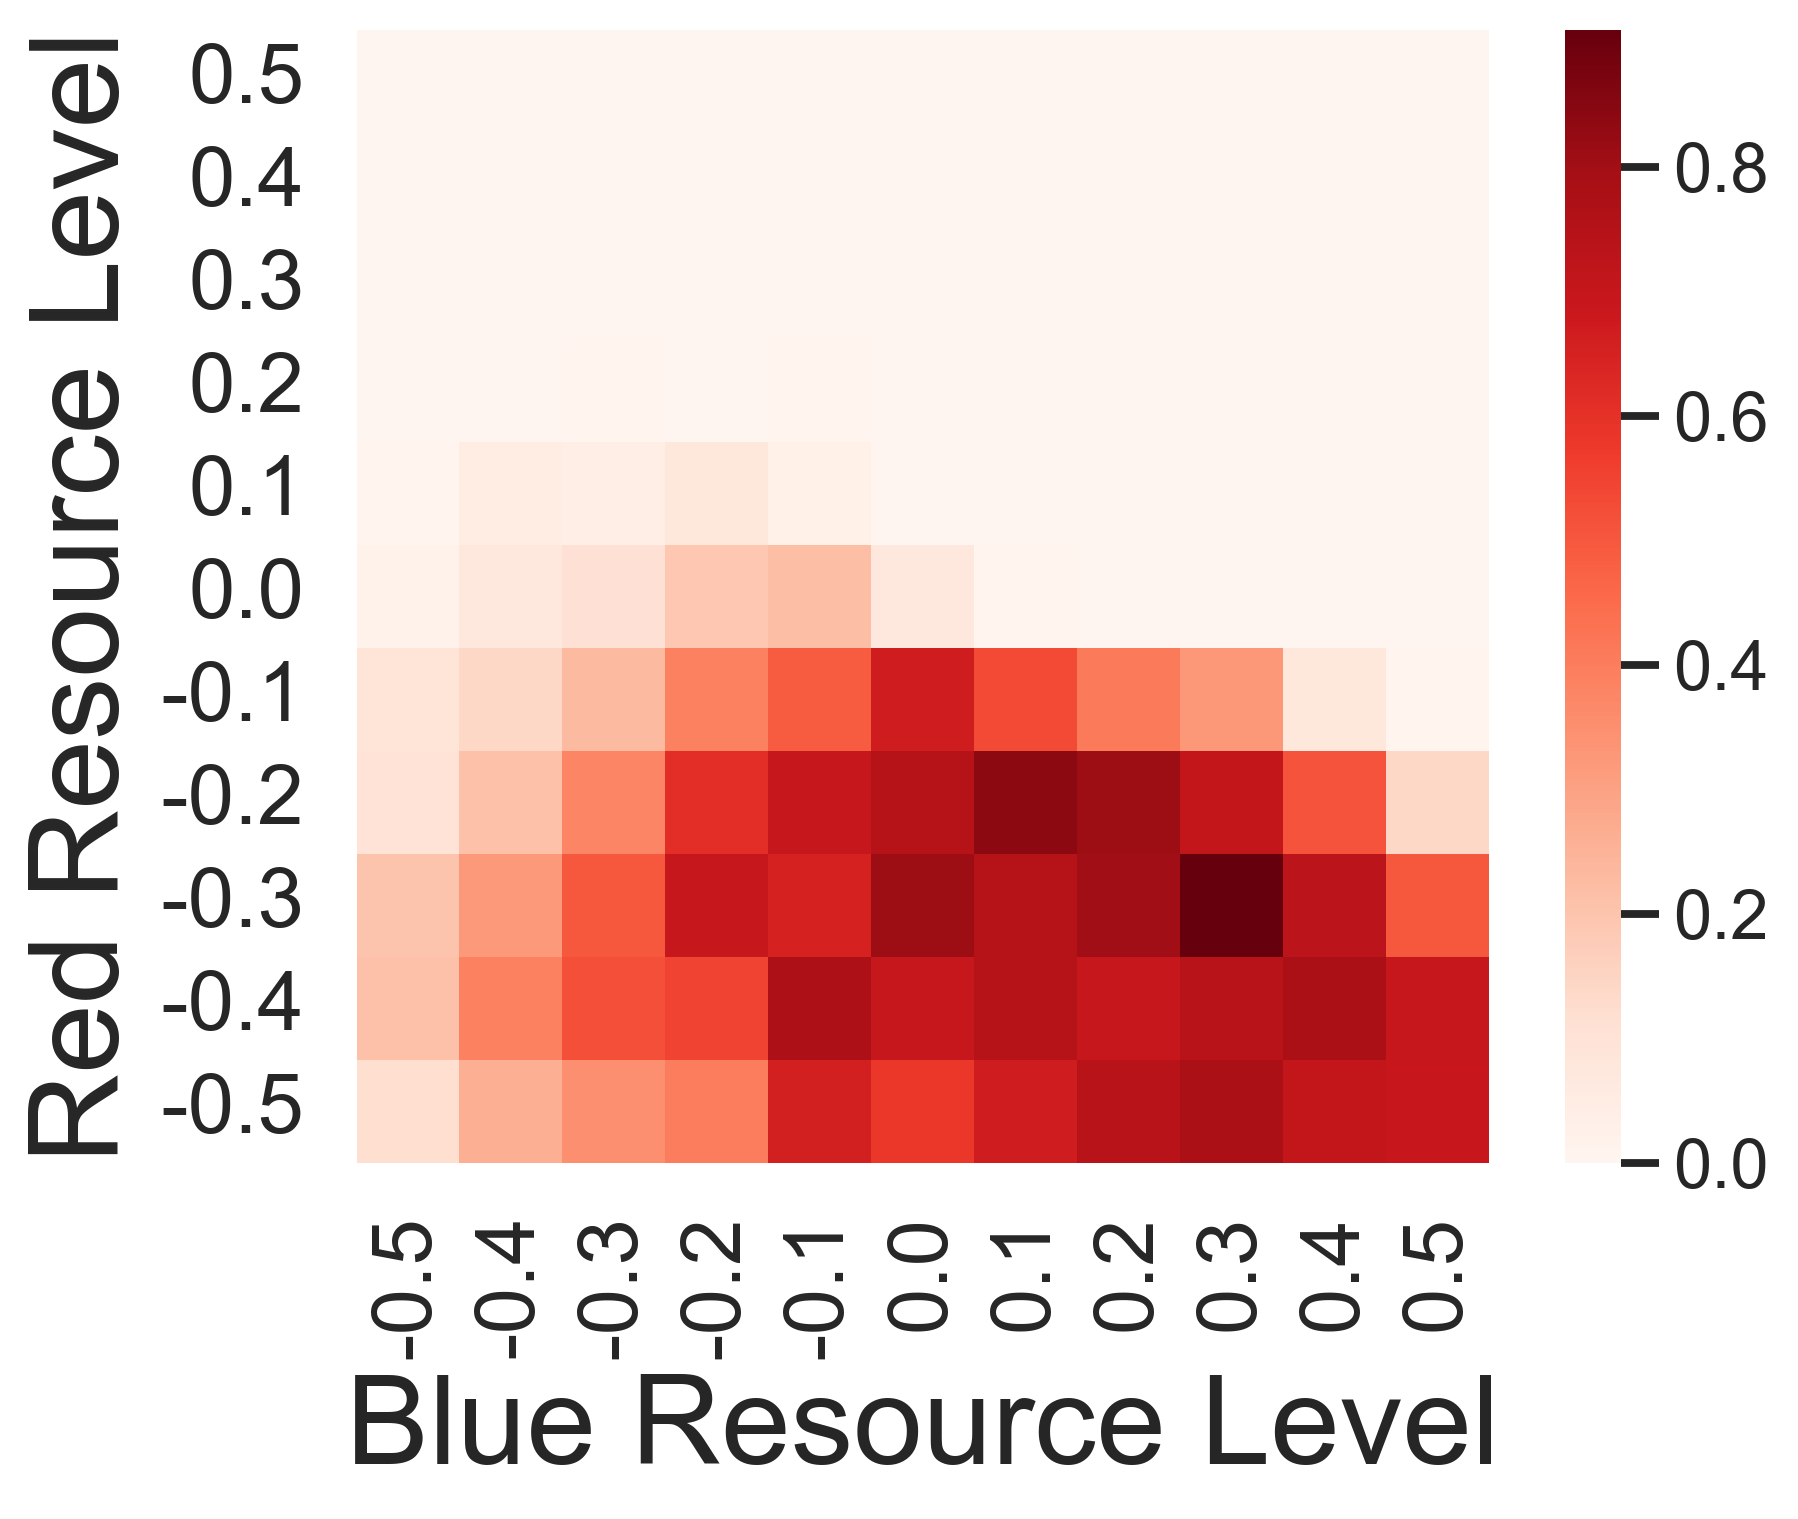

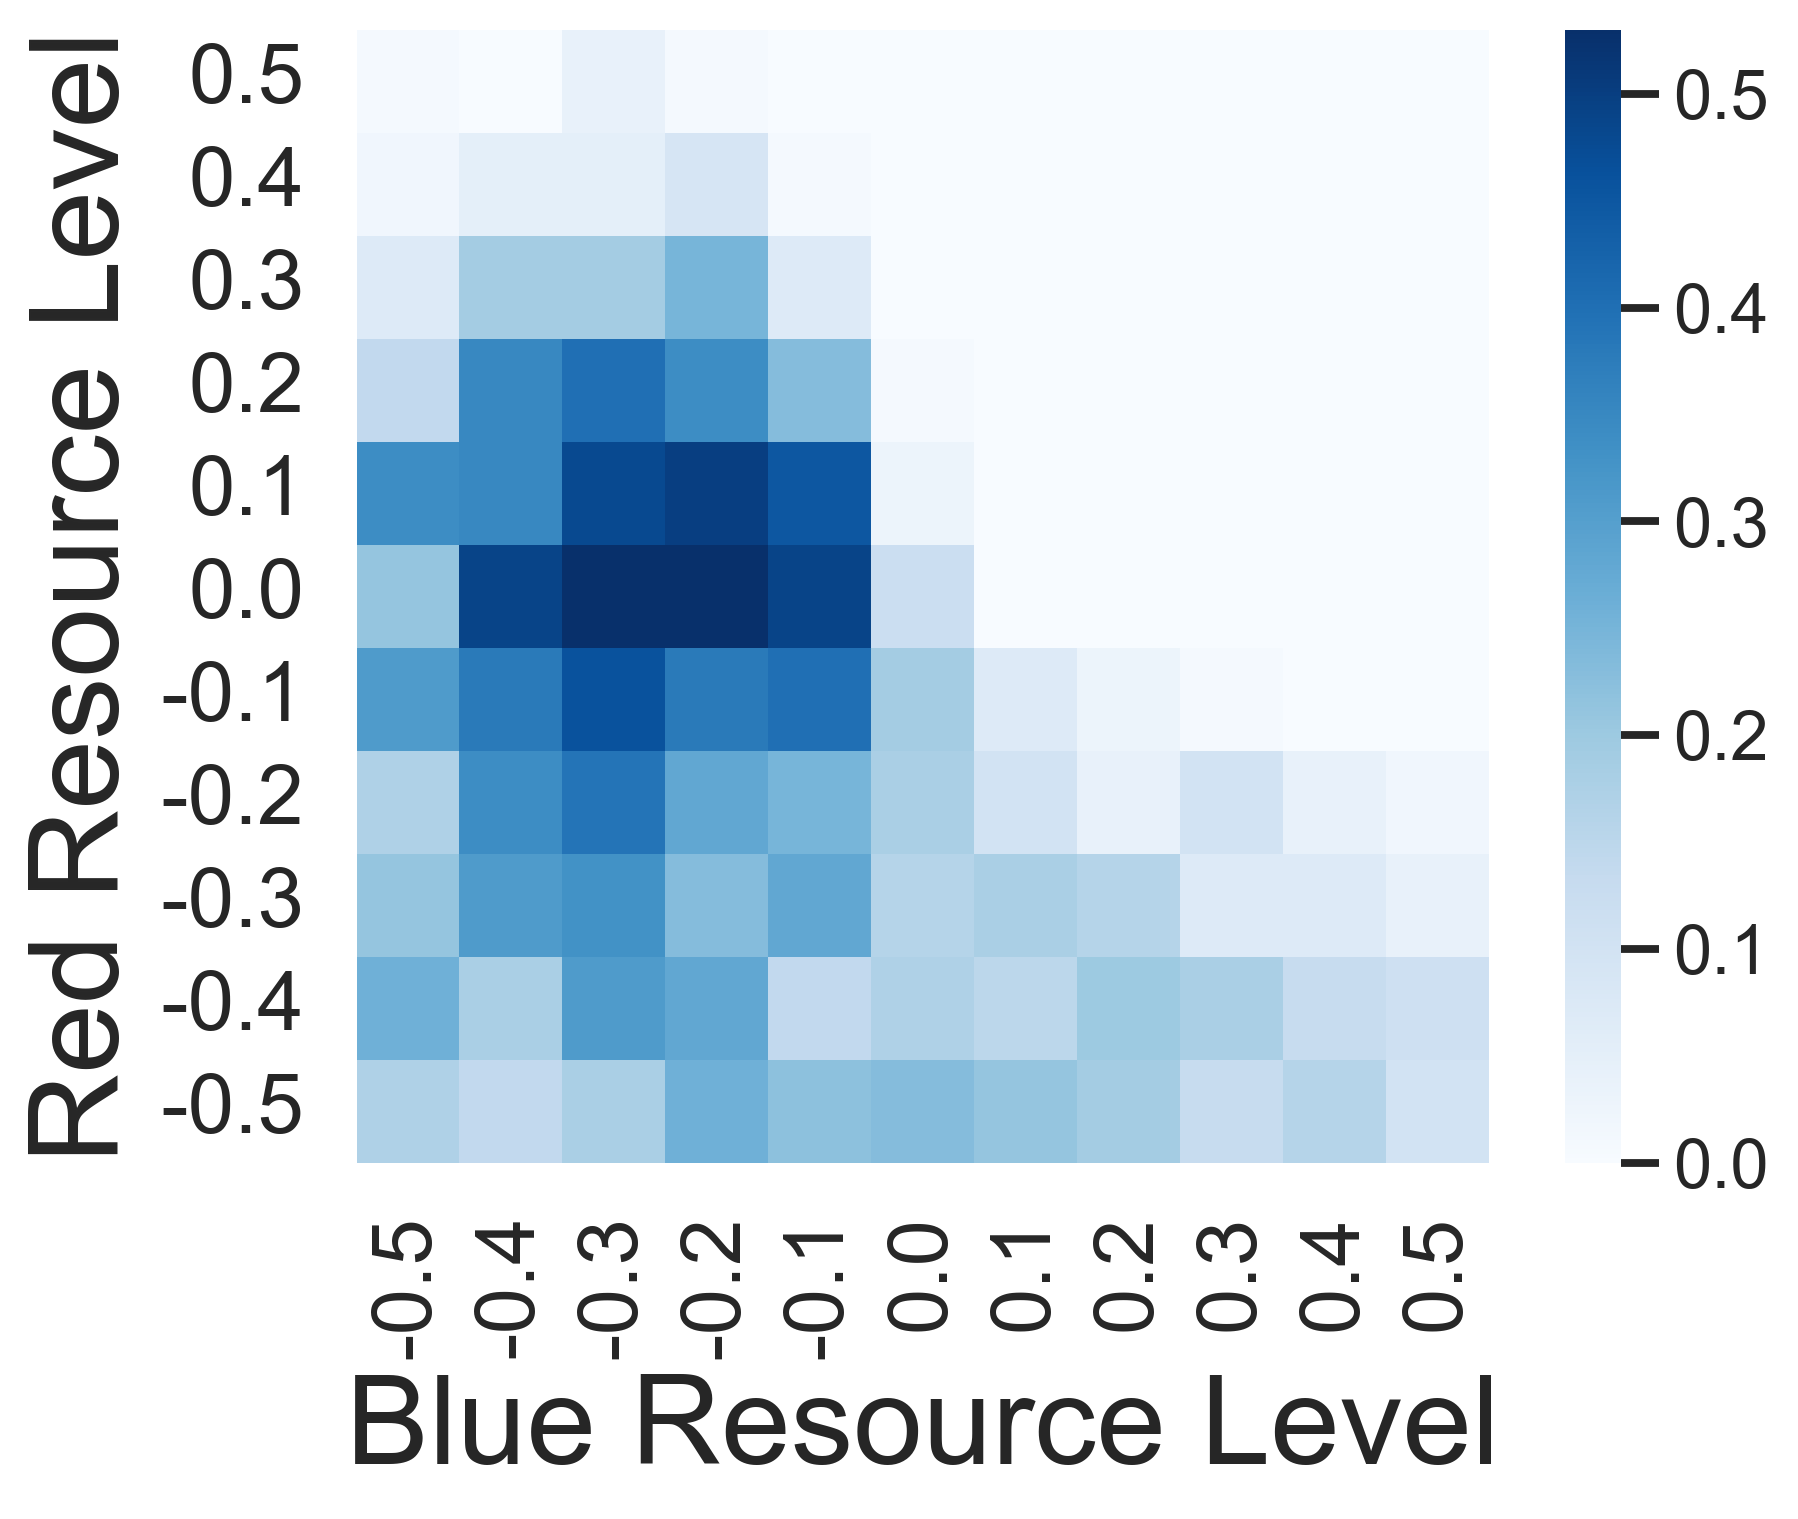

In [56]:

# Load Data
data_blue_matrix_5x5 = np.load("data_matrices_blue_5x5.npy")
data_red_matrix_5x5 = np.load("data_matrices_red_5x5.npy")


print("[i, j] = [blue_index, red_index]")
print("blue")
print(data_blue_matrix_5x5.transpose())

print("red")
print(data_red_matrix_5x5.transpose())

sns.set_context("talk")

plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap(data_red_matrix_5x5.transpose(),
                 cmap="Reds", #"binary_r",
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("red_matrix_5x5.png", bbox_inches='tight')
plt.show()

plt.figure(figsize=(6.5, 5), dpi=300)
ax =sns.heatmap(data_blue_matrix_5x5.transpose(),
                cmap="Blues", #"binary_r",
                square=True,
                xticklabels=blue_ticks.round(2),
                yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("blue_matrix_5x5.png", bbox_inches='tight')

/Users/naotoyoshida/.local/share/virtualenvs/ppo_pfrl-dDkQBMDa/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


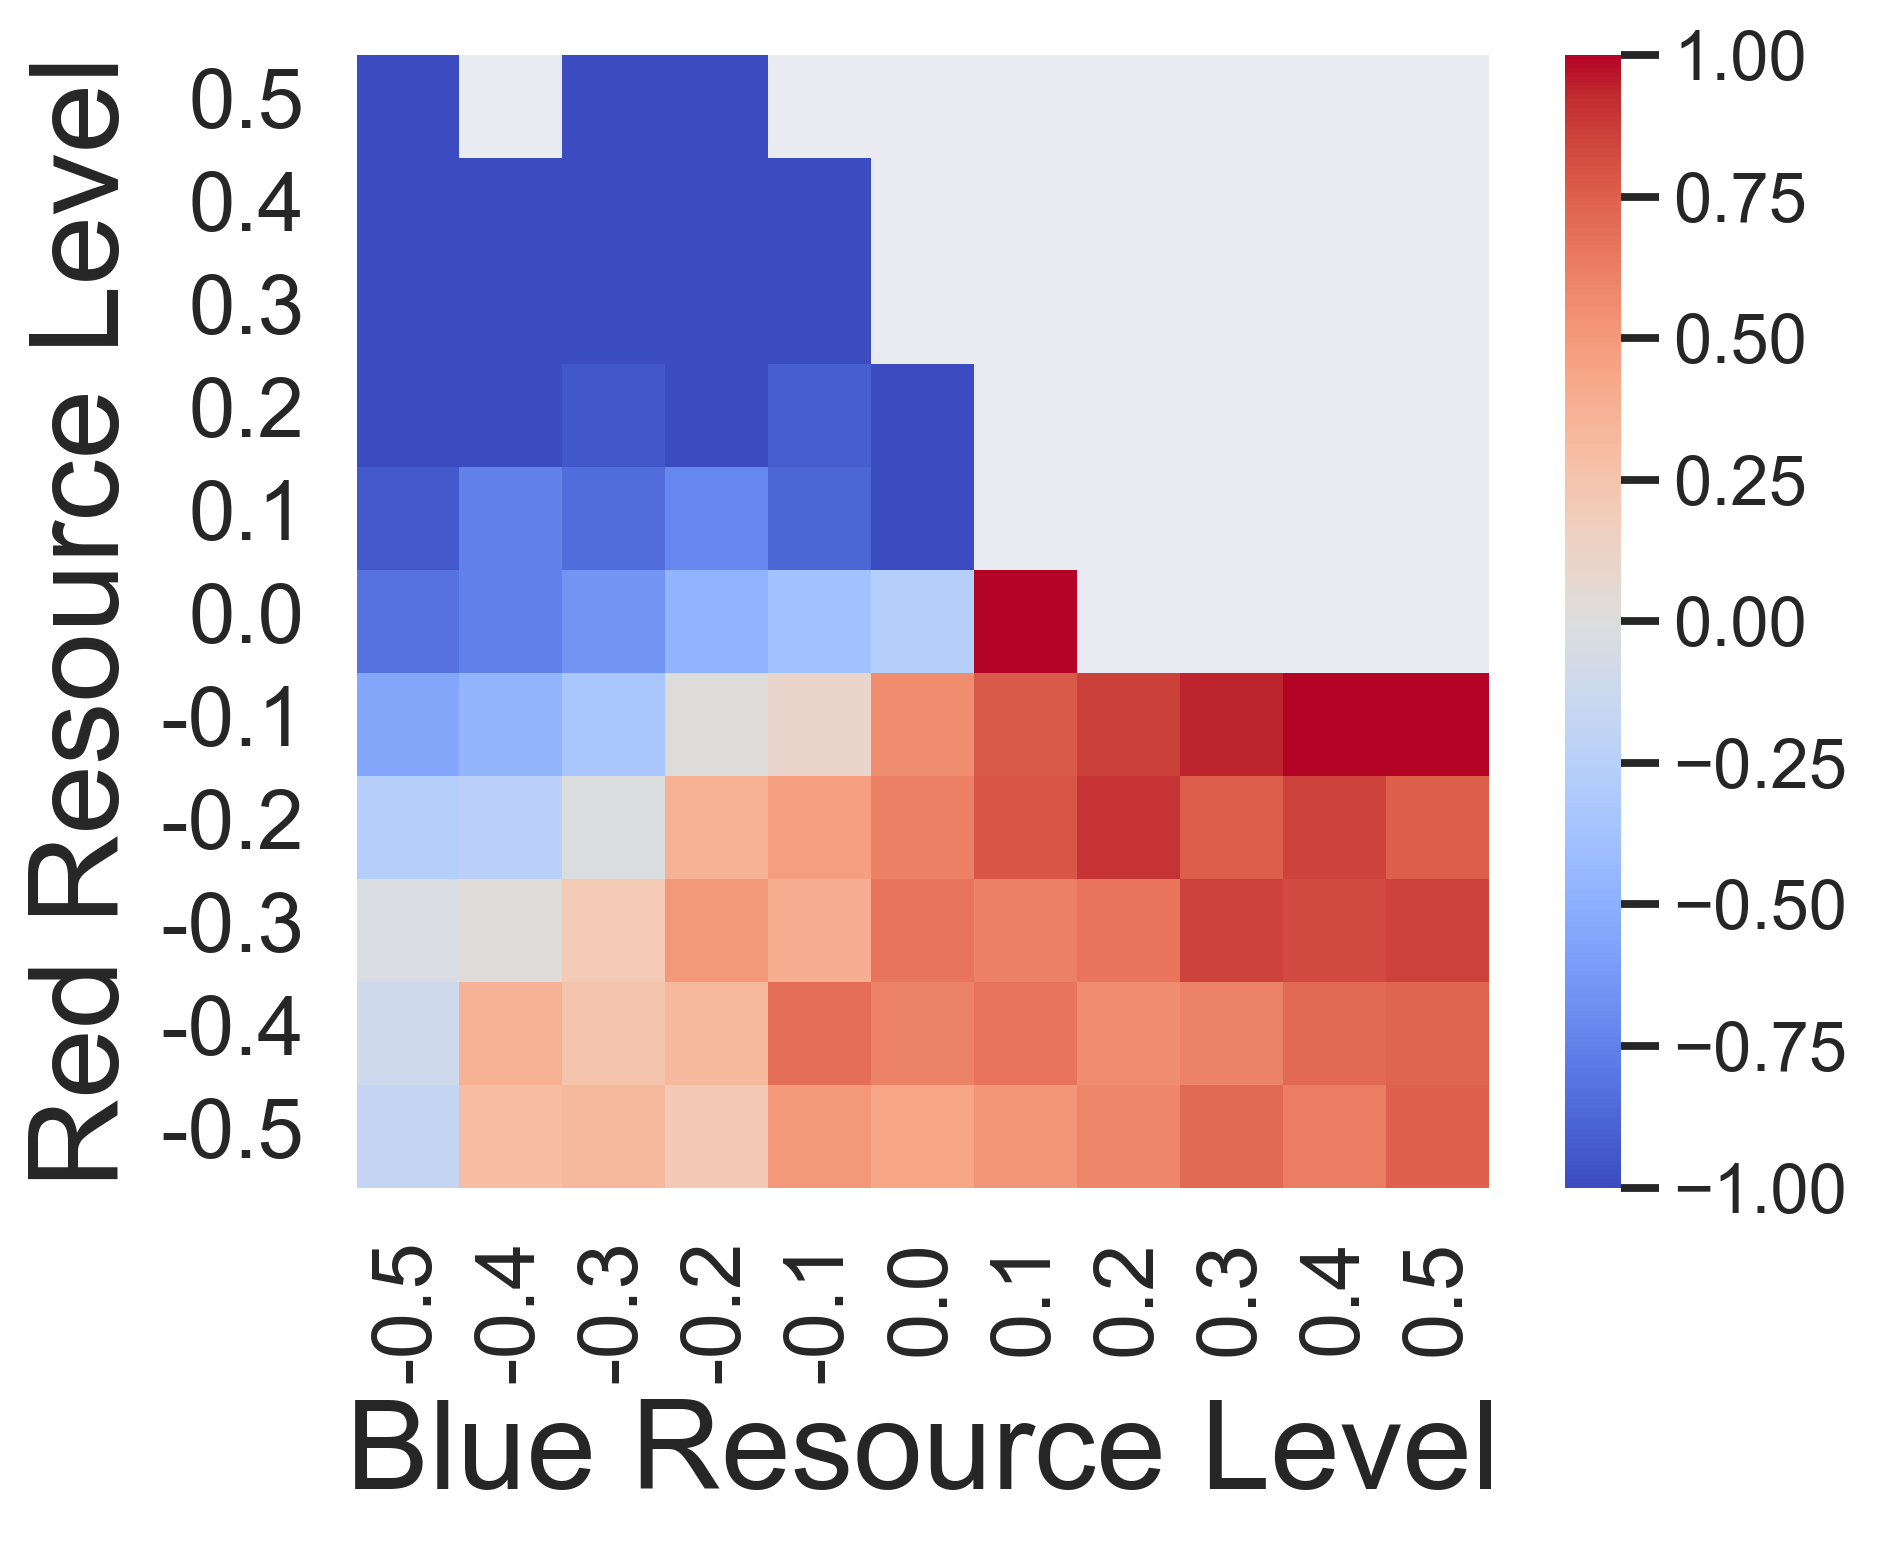

In [57]:
plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap(((data_red_matrix_5x5 - data_blue_matrix_5x5)/(data_blue_matrix_5x5 + data_red_matrix_5x5)).transpose(),
                 cmap='coolwarm',
                 center=0,
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("ba_pref_scaled_5x5.eps", bbox_inches='tight')
plt.show()

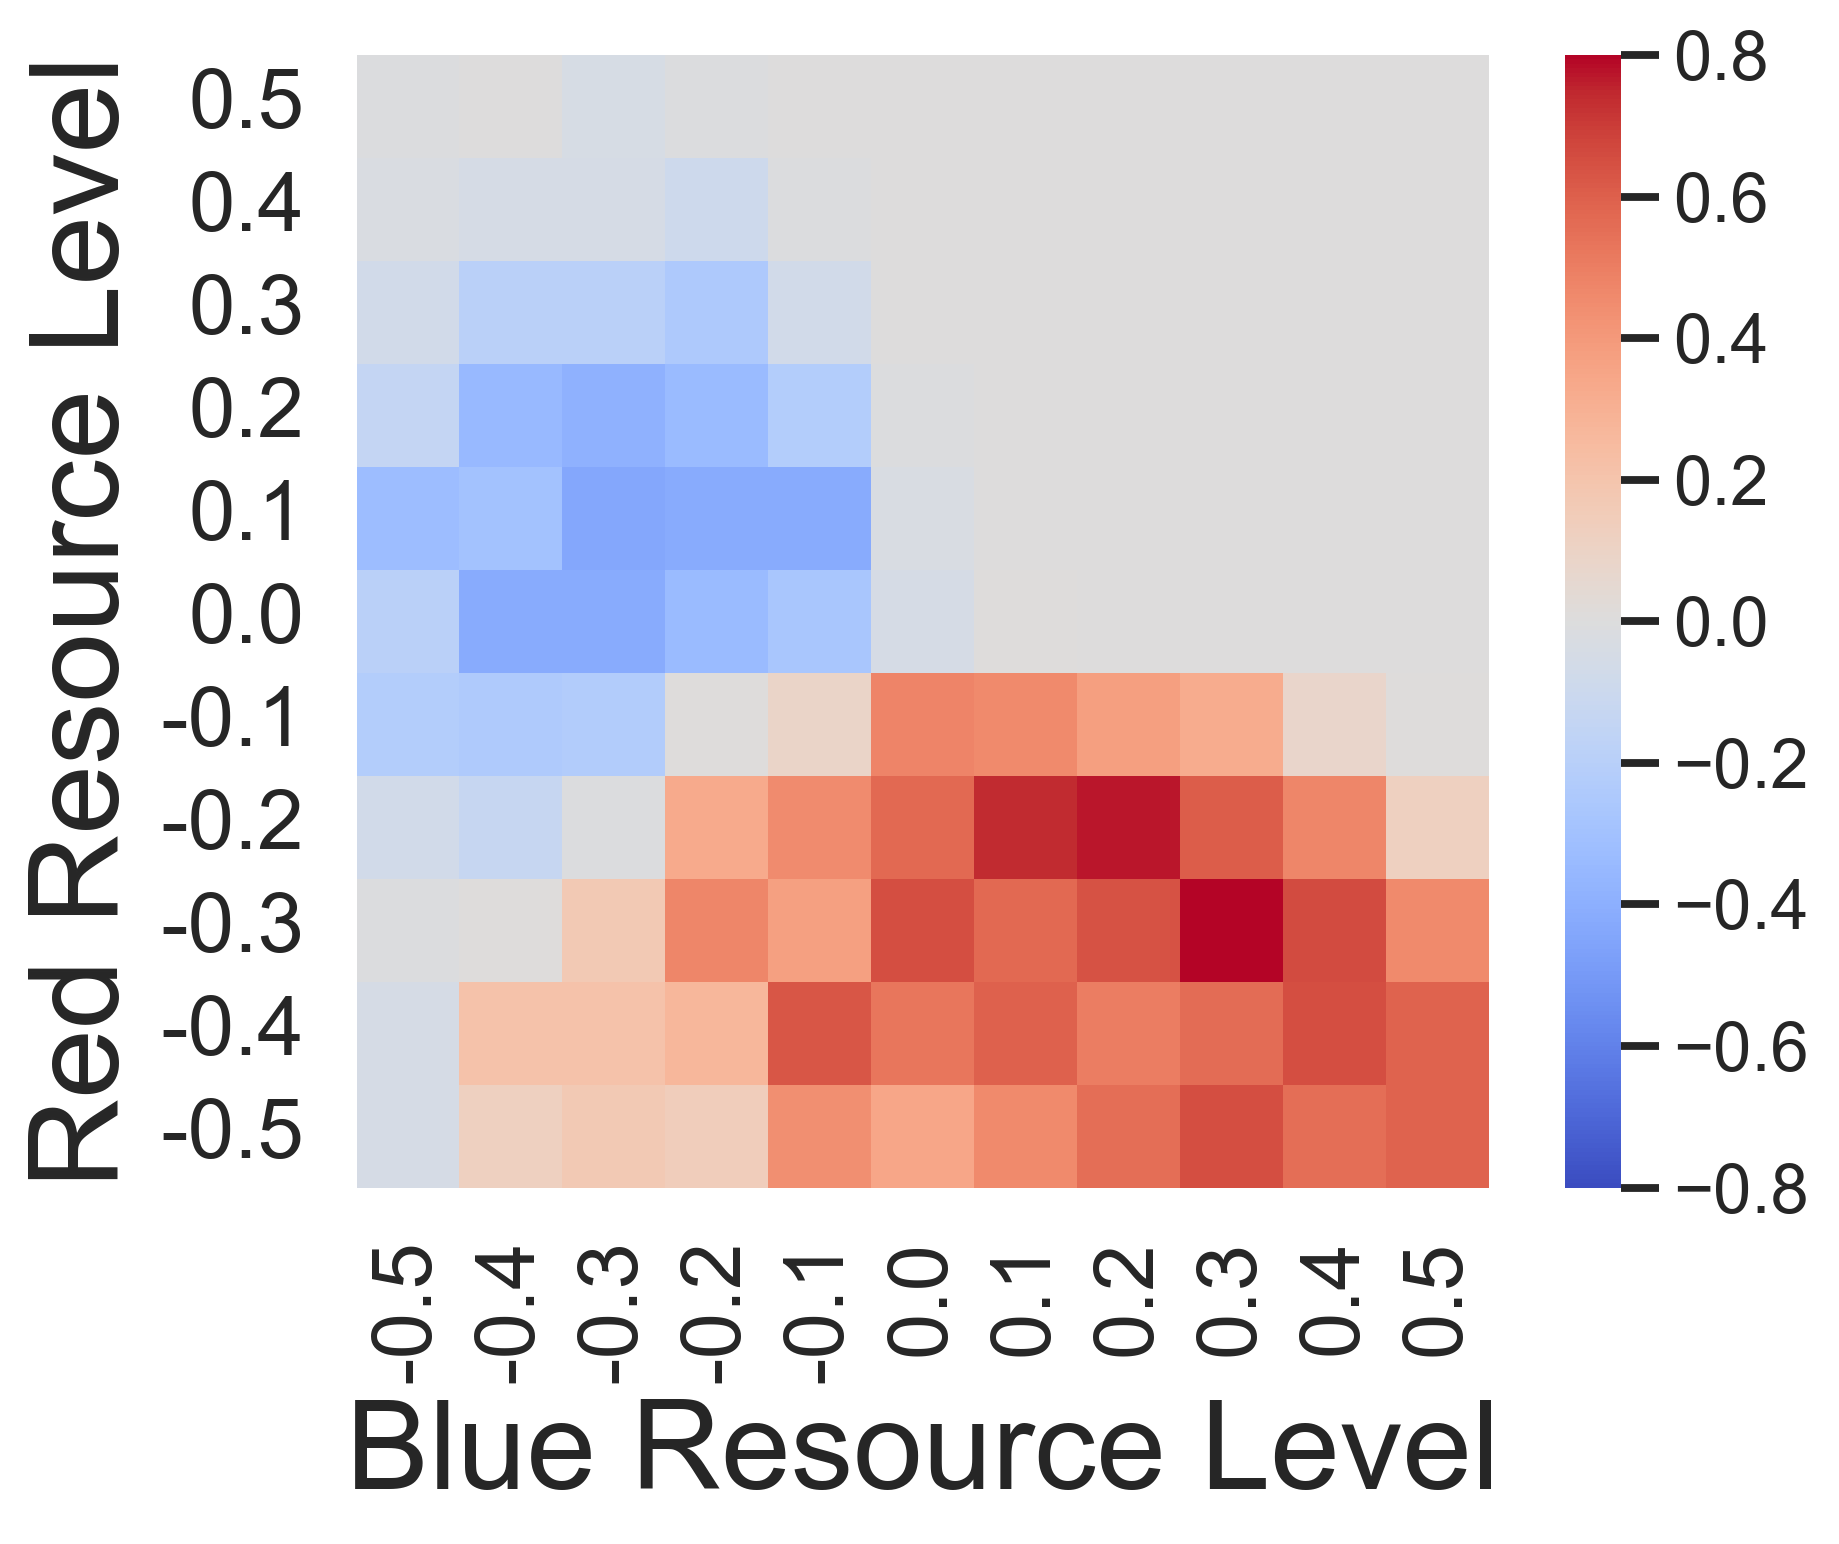

In [58]:
plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix_5x5 - data_blue_matrix_5x5).transpose(),
                 cmap='coolwarm',
                 center=0,
                 vmin=-0.8,
                 vmax=0.8,
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("ba_ratio_5x5.png", bbox_inches='tight')

plt.show()

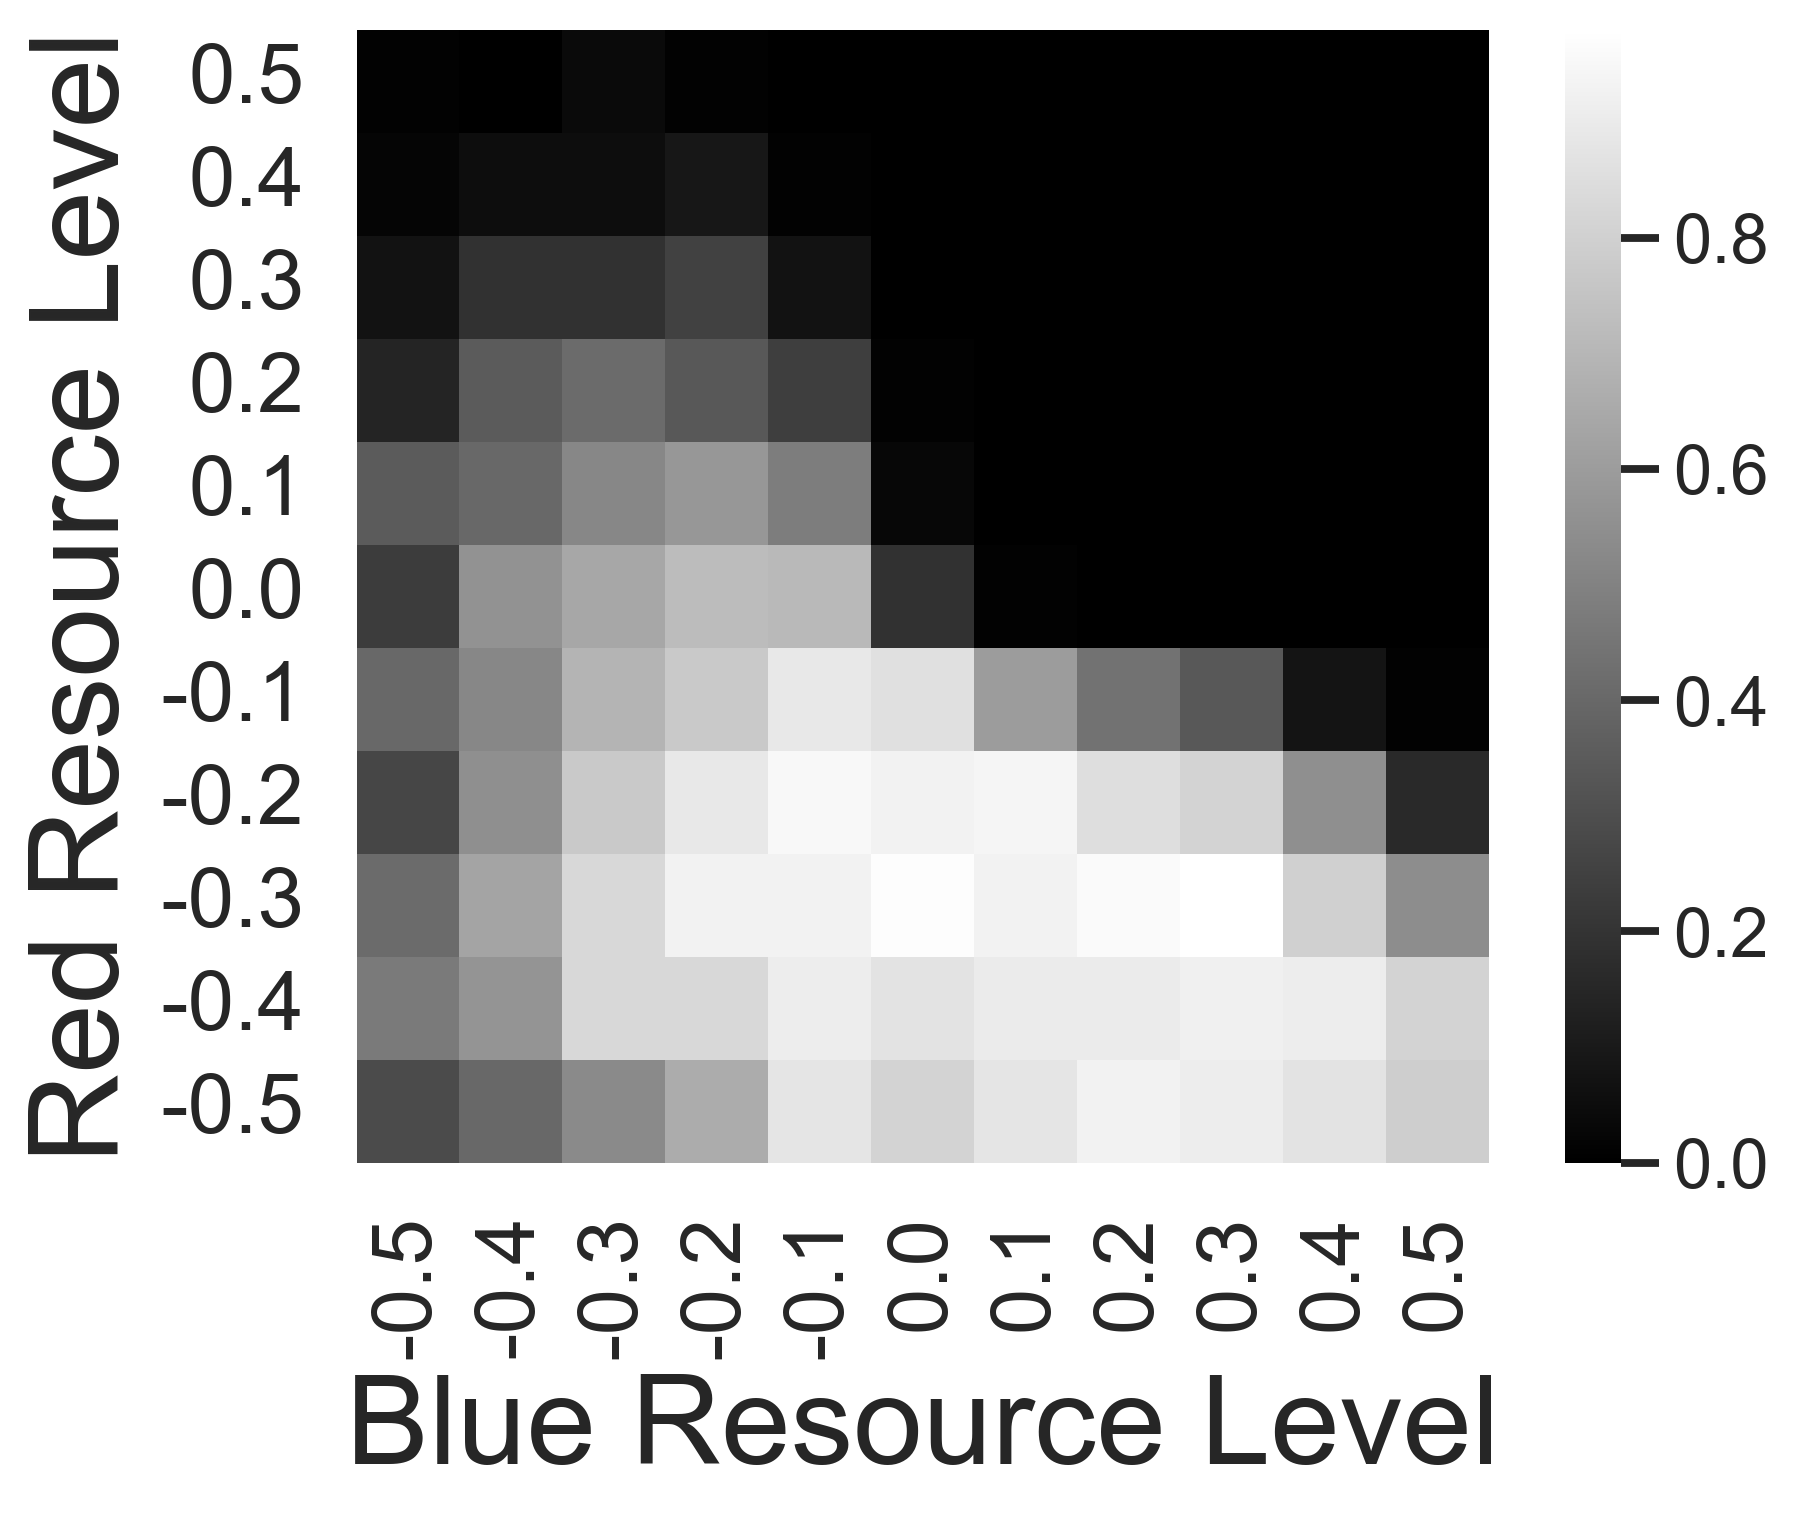

In [59]:
plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix_5x5 + data_blue_matrix_5x5).transpose(),
                 cmap="binary_r",
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)
ax.invert_yaxis()

plt.savefig("ba_collection_5x5.png", bbox_inches='tight')

# Plot full range

In [ ]:
data_blue_matrix_full = np.load("data/full_range_trp/data_matrices_blue_full.npy")
data_red_matrix_full = np.load("data/full_range_trp/data_matrices_red_full.npy")

print("[i, j] = [blue_index, red_index]")
print("blue")
print(data_blue_matrix_full.transpose())

print("red")
print(data_red_matrix_full.transpose())

blue_ticks_full = red_ticks_full = np.linspace(-1.0, 1.0, NUM_TICK)

sns.set_context("talk")

plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap(data_red_matrix_full.transpose(),
                 cmap="Reds", #"binary_r",
                 square=True,
                 xticklabels=blue_ticks_full.round(2),
                 yticklabels=red_ticks_full.round(2))
ax.invert_yaxis()
ax.set_ylabel("red")
ax.set_xlabel("blue")

plt.savefig("red_matrix_full.png", bbox_inches='tight')
plt.show()

plt.figure(figsize=(6.5, 5), dpi=300)
ax =sns.heatmap(data_blue_matrix_full.transpose(),
                cmap="Blues", #"binary_r",
                square=True,
                xticklabels=blue_ticks_full.round(2),
                yticklabels=red_ticks_full.round(2))
ax.invert_yaxis()
ax.set_ylabel("red")
ax.set_xlabel("blue")

plt.savefig("blue_matrix_full.png", bbox_inches='tight')

plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix_full - data_blue_matrix_full).transpose(),
                 cmap='coolwarm',
                 center=0,
                 vmin=-0.8,
                 vmax=0.8,
                 square=True,
                 xticklabels=blue_ticks_full.round(2),
                 yticklabels=red_ticks_full.round(2))
ax.invert_yaxis()
ax.set_ylabel("red")
ax.set_xlabel("blue")

plt.savefig("ba_ratio_full.png", bbox_inches='tight')

plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix_full + data_blue_matrix_full).transpose(),
                 cmap="binary_r",
                 square=True,
                 xticklabels=blue_ticks_full.round(2),
                 yticklabels=red_ticks_full.round(2))
ax.set_ylabel("red")
ax.set_xlabel("blue")
ax.invert_yaxis()

plt.savefig("ba_collection_full.png", bbox_inches='tight')

# Plot internal state

In [4]:
# Checking Learned Behavior
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)

sns.set()
sns.set_context("talk")
# sns.set_style("white")
env_trp = gym.make(
    "trp_env:SmallLowGearAntTRP-v0",
    max_episode_steps=np.inf,
    internal_reset="setpoint",
    n_bins=20,
    sensor_range=16,
)
env_trp = RescaleAction(env_trp, 0, 1)
env_trp = pfrl.wrappers.CastObservationToFloat32(env_trp)

im = []
intero = []
obs = env_trp.reset()

agent.load("data/result_trp_therm_oct2021/trp-homeostatic_shaped2021-09-30-14-54-11/150000000_finish")

done = False
for i in tqdm(range(40000)):
    action = agent.act(obs)
    obs, _, done, _ = env_trp.step(action)
#     if i % 50 == 0:
#         if env_trp.wrapped_env.viewer: 
#             env_trp.wrapped_env.viewer.cam.trackbodyid = 1
#             env_trp.wrapped_env.viewer.cam.distance = env_trp.wrapped_env.model.stat.extent * 0.9
#             env_trp.wrapped_env.viewer.cam.lookat[0] += 0.
#             env_trp.wrapped_env.viewer.cam.lookat[1] += 0.
#             env_trp.wrapped_env.viewer.cam.lookat[2] += 0.
#             env_trp.wrapped_env.viewer.cam.elevation = -90
#             env_trp.wrapped_env.viewer.cam.azimuth = 0

#         im.append(env_trp.render(mode="rgb_array", height=200, width=200))
    intero.append(env_trp.get_interoception())

intero = np.array(intero)
env_trp.close()
"""
r = 5
blue = -0.3
red = -0.0
while True:
    obs = env.reset(initial_internal=(blue, red),
                    object_positions={"blue": [(RADIUS*np.cos(a), RADIUS*np.sin(a)) for a in np.random.uniform(-np.pi, np.pi, NUM_FOOD)],
                                      "red": [(RADIUS*np.cos(a), RADIUS*np.sin(a)) for a in np.random.uniform(-np.pi, np.pi, NUM_FOOD)]})
#     if np.random.rand() < 0.5:
#         obs = env.reset(initial_internal=(blue, red), object_positions={"blue": POS1, "red": POS2})
#     else:
#         obs = env.reset(initial_internal=(blue, red), object_positions={"blue": POS2, "red": POS1})
    done = False
    for _ in range(TIME_STEPS):
        action = agent.act(obs)
        obs, _, done, _ = env.step(action)
        env.render()
        if done:
            break
"""

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [01:47<00:00, 371.27it/s]


'\nr = 5\nblue = -0.3\nred = -0.0\nwhile True:\n    obs = env.reset(initial_internal=(blue, red),\n                    object_positions={"blue": [(RADIUS*np.cos(a), RADIUS*np.sin(a)) for a in np.random.uniform(-np.pi, np.pi, NUM_FOOD)],\n                                      "red": [(RADIUS*np.cos(a), RADIUS*np.sin(a)) for a in np.random.uniform(-np.pi, np.pi, NUM_FOOD)]})\n#     if np.random.rand() < 0.5:\n#         obs = env.reset(initial_internal=(blue, red), object_positions={"blue": POS1, "red": POS2})\n#     else:\n#         obs = env.reset(initial_internal=(blue, red), object_positions={"blue": POS2, "red": POS1})\n    done = False\n    for _ in range(TIME_STEPS):\n        action = agent.act(obs)\n        obs, _, done, _ = env.step(action)\n        env.render()\n        if done:\n            break\n'

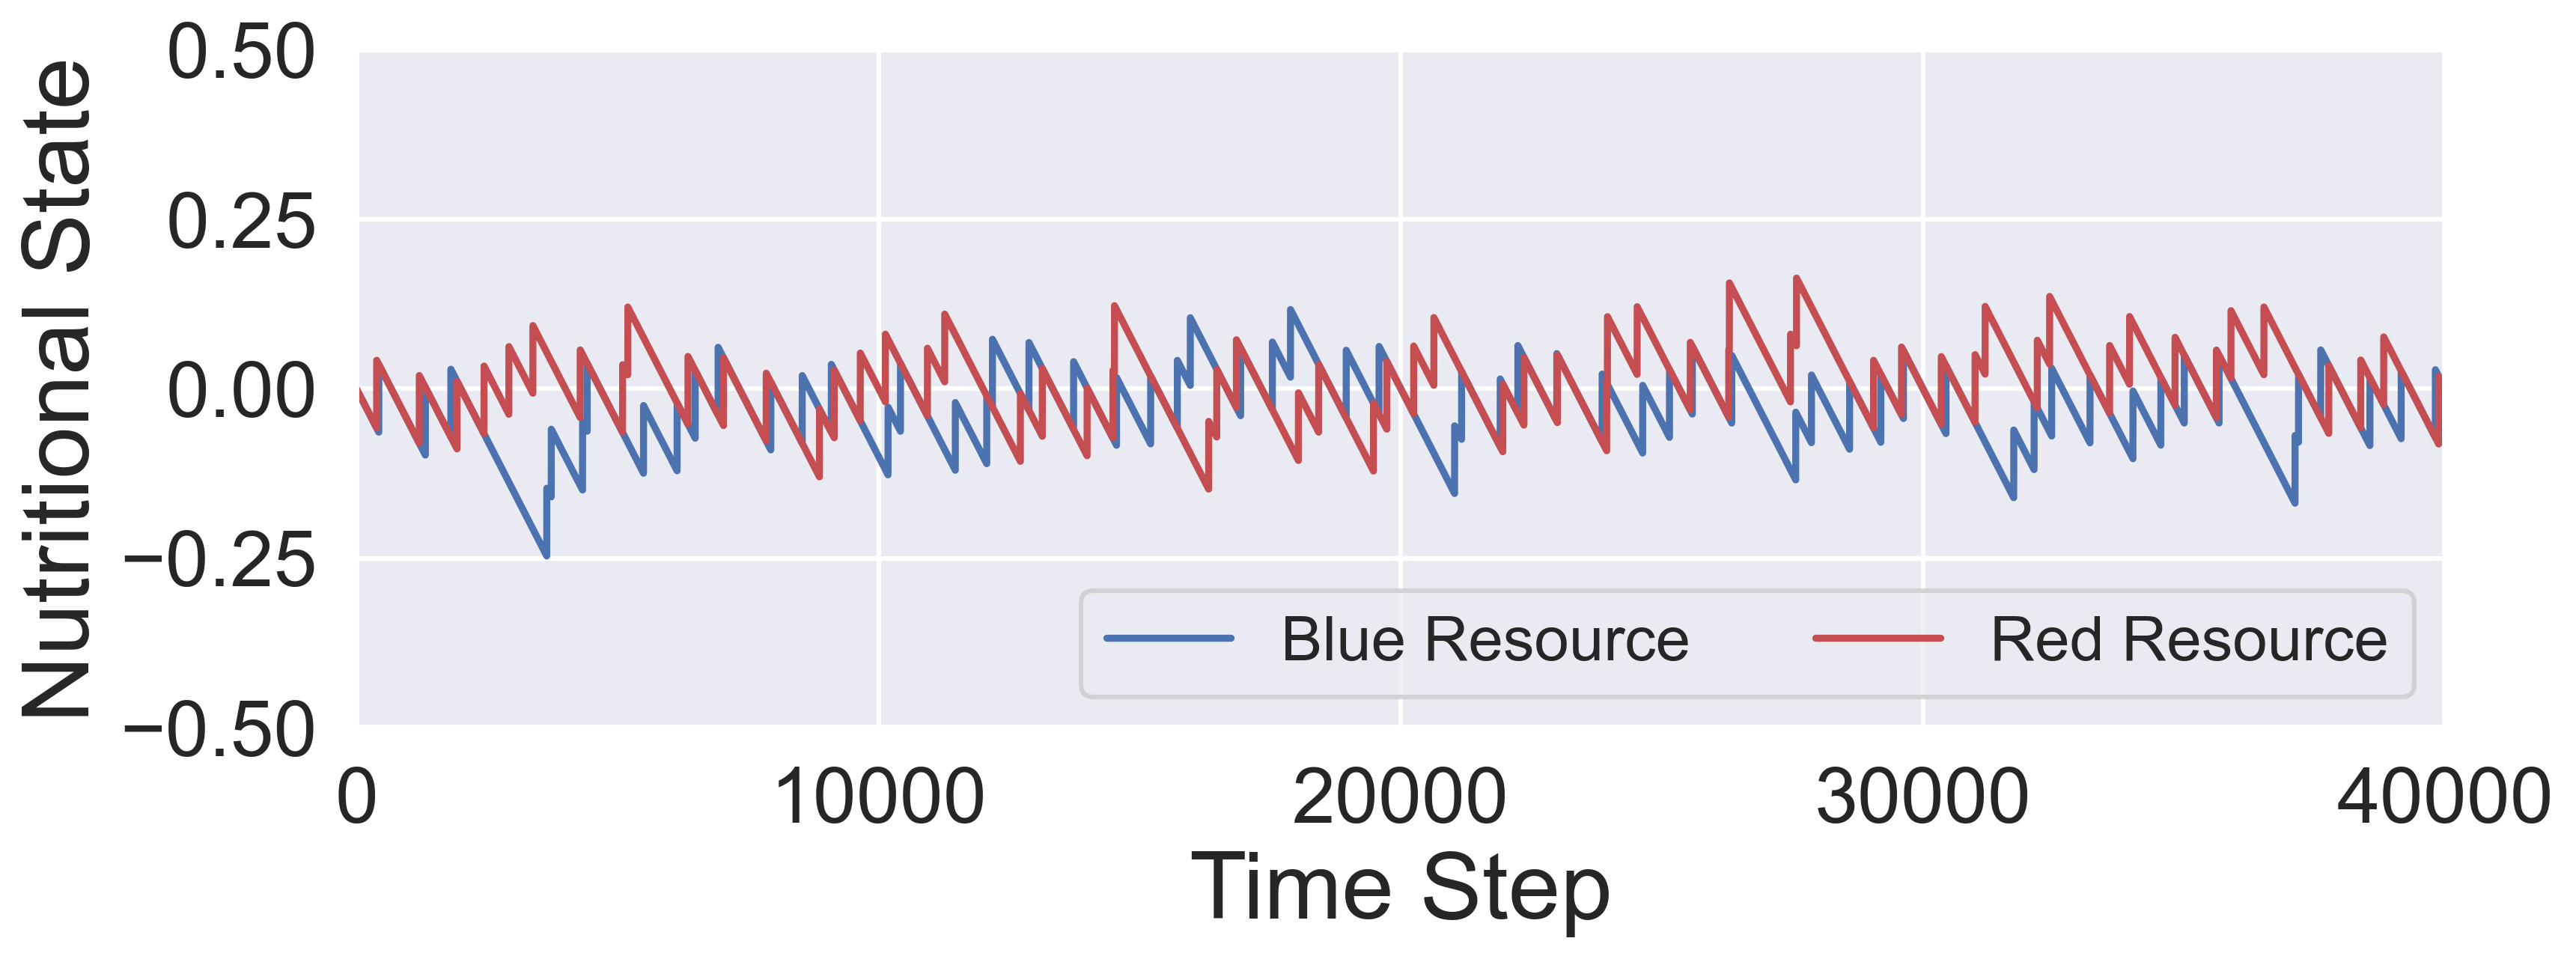

In [6]:
intero = np.array(intero)
plt.figure(figsize=(12, 4), dpi=300)
plt.plot(intero[:, 0], color="b")
plt.plot(intero[:, 1], color="r")
plt.xlabel("Time Step", fontsize=30)
plt.ylabel("Nutritional State", fontsize=30)
plt.ylim([-0.5, 0.5])
plt.xlim([0, 40000])
plt.xticks([10000 * i for i in range(5)])
plt.yticks([-0.5, -0.25, 0, 0.25, 0.5])
plt.tick_params(labelsize=25)
plt.legend(["Blue Resource", "Red Resource"],
           loc='lower right', ncol=4, prop={'size': 20})

plt.savefig("trp40000.png", bbox_inches='tight')

# Recording

In [ ]:
# Checking Learned Behavior
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)

env_trp = gym.make(
    "trp_env:SmallLowGearAntTRP-v0",
    max_episode_steps=np.inf,
    internal_reset="setpoint",
    n_bins=20,
    sensor_range=16,
)
env_trp = RescaleAction(env_trp, 0, 1)
env_trp = pfrl.wrappers.CastObservationToFloat32(env_trp)

done = False
obs = env_trp.reset()
for i in tqdm(range(100000)):
    action = agent.act(obs)
    obs, _, done, _ = env_trp.step(action)
    env_trp.render()

env_trp.close()

# Average Distributions

## 6x4 agents 

In [19]:
data_red_matrix_ave_6x4 = []
data_blue_matrix_ave_6x4 = []

for i in range(5):
    p = Path("tmp/trp6x4")
    
    data_red_matrix_ave_6x4.append(np.load(p / f"data_matrices_red_{i}.npy"))
    data_blue_matrix_ave_6x4.append(np.load(p / f"data_matrices_blue_{i}.npy"))
    
data_red_matrix_ave_6x4 = np.array(data_red_matrix_ave_6x4)
data_blue_matrix_ave_6x4 = np.array(data_blue_matrix_ave_6x4)

print(data_red_matrix_ave_6x4.shape)
print(data_blue_matrix_ave_6x4.shape)

(5, 11, 11)
(5, 11, 11)


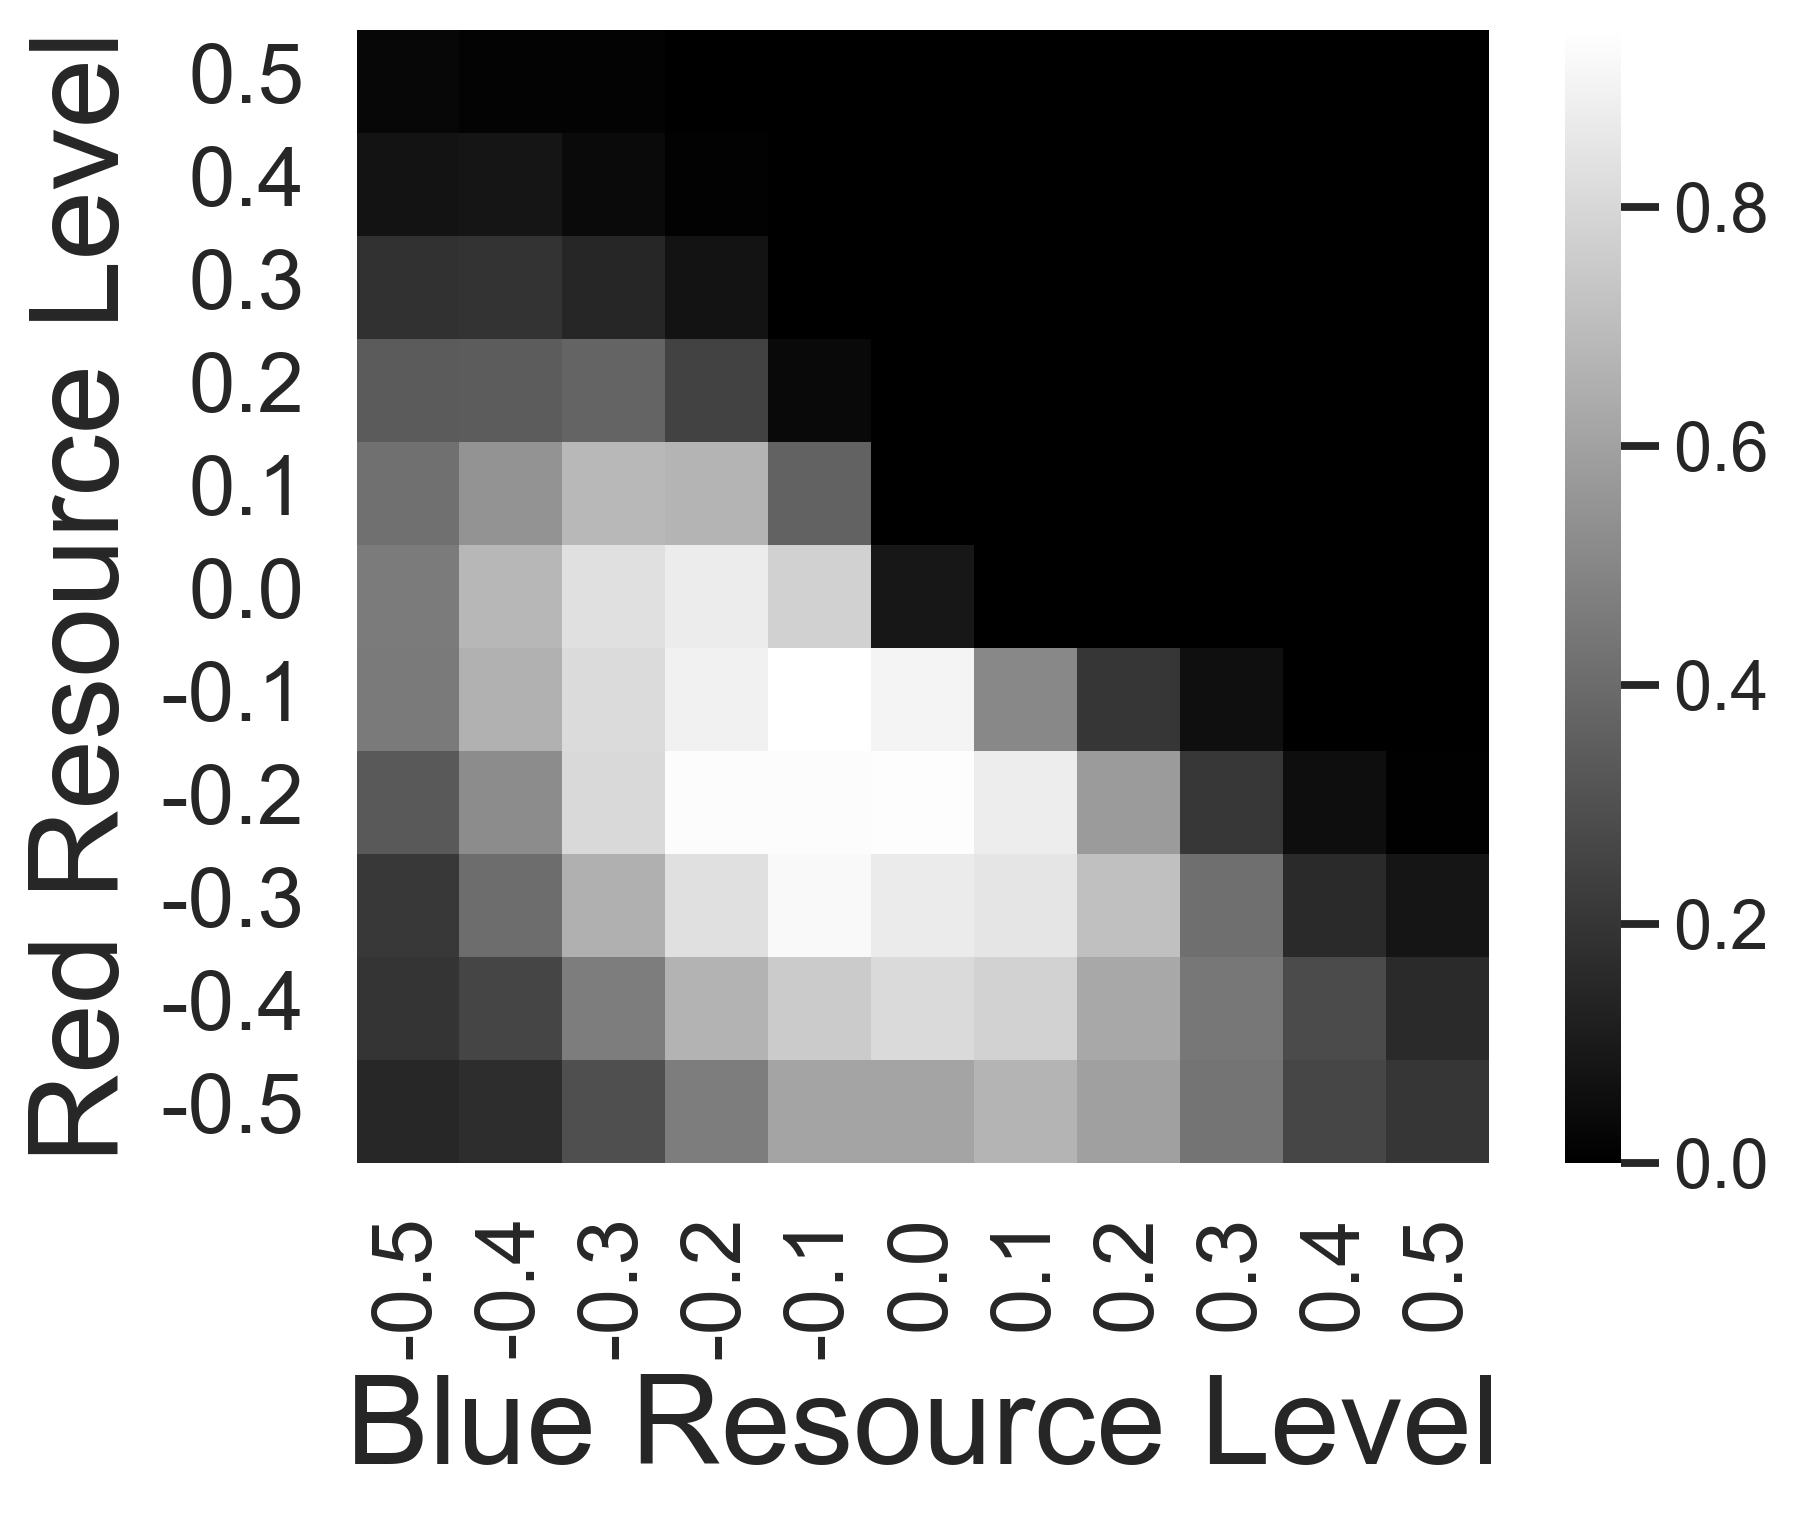

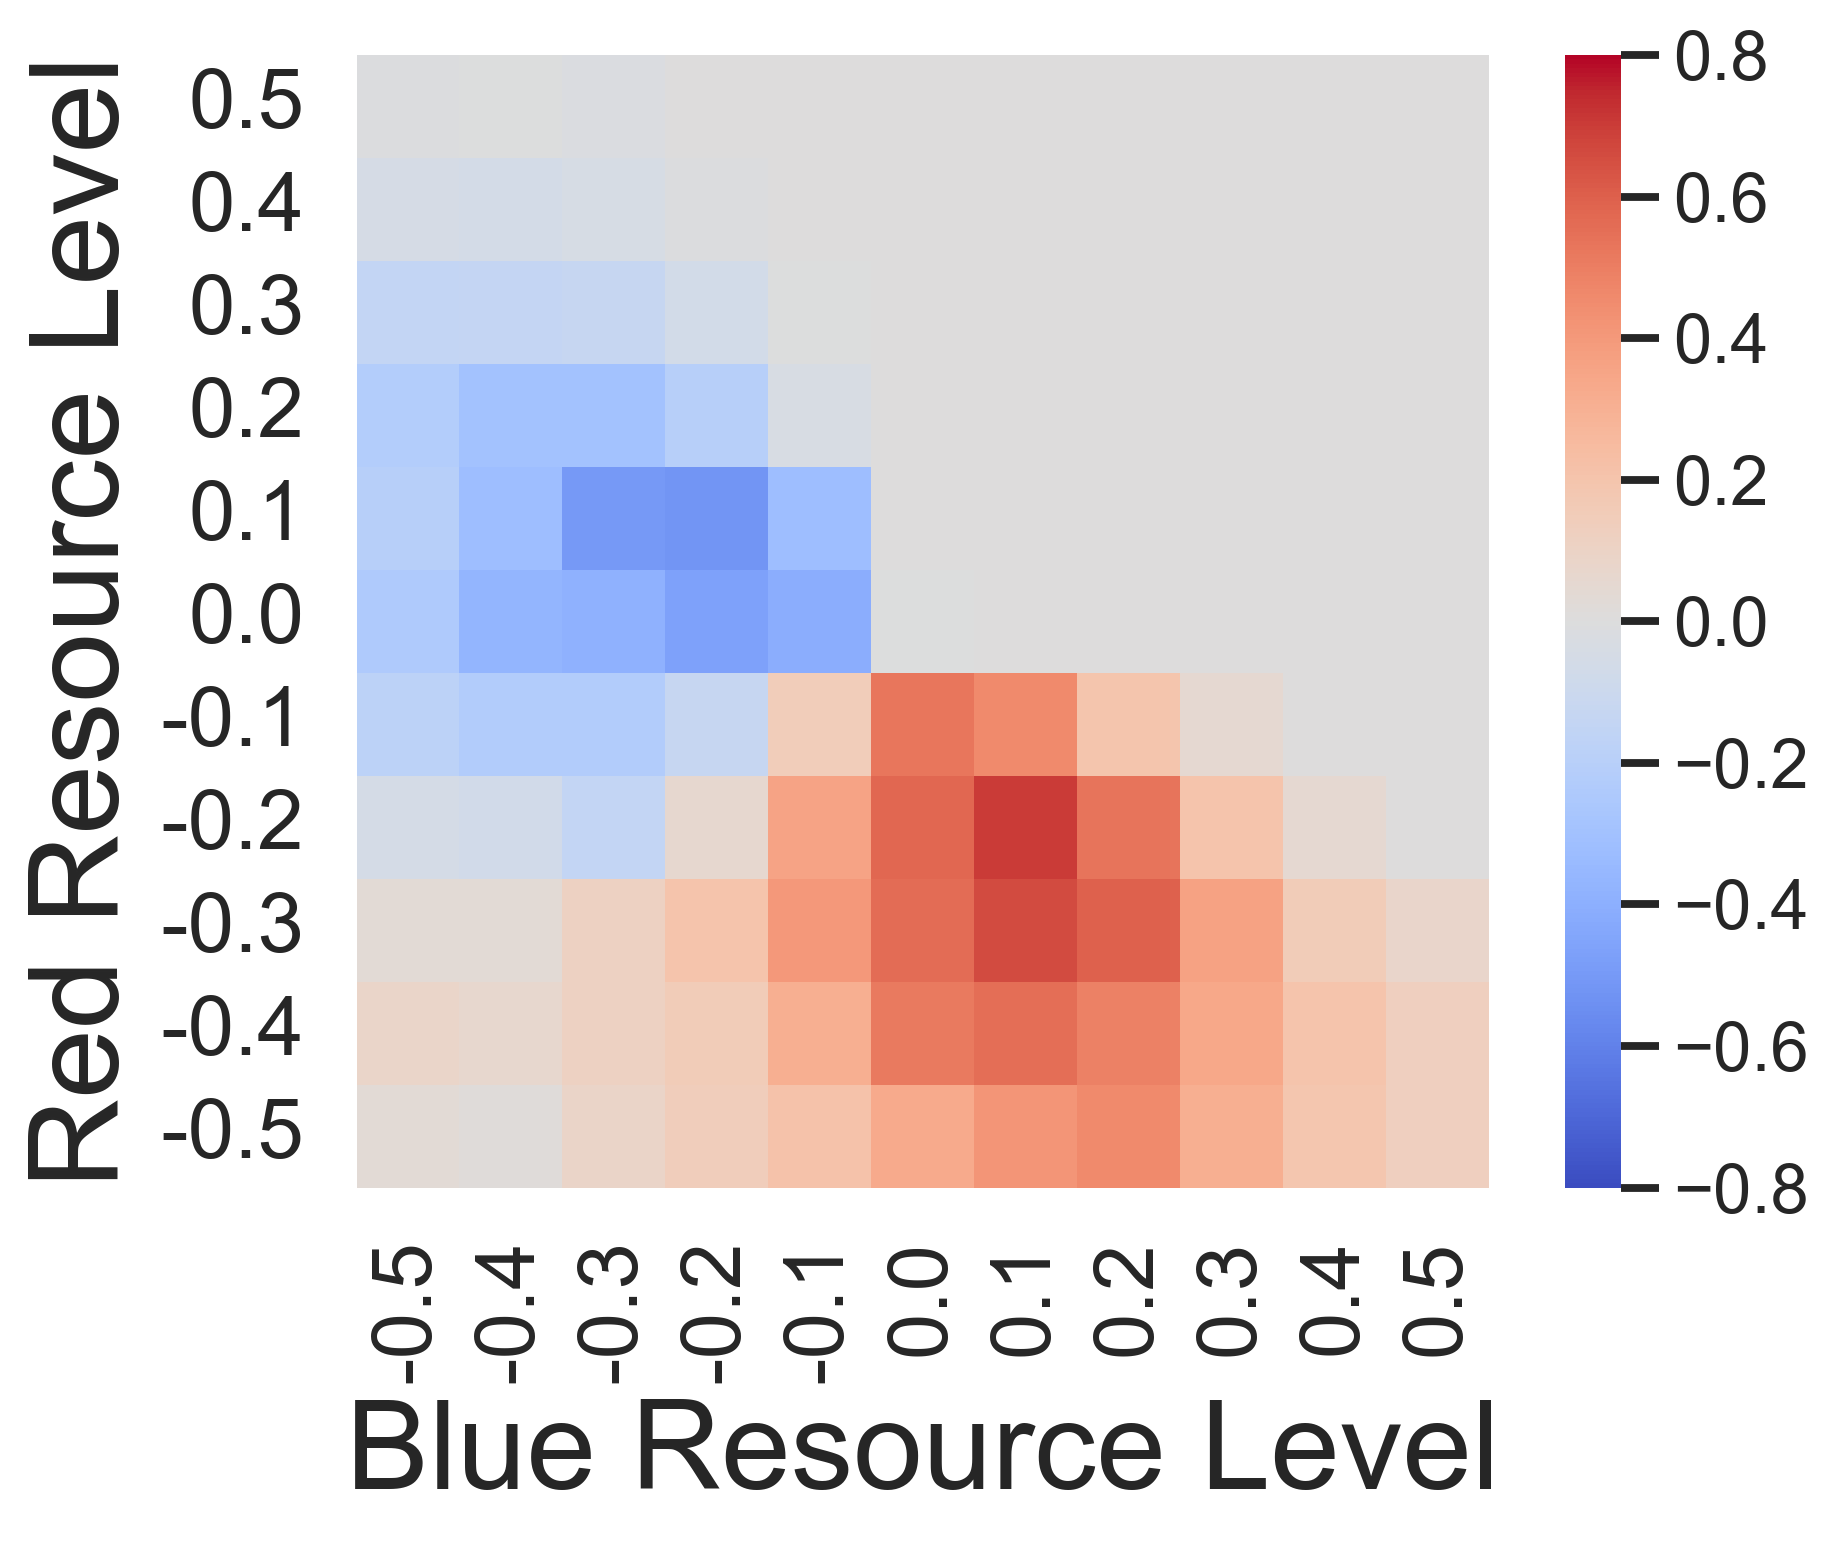

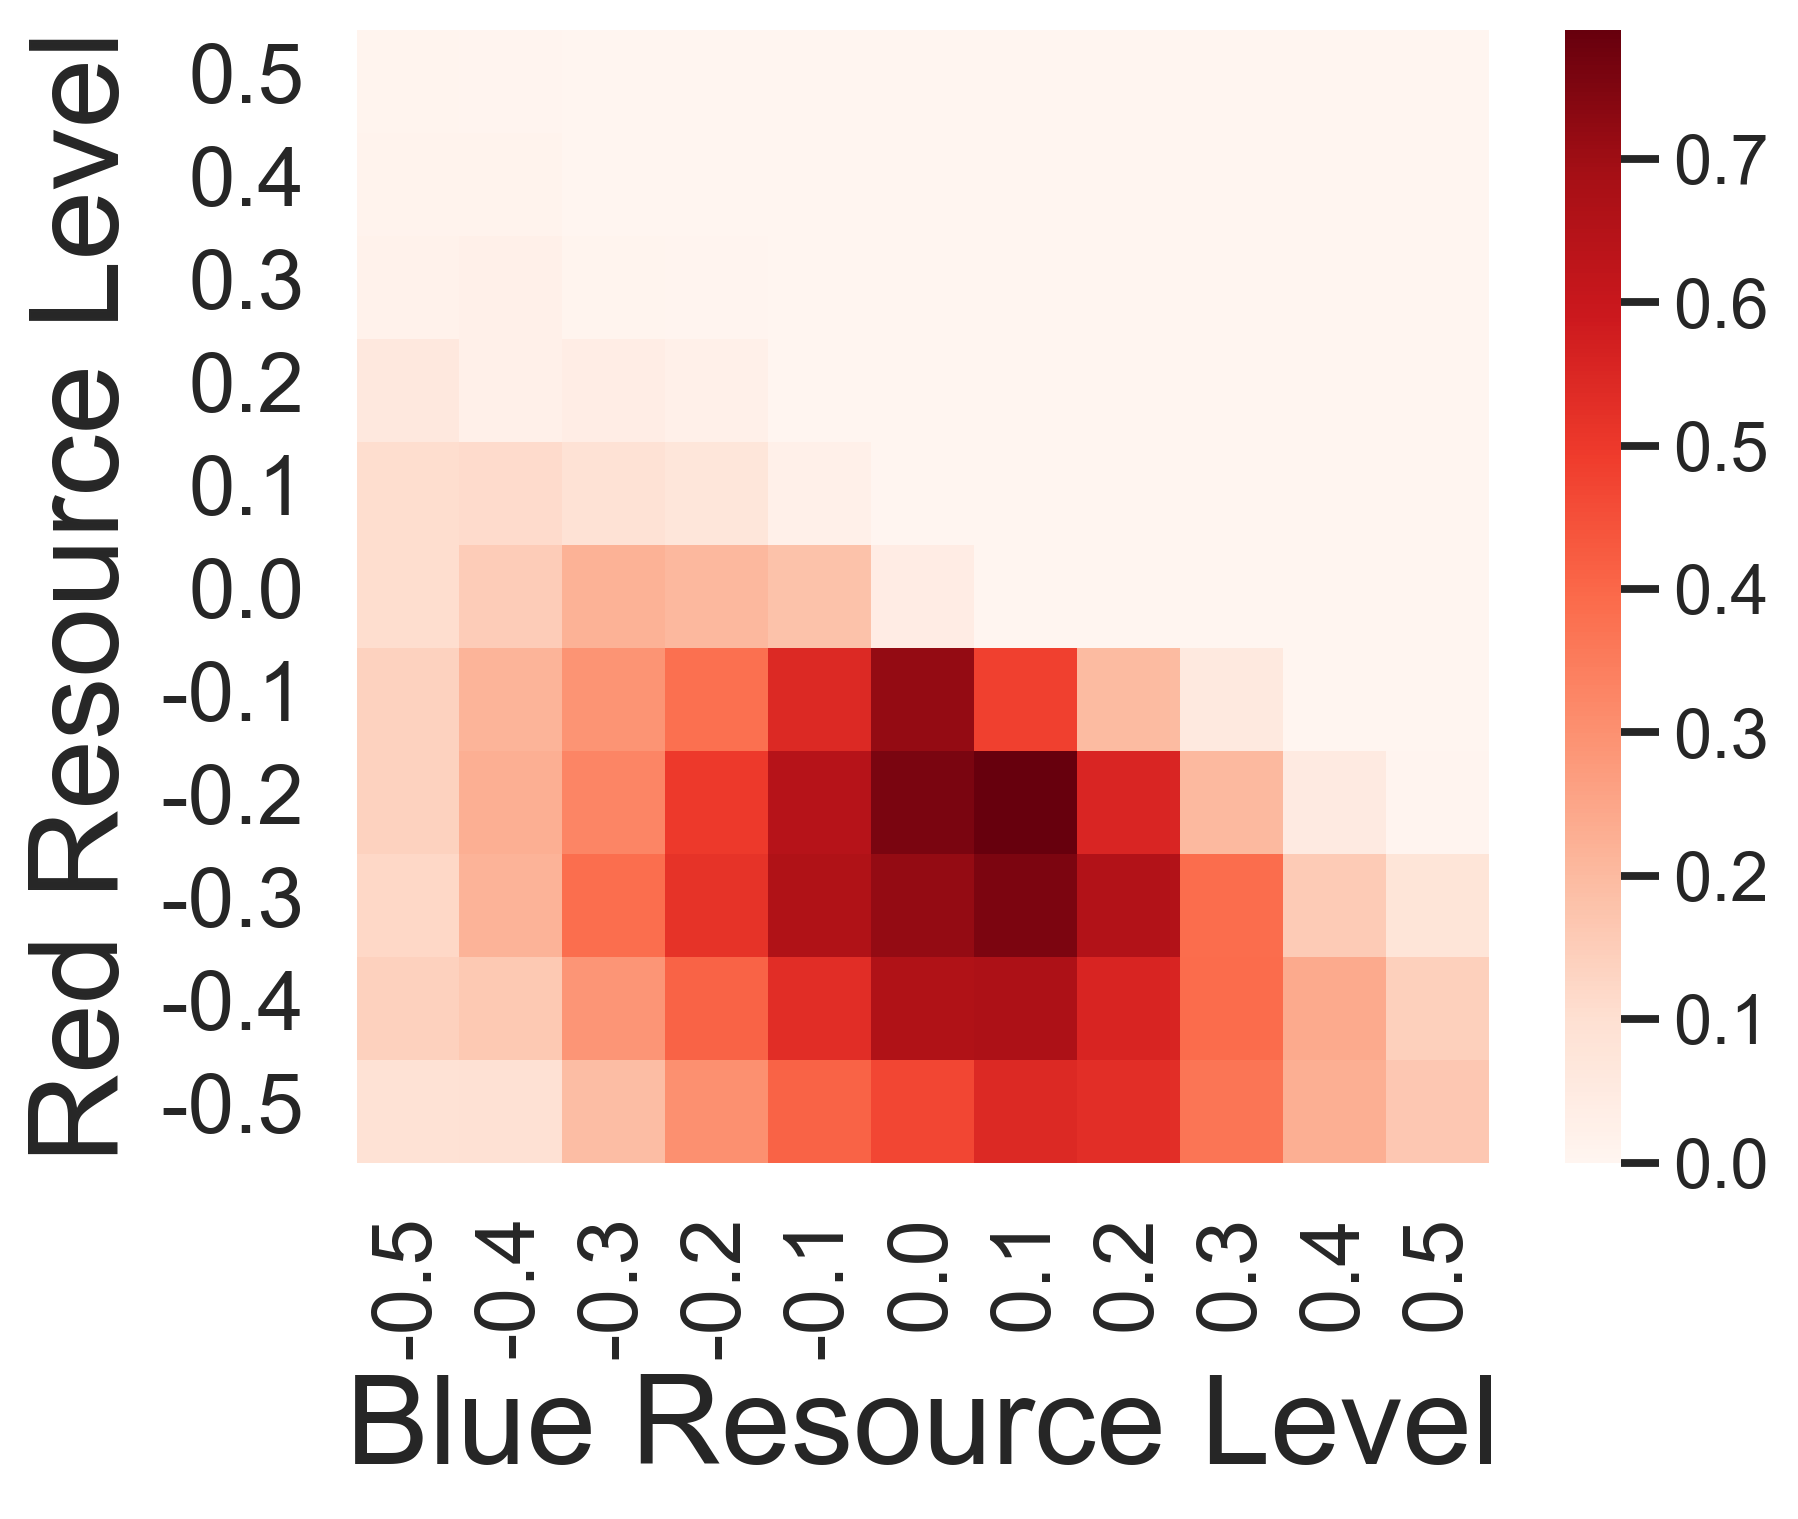

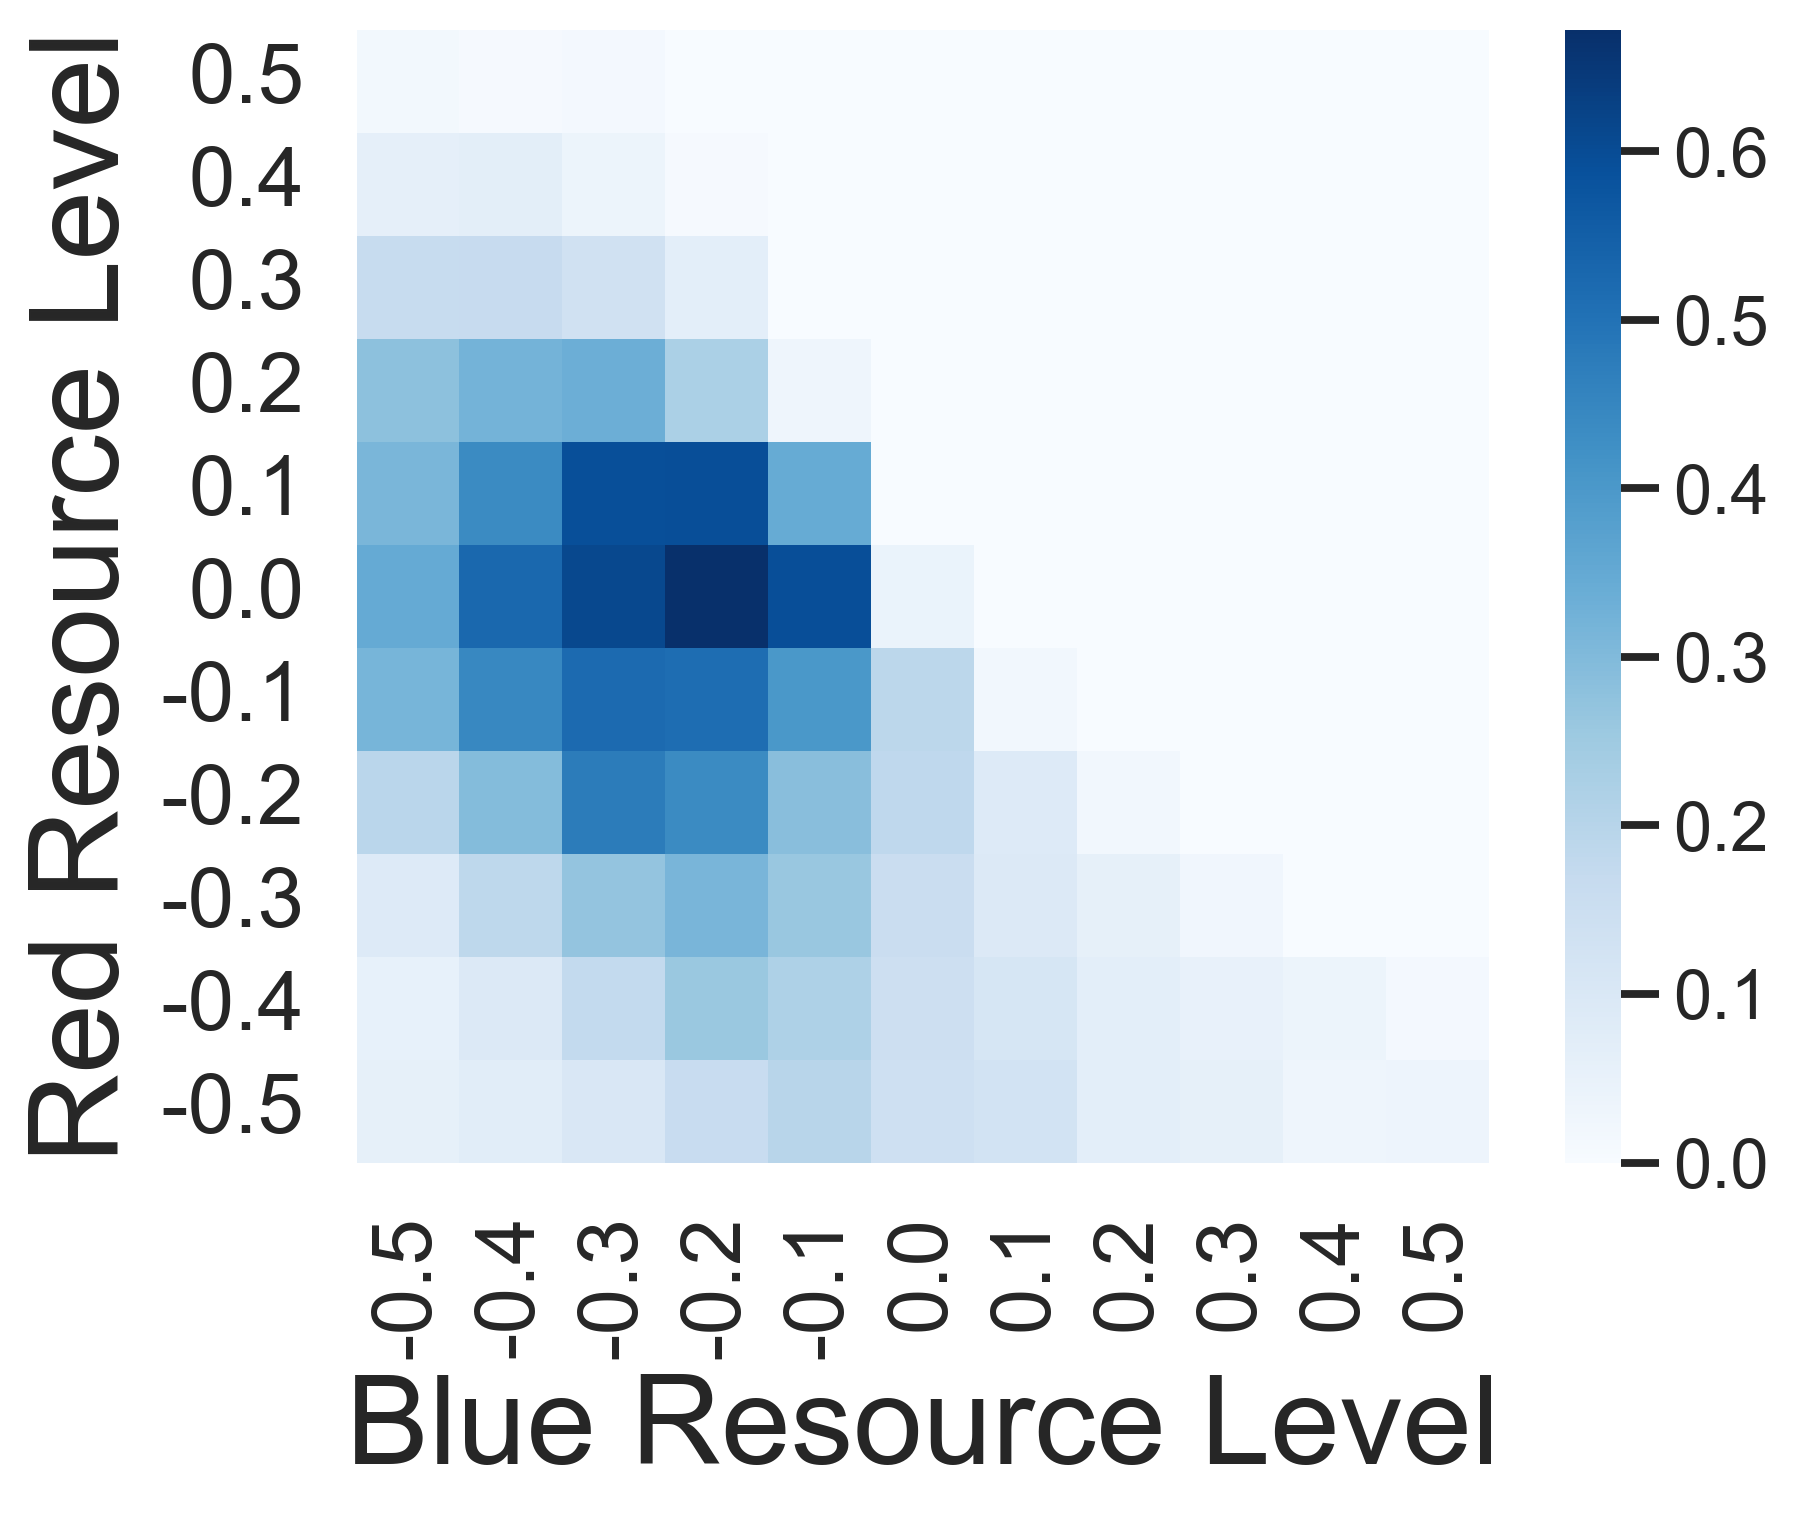

In [20]:
sns.set_context("talk")


plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix_ave_6x4.mean(axis=0) + data_blue_matrix_ave_6x4.mean(axis=0)).transpose(),
                 cmap="binary_r",
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)
ax.invert_yaxis()

plt.savefig("ba_collection_average_6x4.png", bbox_inches='tight')



plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix_ave_6x4.mean(axis=0) - data_blue_matrix_ave_6x4.mean(axis=0)).transpose(),
                 cmap='coolwarm',
                 center=0,
                 vmin=-0.8,
                 vmax=0.8,
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("ba_ratio_average_6x4.png", bbox_inches='tight')



plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap(data_red_matrix_ave_6x4.mean(axis=0).transpose(),
                 cmap="Reds", #"binary_r",
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("red_matrix_average_6x4.png", bbox_inches='tight')
plt.show()



plt.figure(figsize=(6.5, 5), dpi=300)
ax =sns.heatmap(data_blue_matrix_ave_6x4.mean(axis=0).transpose(),
                cmap="Blues", #"binary_r",
                square=True,
                xticklabels=blue_ticks.round(2),
                yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("blue_matrix_average_6x4.png", bbox_inches='tight')


plt.show()

## 6x4 full range 

In [4]:
data_red_matrix_ave_6x4_full = []
data_blue_matrix_ave_6x4_full = []

for i in range(5):
#     p = Path("tmp/trp6x4")  # fixme.
    p = Path(".")

    data_red_matrix_ave_6x4_full.append(np.load(p / f"data_matrices_red_{i}_full.npy"))
    data_blue_matrix_ave_6x4_full.append(np.load(p / f"data_matrices_blue_{i}_full.npy"))
    
data_red_matrix_ave_6x4_full = np.array(data_red_matrix_ave_6x4_full)
data_blue_matrix_ave_6x4_full = np.array(data_blue_matrix_ave_6x4_full)

print(data_red_matrix_ave_6x4_full.shape)
print(data_blue_matrix_ave_6x4_full.shape)

(5, 11, 11)
(5, 11, 11)


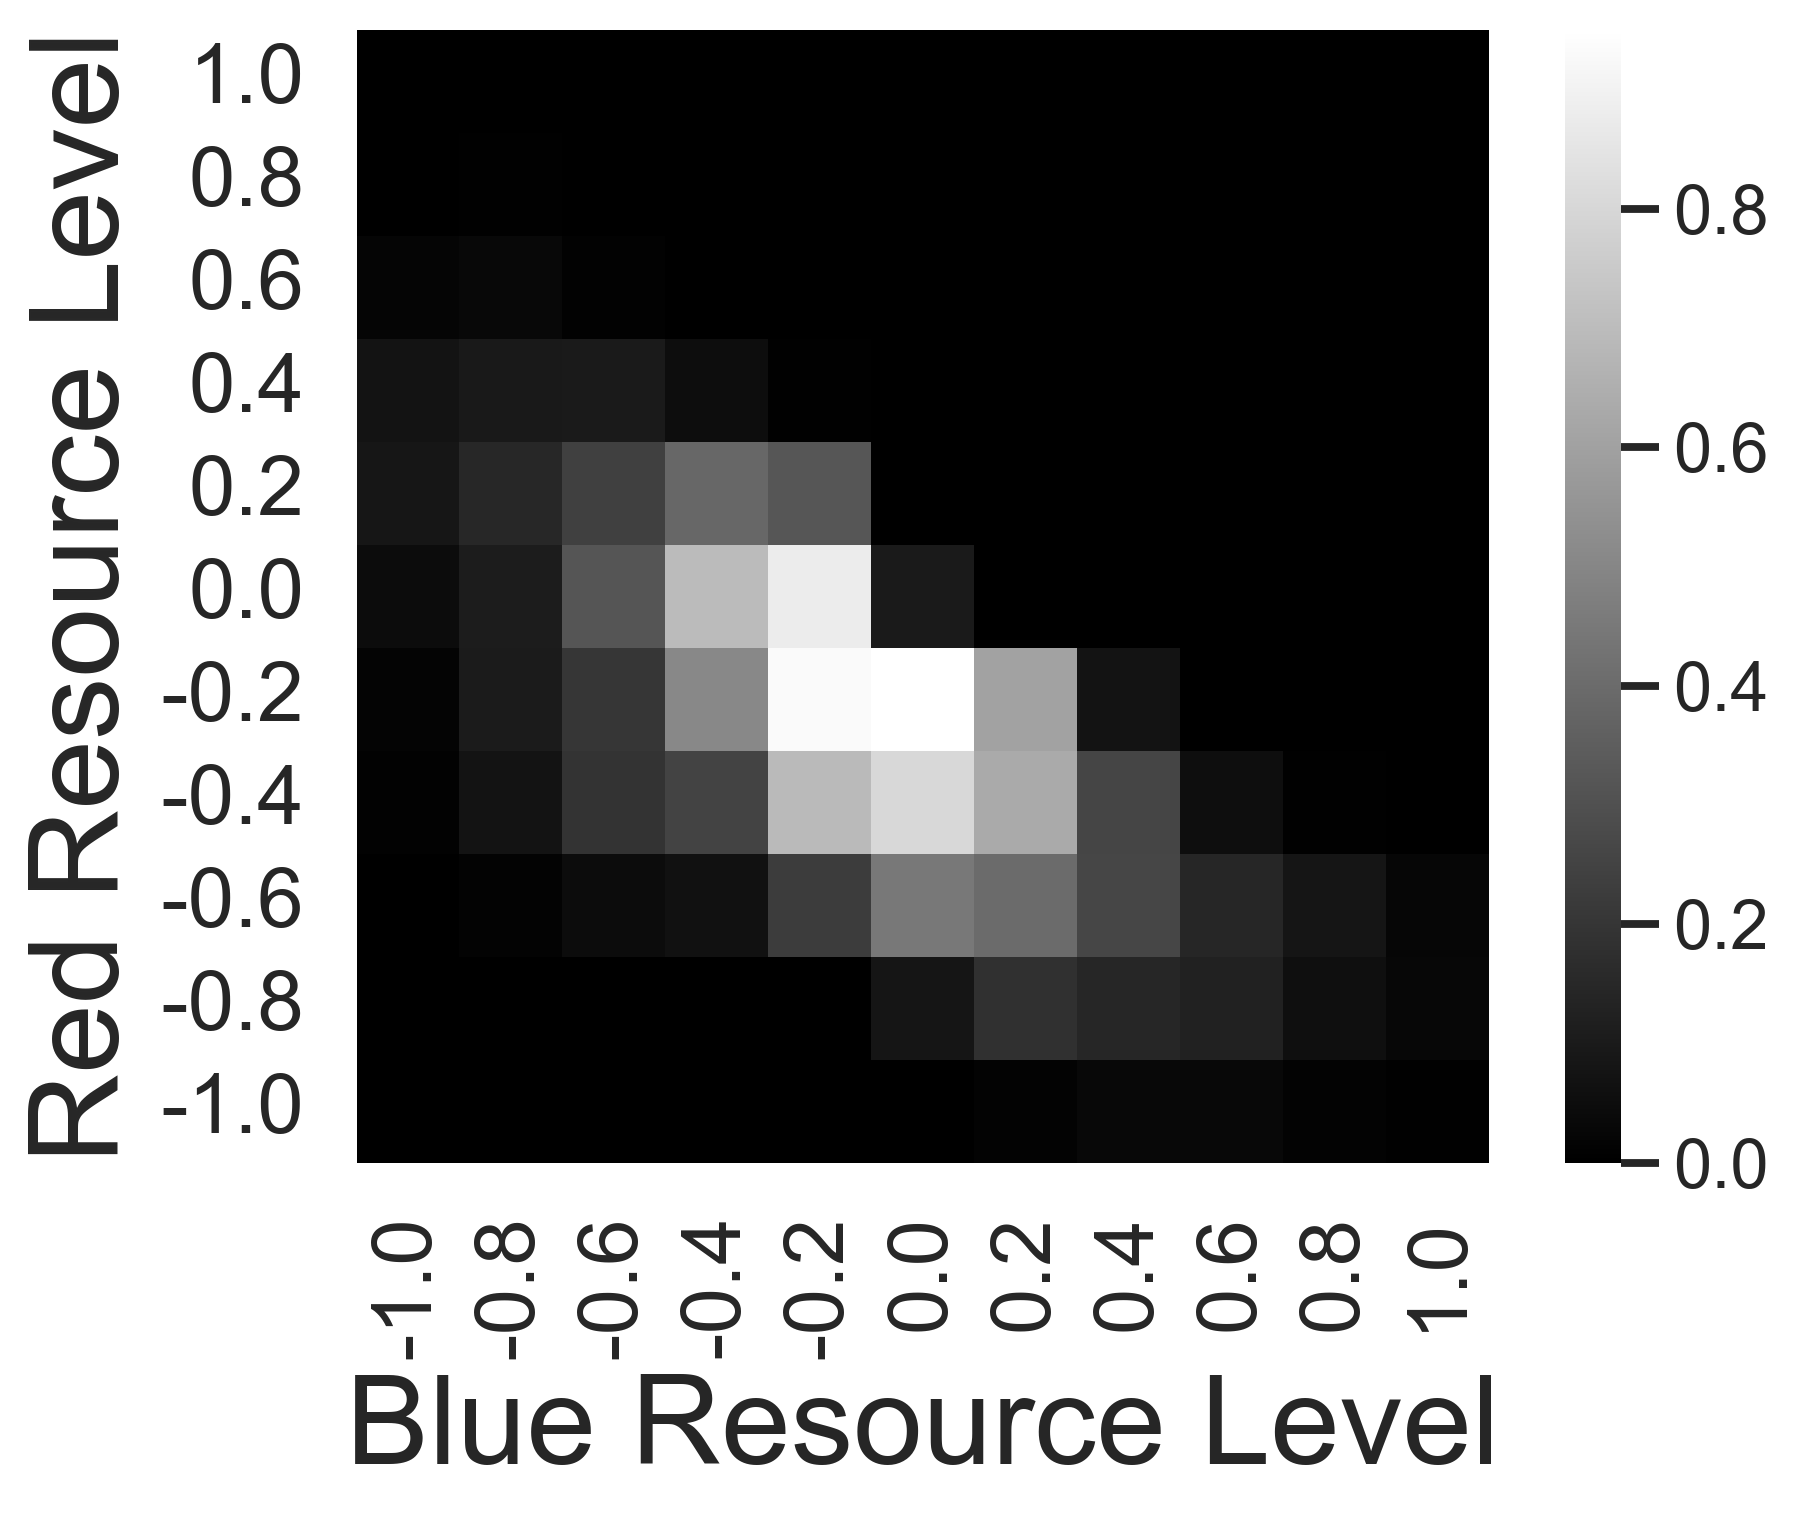

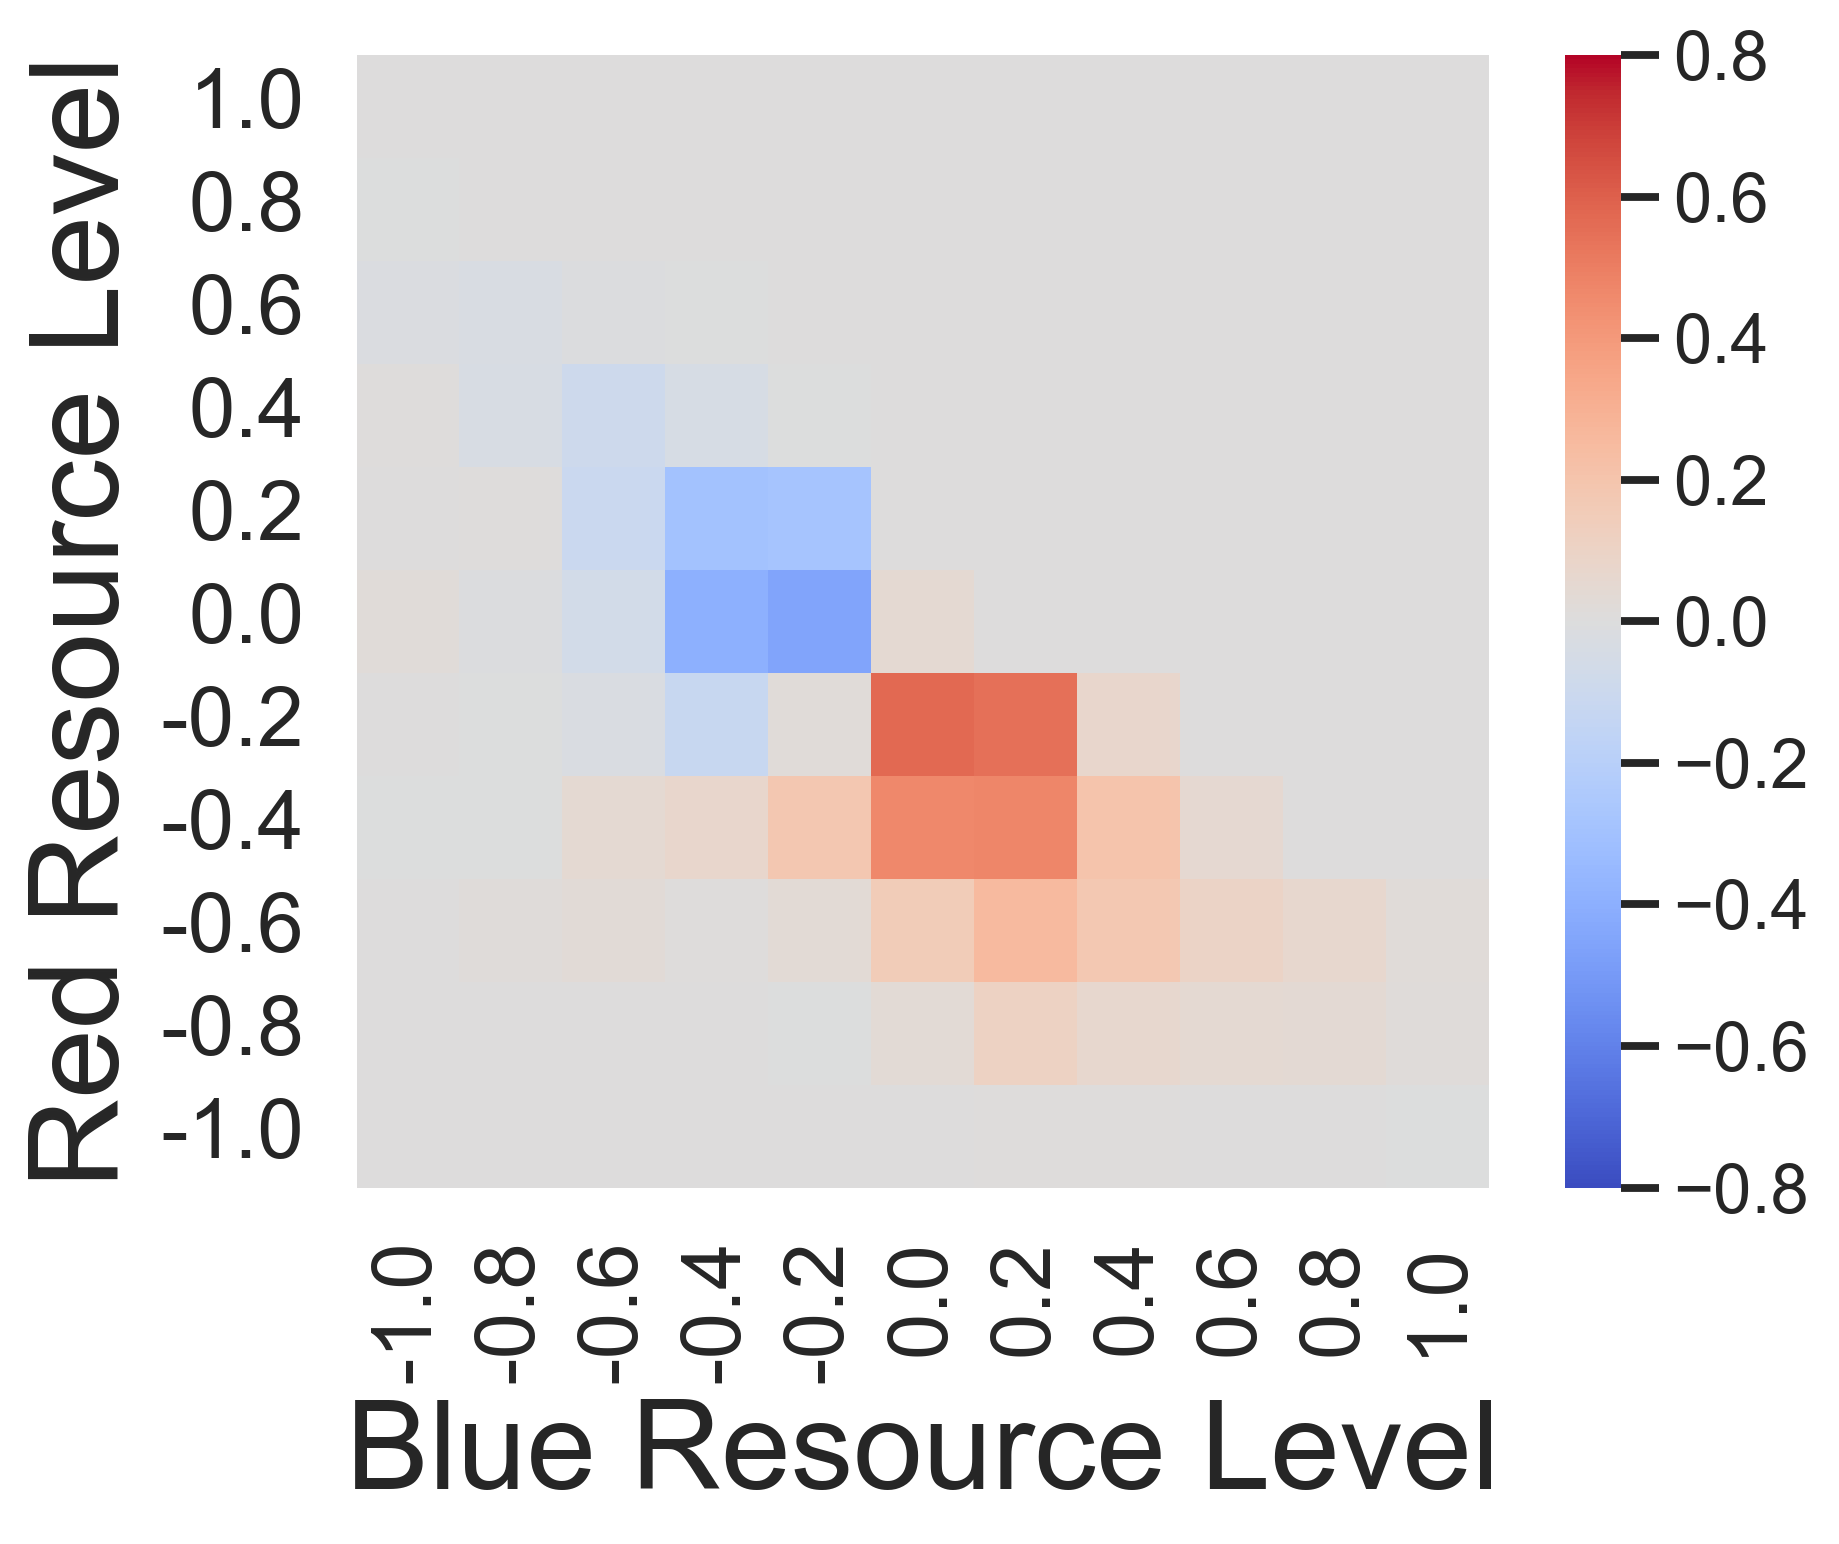

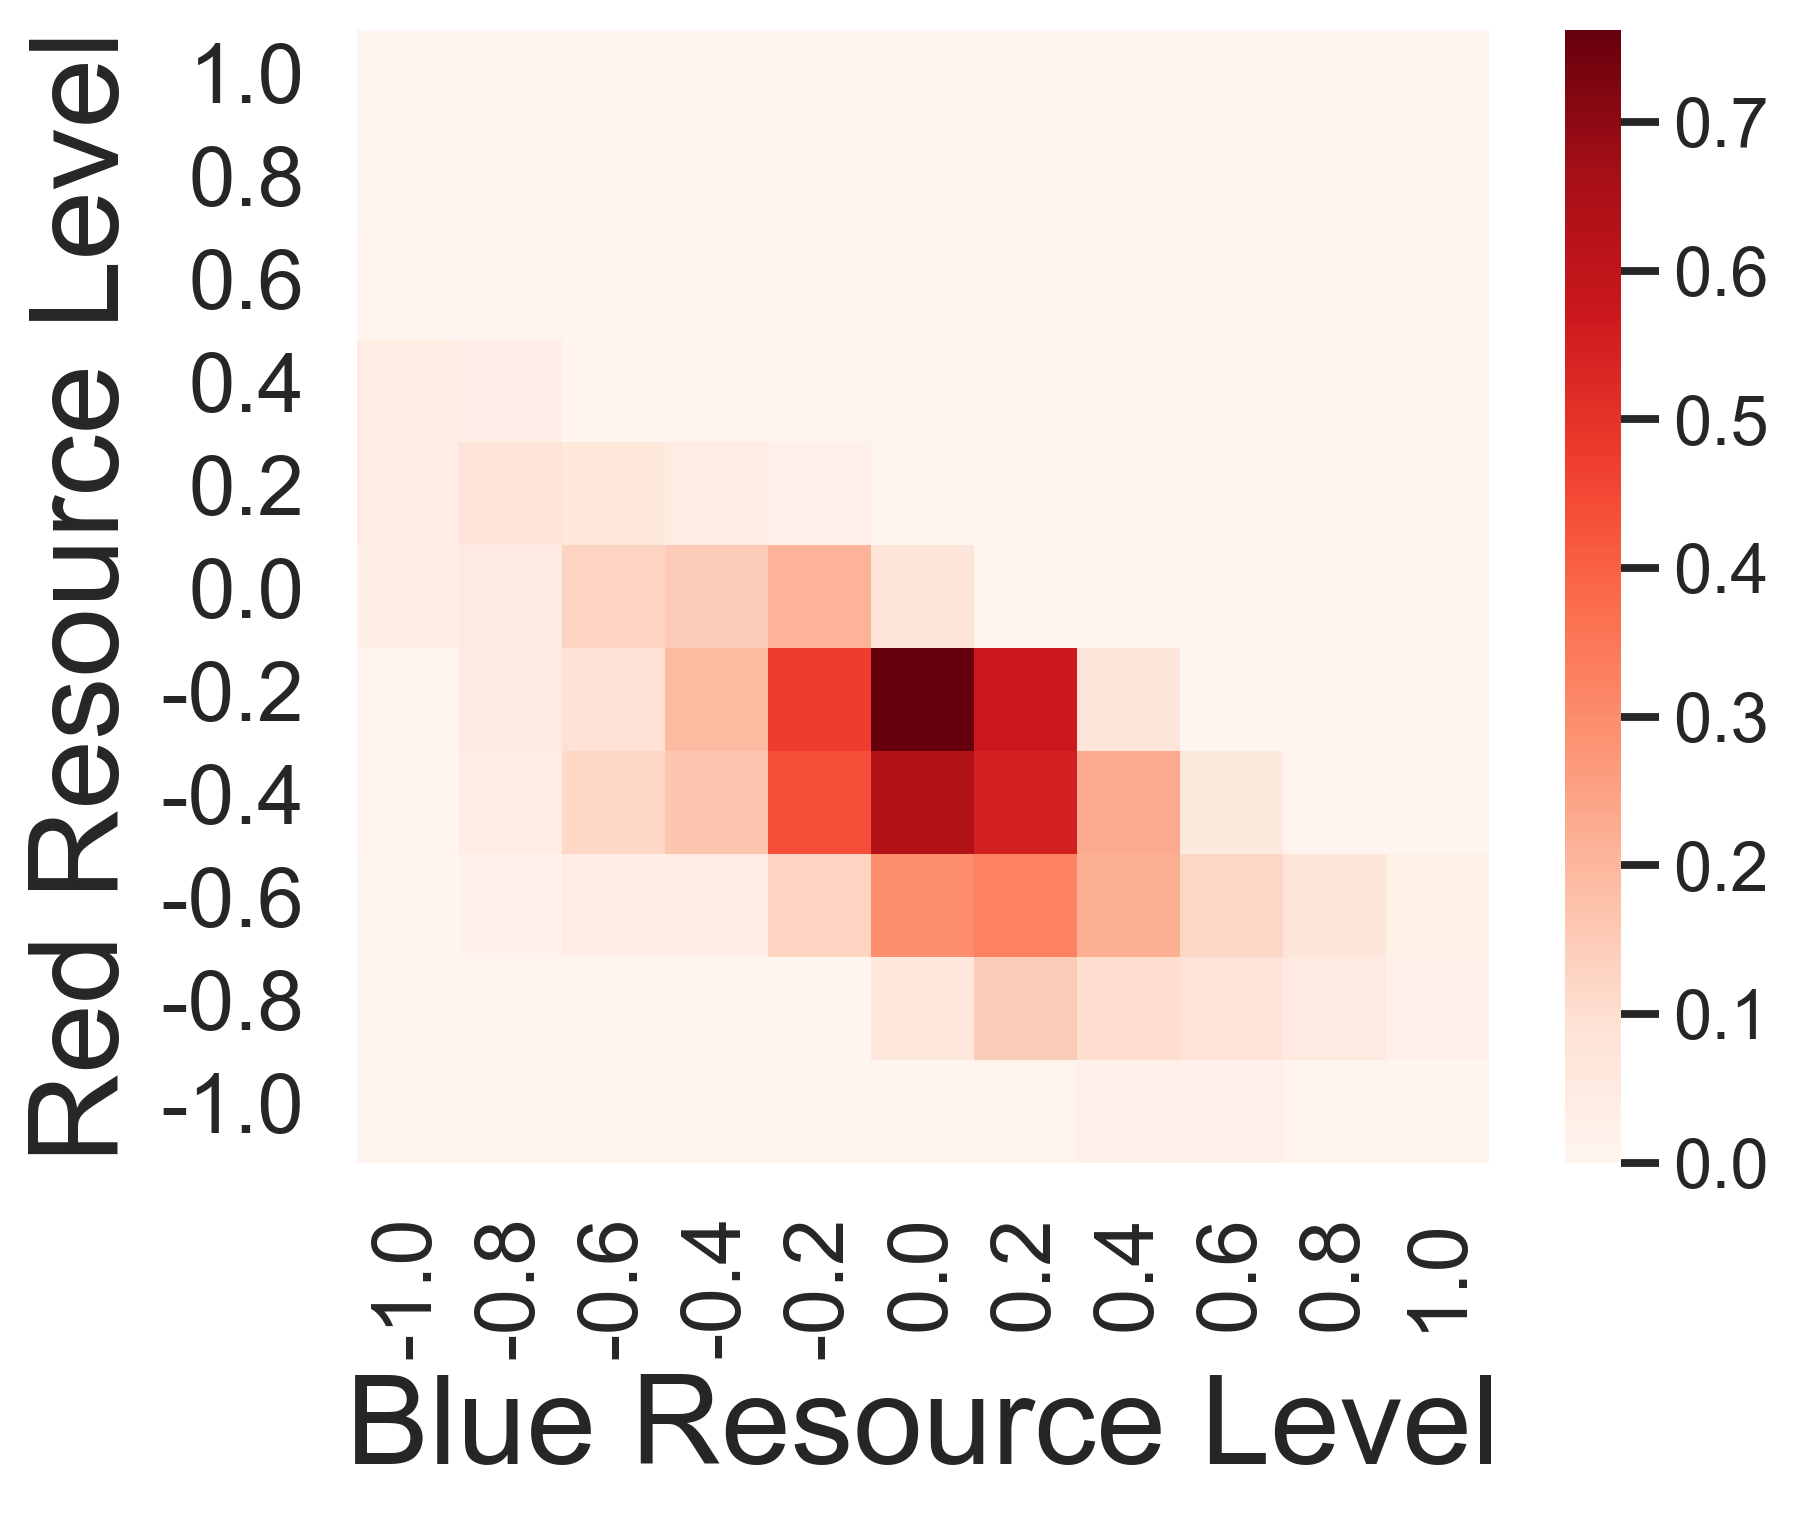

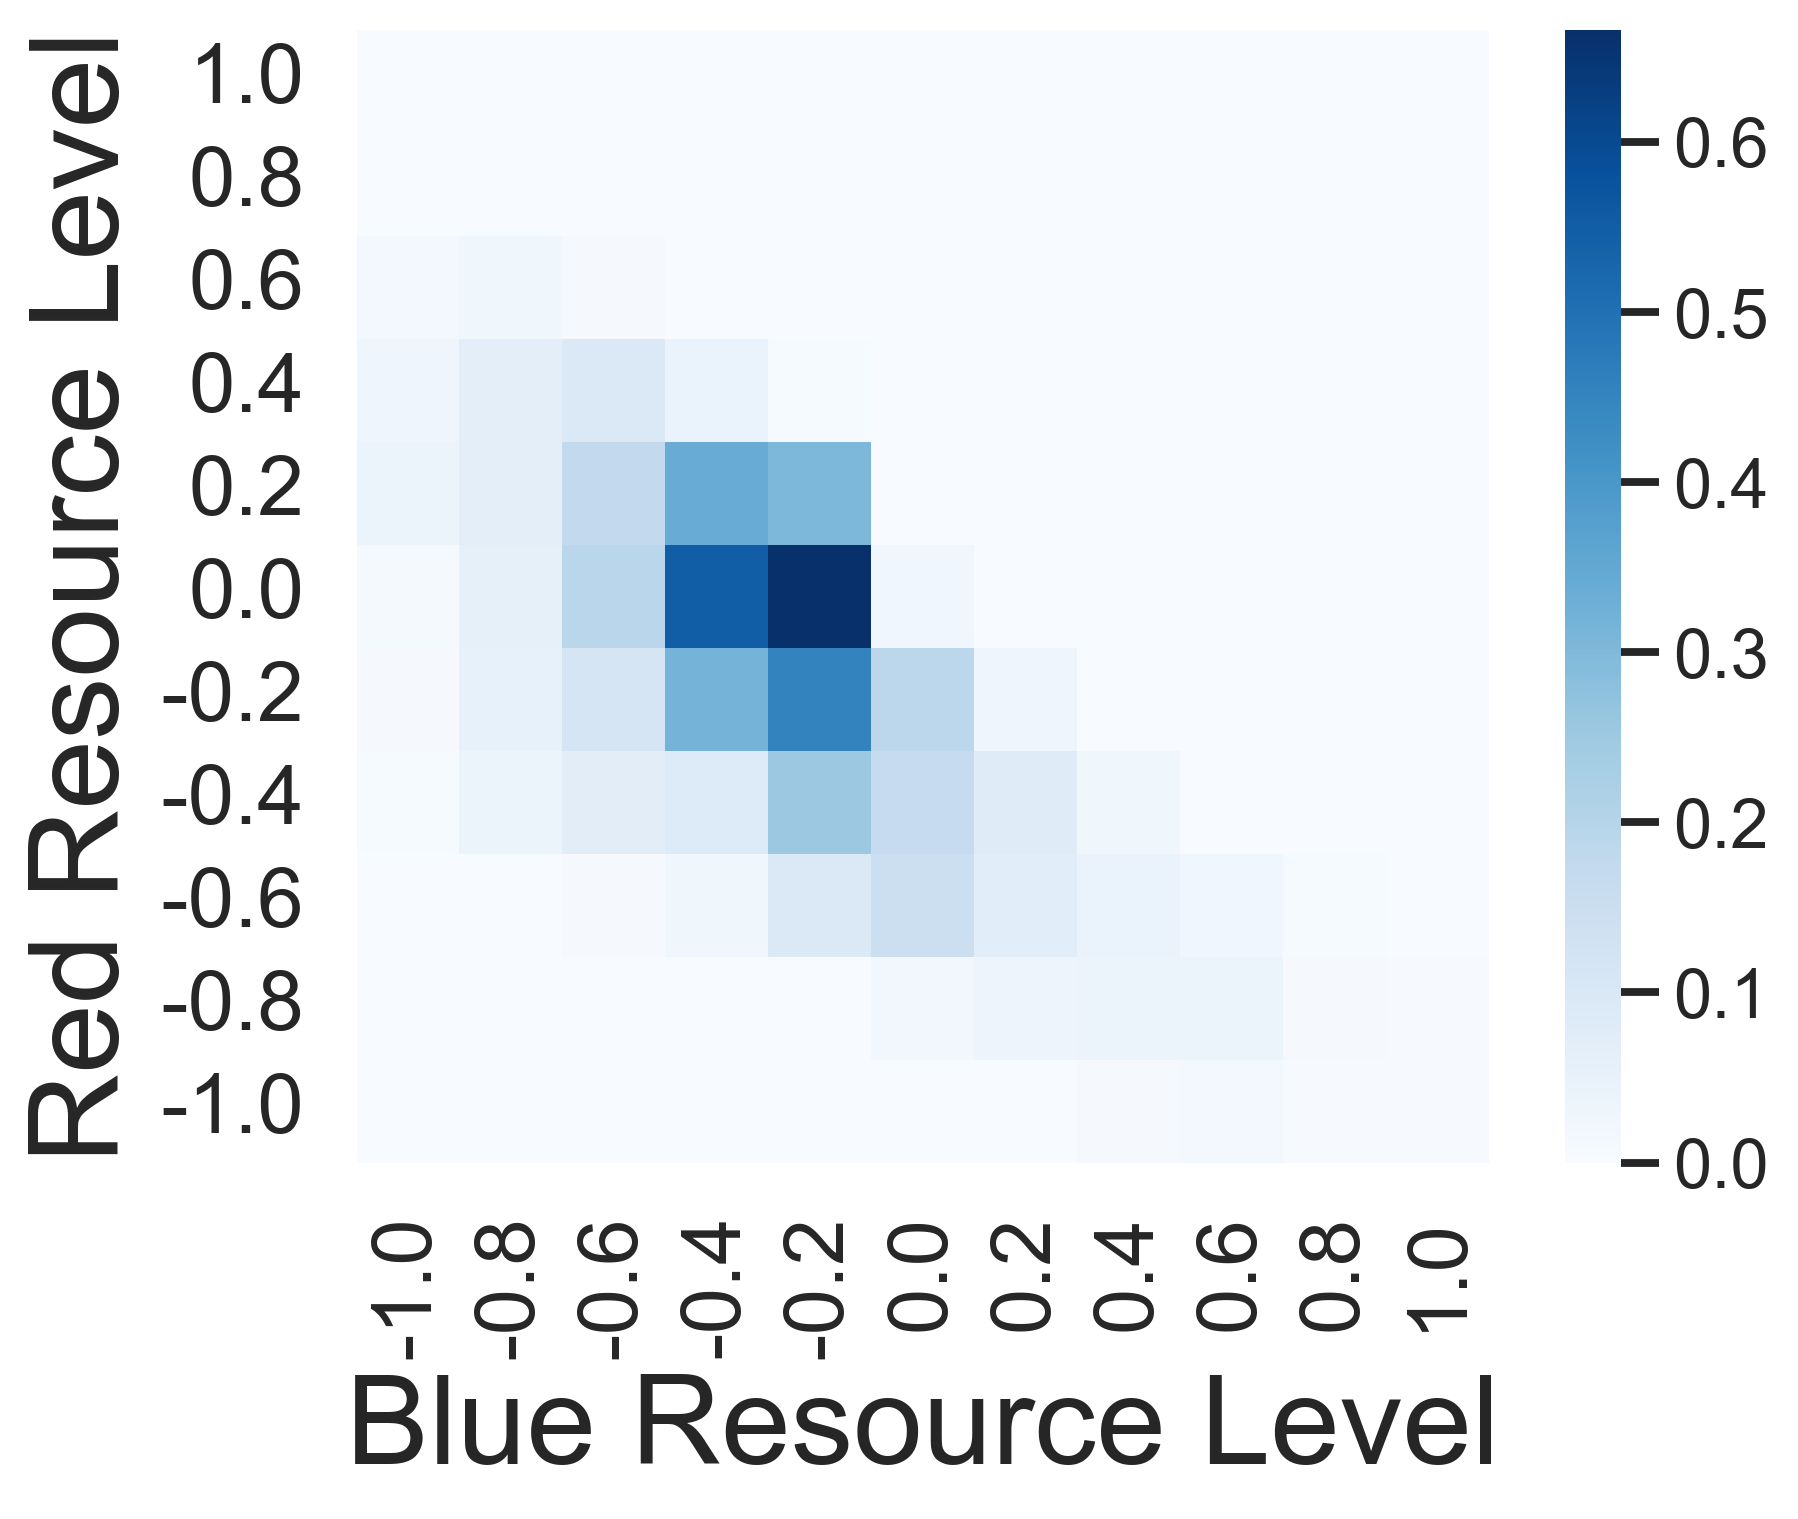

In [5]:
sns.set_context("talk")


plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix_ave_6x4_full.mean(axis=0) + data_blue_matrix_ave_6x4_full.mean(axis=0)).transpose(),
                 cmap="binary_r",
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)
ax.invert_yaxis()

plt.savefig("ba_collection_average_6x4_full.png", bbox_inches='tight')



plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix_ave_6x4_full.mean(axis=0) - data_blue_matrix_ave_6x4_full.mean(axis=0)).transpose(),
                 cmap='coolwarm',
                 center=0,
                 vmin=-0.8,
                 vmax=0.8,
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("ba_ratio_average_6x4_full.png", bbox_inches='tight')



plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap(data_red_matrix_ave_6x4_full.mean(axis=0).transpose(),
                 cmap="Reds", #"binary_r",
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("red_matrix_average_6x4_full.png", bbox_inches='tight')
plt.show()



plt.figure(figsize=(6.5, 5), dpi=300)
ax =sns.heatmap(data_blue_matrix_ave_6x4_full.mean(axis=0).transpose(),
                cmap="Blues", #"binary_r",
                square=True,
                xticklabels=blue_ticks.round(2),
                yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("blue_matrix_average_6x4_full.png", bbox_inches='tight')


plt.show()

## 5x5 agents

In [5]:
data_red_matrix_ave_5x5 = []
data_blue_matrix_ave_5x5 = []

path = [
    "tmp/trp5x5/trp5x5-homeostatic_shaped2021-10-19-12-50-09",
    "tmp/trp5x5/trp5x5-homeostatic_shaped2021-10-20-23-46-39",
    "tmp/trp5x5/trp5x5-homeostatic_shaped2021-10-22-11-00-34",
    "tmp/trp5x5/trp5x5-homeostatic_shaped2021-10-24-00-08-08",
    "tmp/trp5x5/trp5x5-homeostatic_shaped2021-10-25-18-32-02"
]

for fn in path:
    p = Path(fn)
    
    data_red_matrix_ave_5x5.append(np.load(p / "data_matrices_red_5x5.npy"))
    data_blue_matrix_ave_5x5.append(np.load(p / "data_matrices_blue_5x5.npy"))
    
data_red_matrix_ave_5x5 = np.array(data_red_matrix_ave_5x5)
data_blue_matrix_ave_5x5 = np.array(data_blue_matrix_ave_5x5)

print(data_red_matrix_ave_5x5.shape)
print(data_blue_matrix_ave_5x5.shape)

(5, 11, 11)
(5, 11, 11)


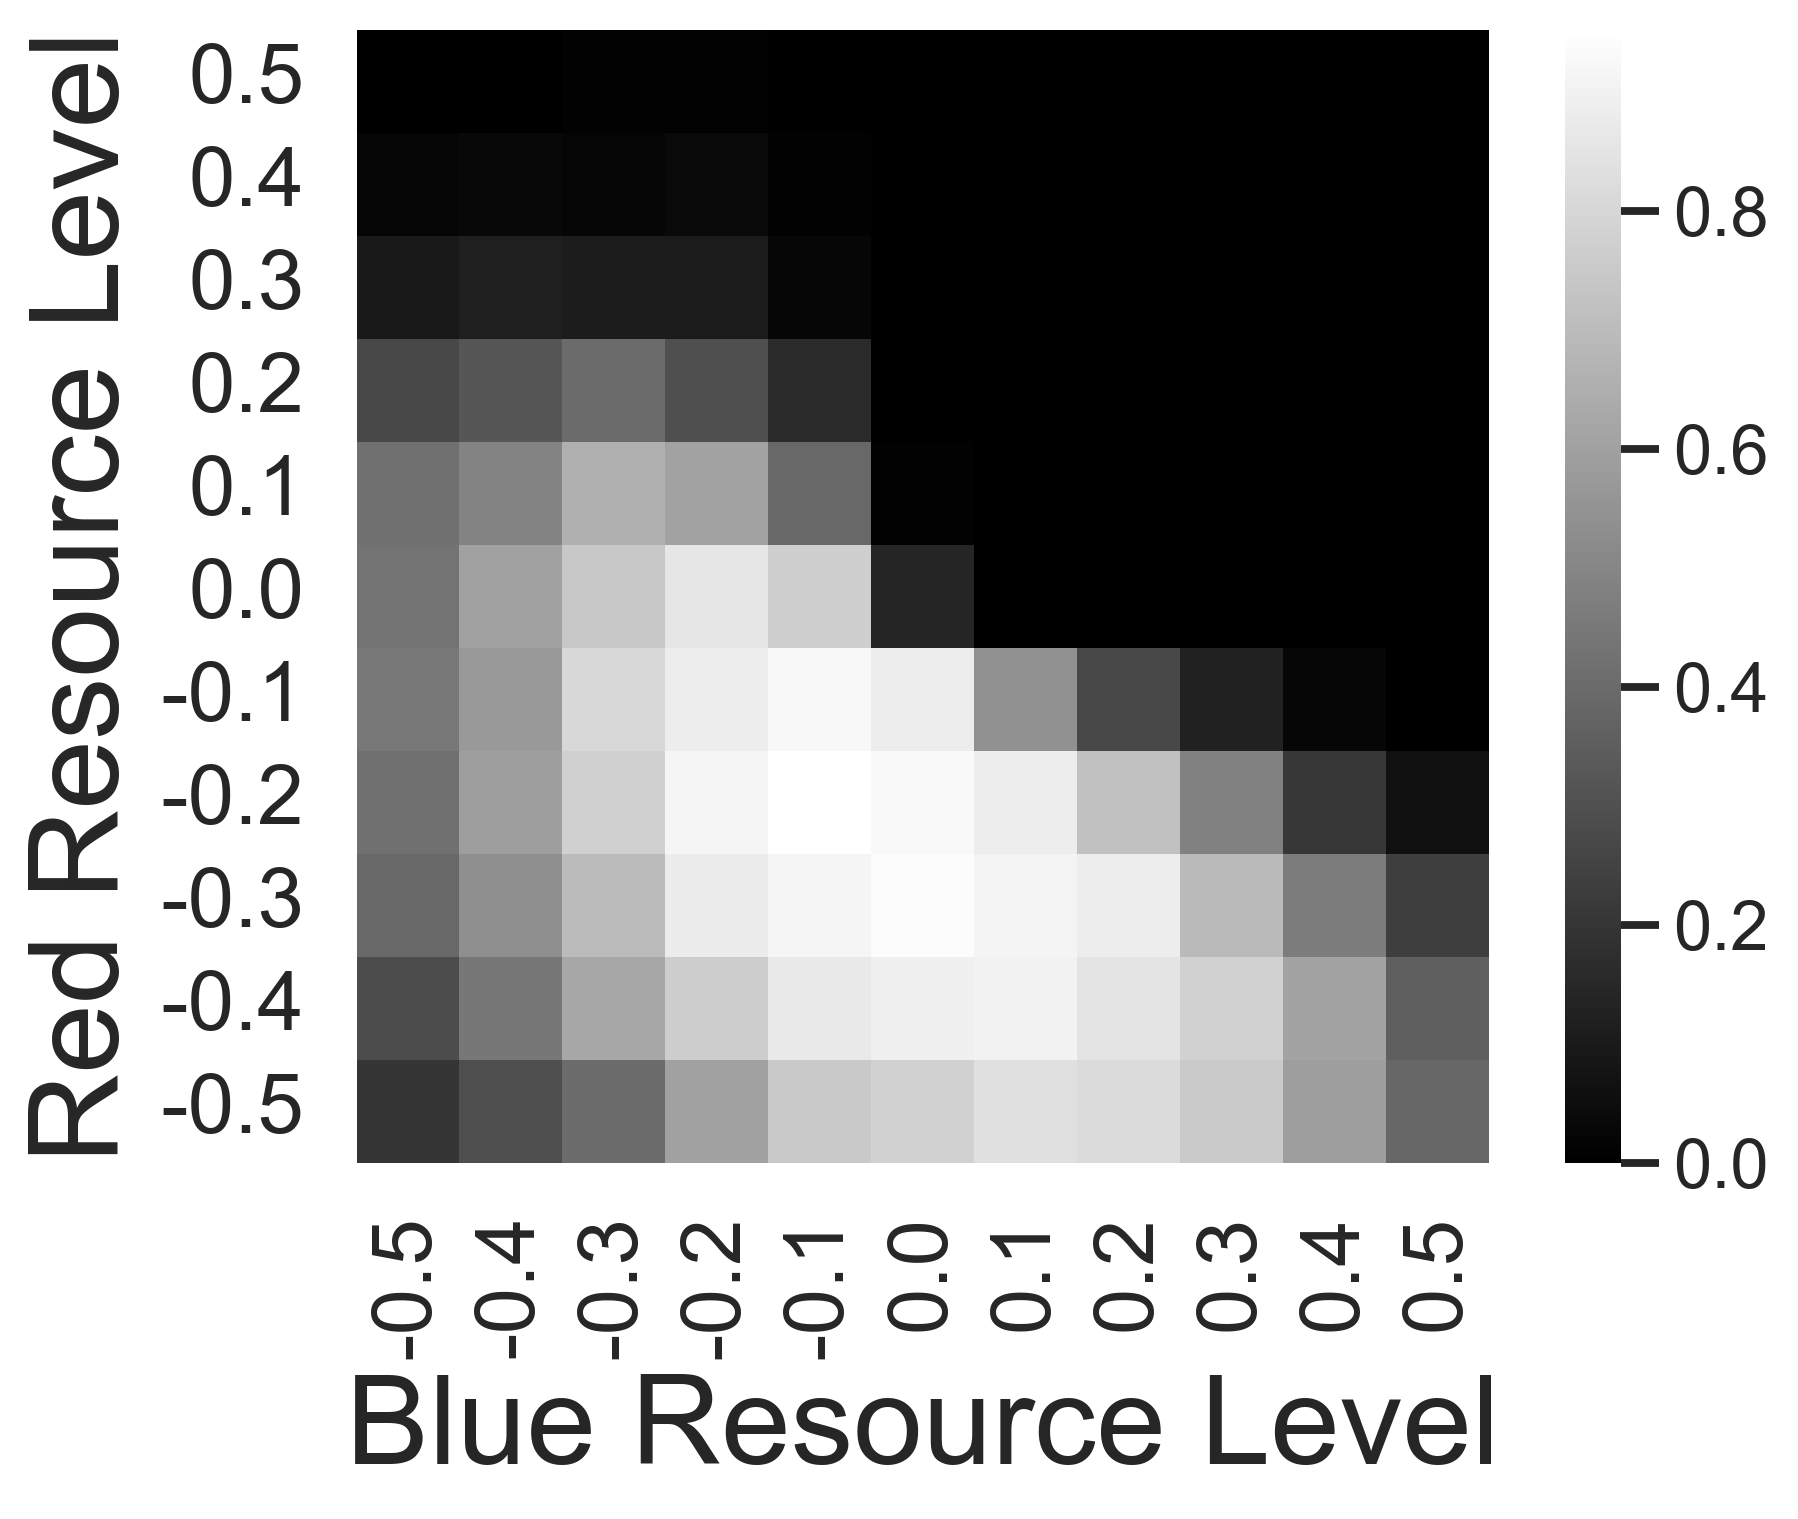

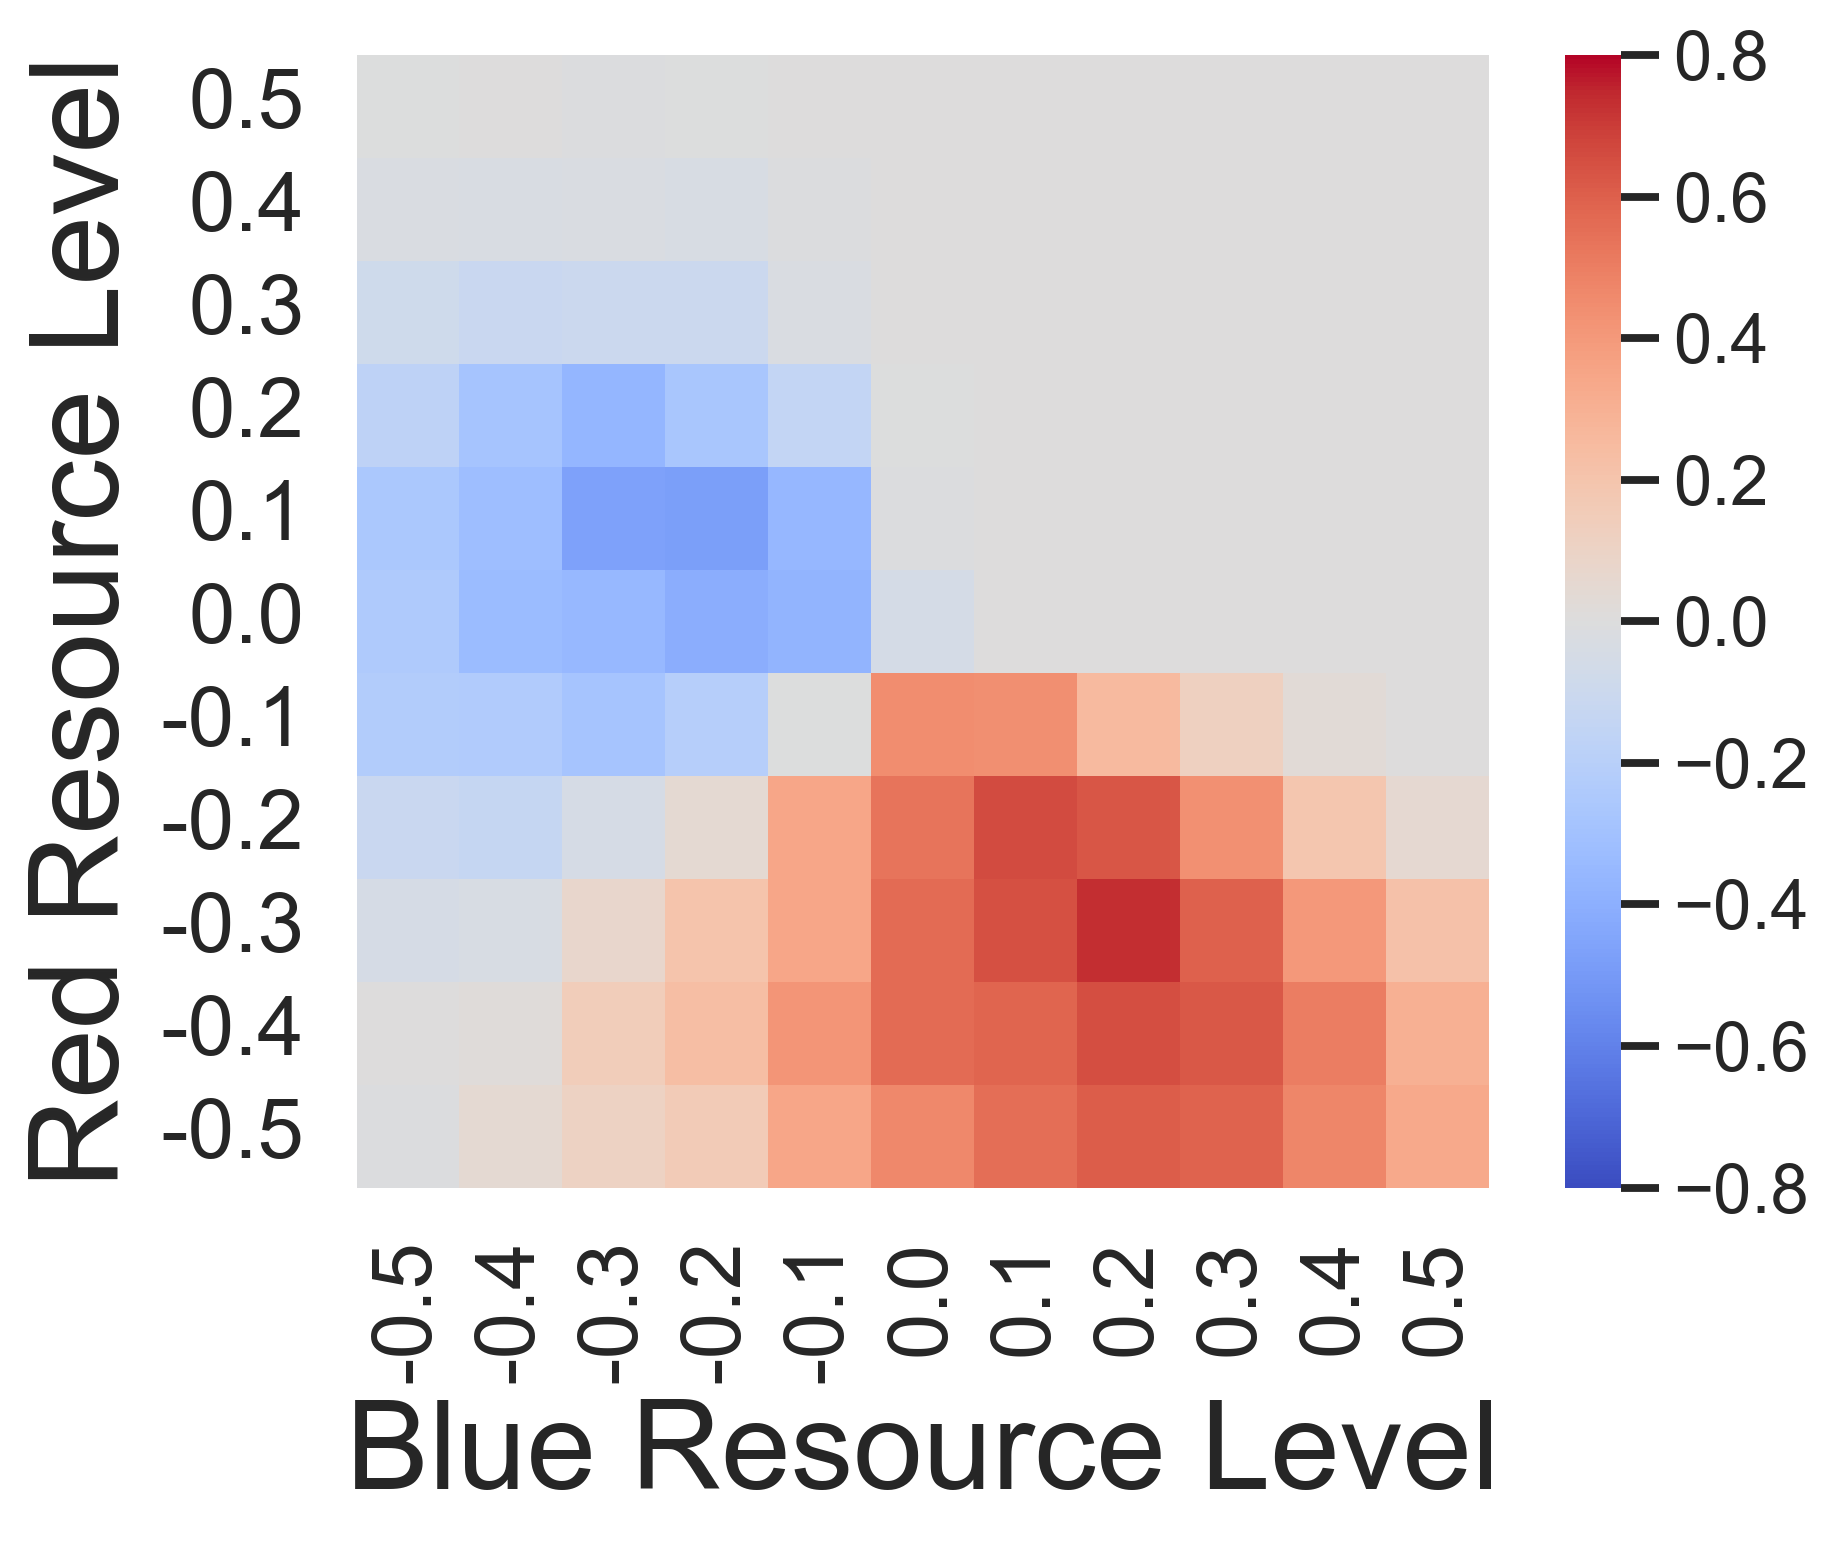

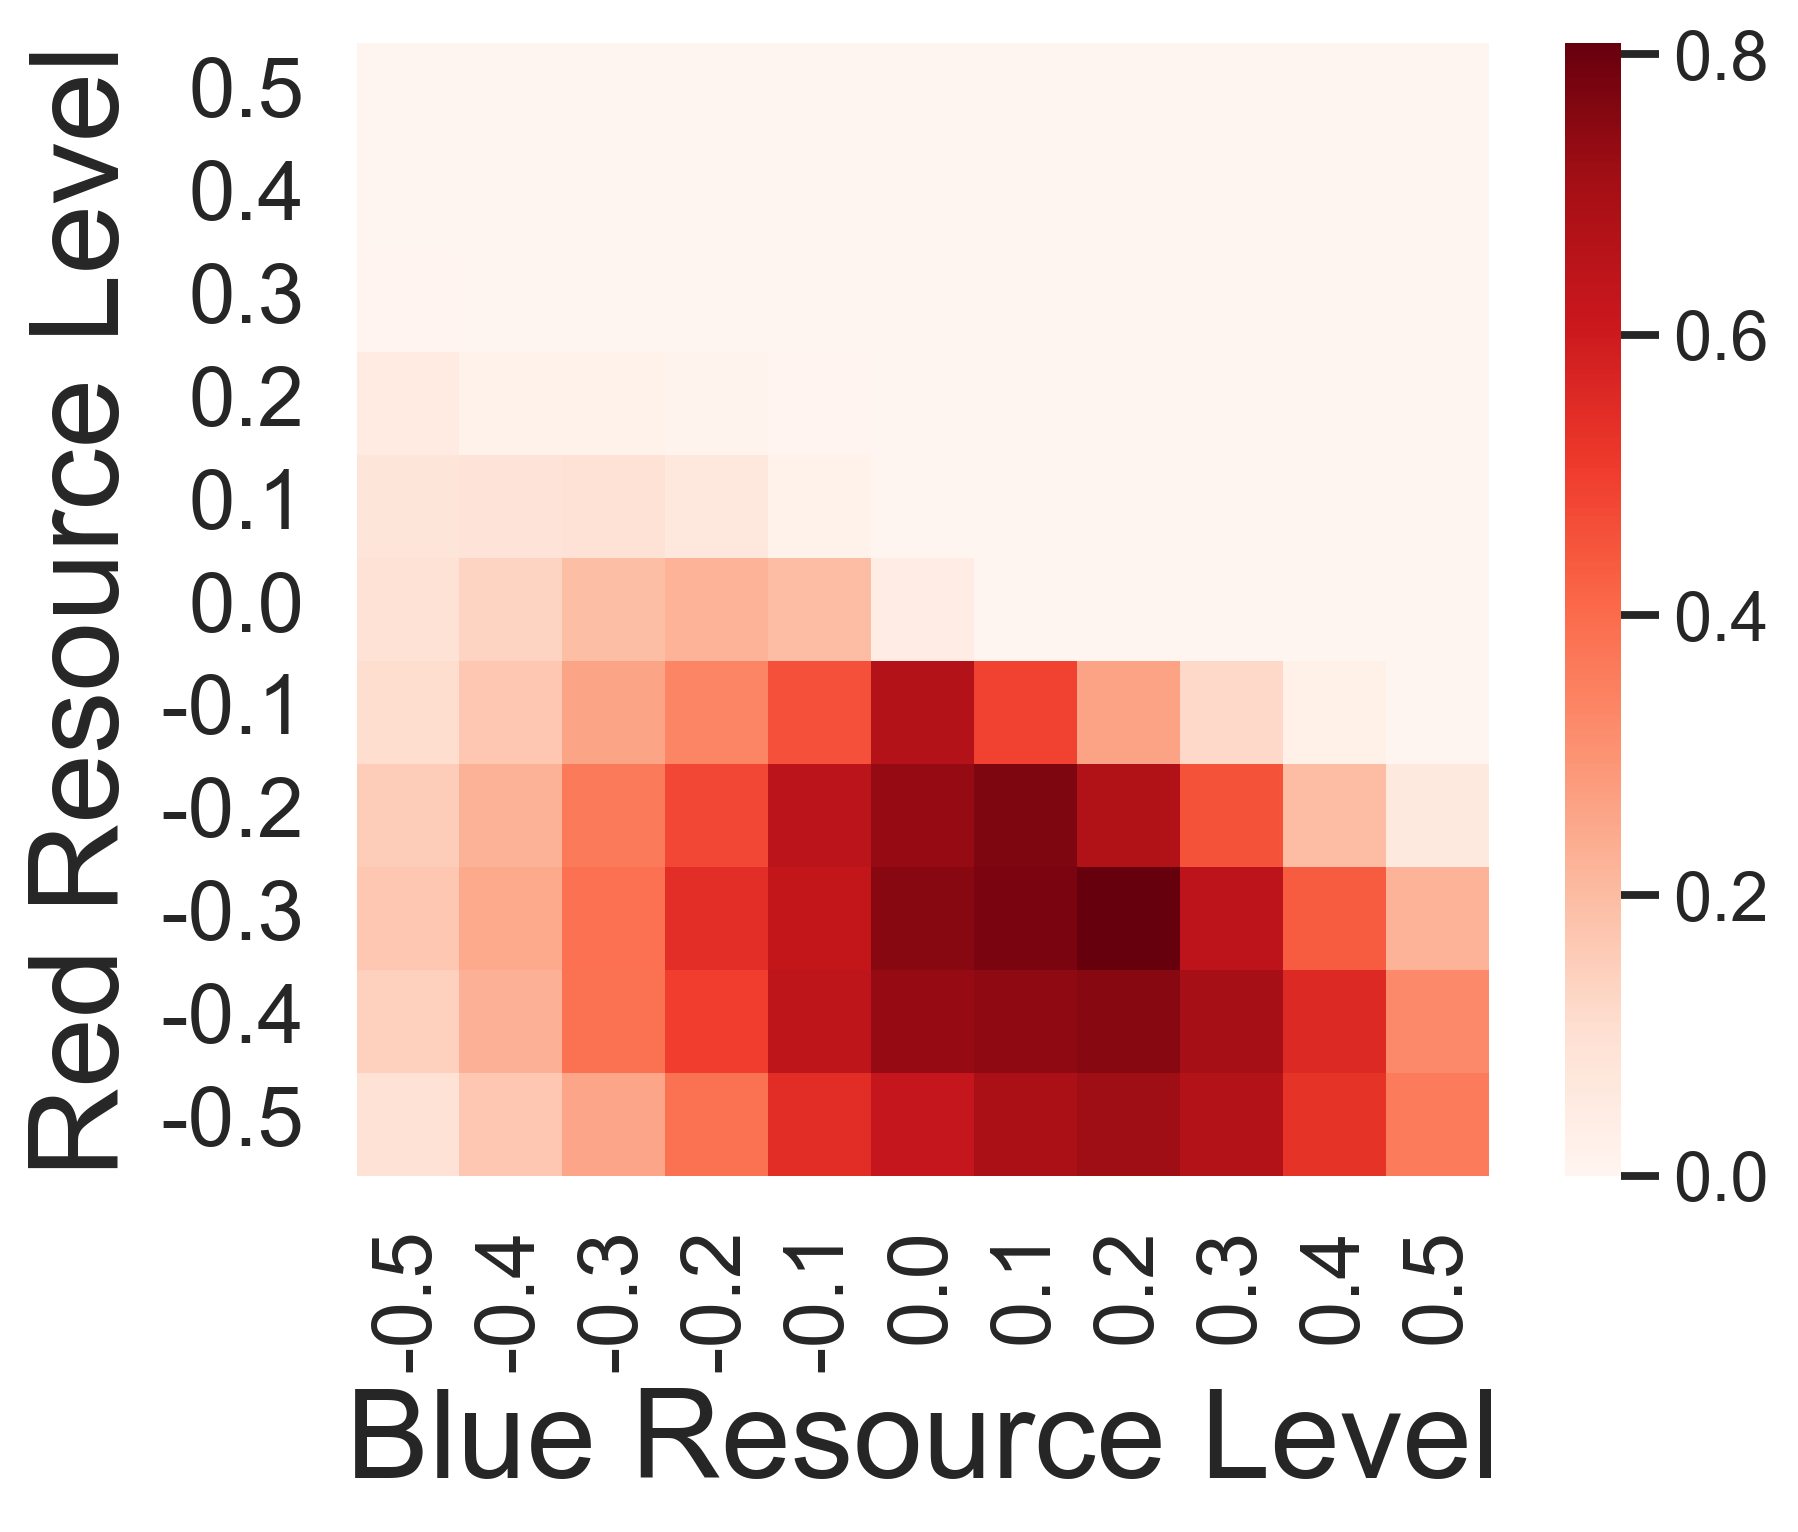

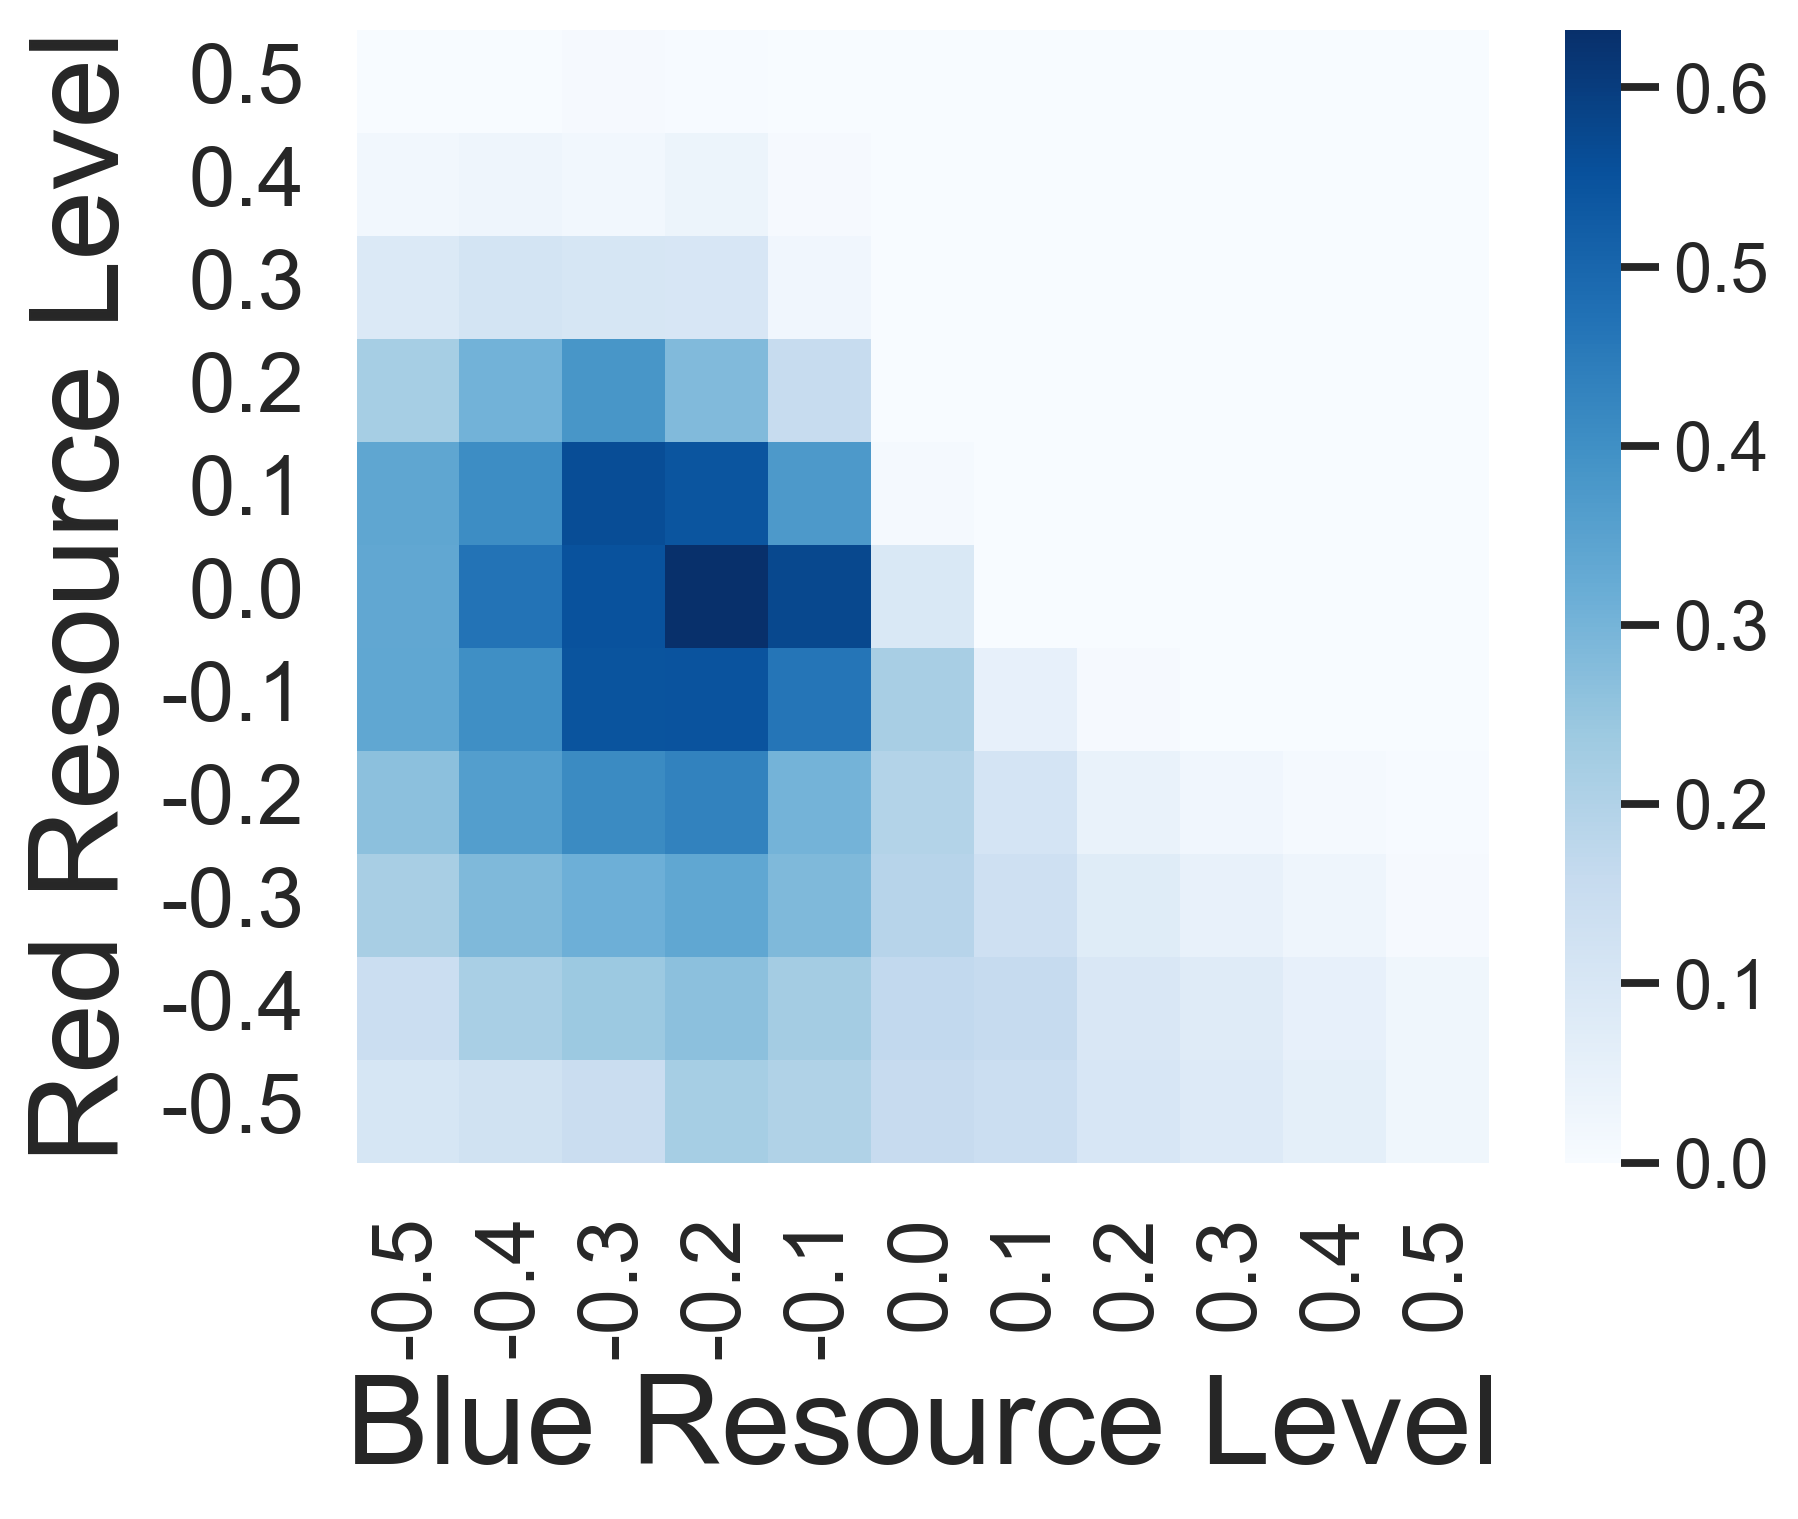

In [7]:
sns.set_context("talk")


plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix_ave_5x5.mean(axis=0) + data_blue_matrix_ave_5x5.mean(axis=0)).transpose(),
                 cmap="binary_r",
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)
ax.invert_yaxis()

plt.savefig("ba_collection_average_5x5.png", bbox_inches='tight')



plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix_ave_5x5.mean(axis=0) - data_blue_matrix_ave_5x5.mean(axis=0)).transpose(),
                 cmap='coolwarm',
                 center=0,
                 vmin=-0.8,
                 vmax=0.8,
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("ba_ratio_average_5x5.png", bbox_inches='tight')



plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap(data_red_matrix_ave_5x5.mean(axis=0).transpose(),
                 cmap="Reds", #"binary_r",
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("red_matrix_average_5x5.png", bbox_inches='tight')
plt.show()



plt.figure(figsize=(6.5, 5), dpi=300)
ax =sns.heatmap(data_blue_matrix_ave_5x5.mean(axis=0).transpose(),
                cmap="Blues", #"binary_r",
                square=True,
                xticklabels=blue_ticks.round(2),
                yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("blue_matrix_average_5x5.png", bbox_inches='tight')


plt.show()

# 8x2 Agent

In [7]:
data_red_matrix_ave_8x2 = []
data_blue_matrix_ave_8x2 = []

for i in range(5):
    p = Path(".")
    
    data_red_matrix_ave_8x2.append(np.load(p / f"data_matrices_red_8x2_{i}.npy"))
    data_blue_matrix_ave_8x2.append(np.load(p / f"data_matrices_blue_8x2_{i}.npy"))
    
data_red_matrix_ave_8x2 = np.array(data_red_matrix_ave_8x2)
data_blue_matrix_ave_8x2 = np.array(data_blue_matrix_ave_8x2)

print(data_red_matrix_ave_8x2.shape)
print(data_blue_matrix_ave_8x2.shape)

(5, 11, 11)
(5, 11, 11)


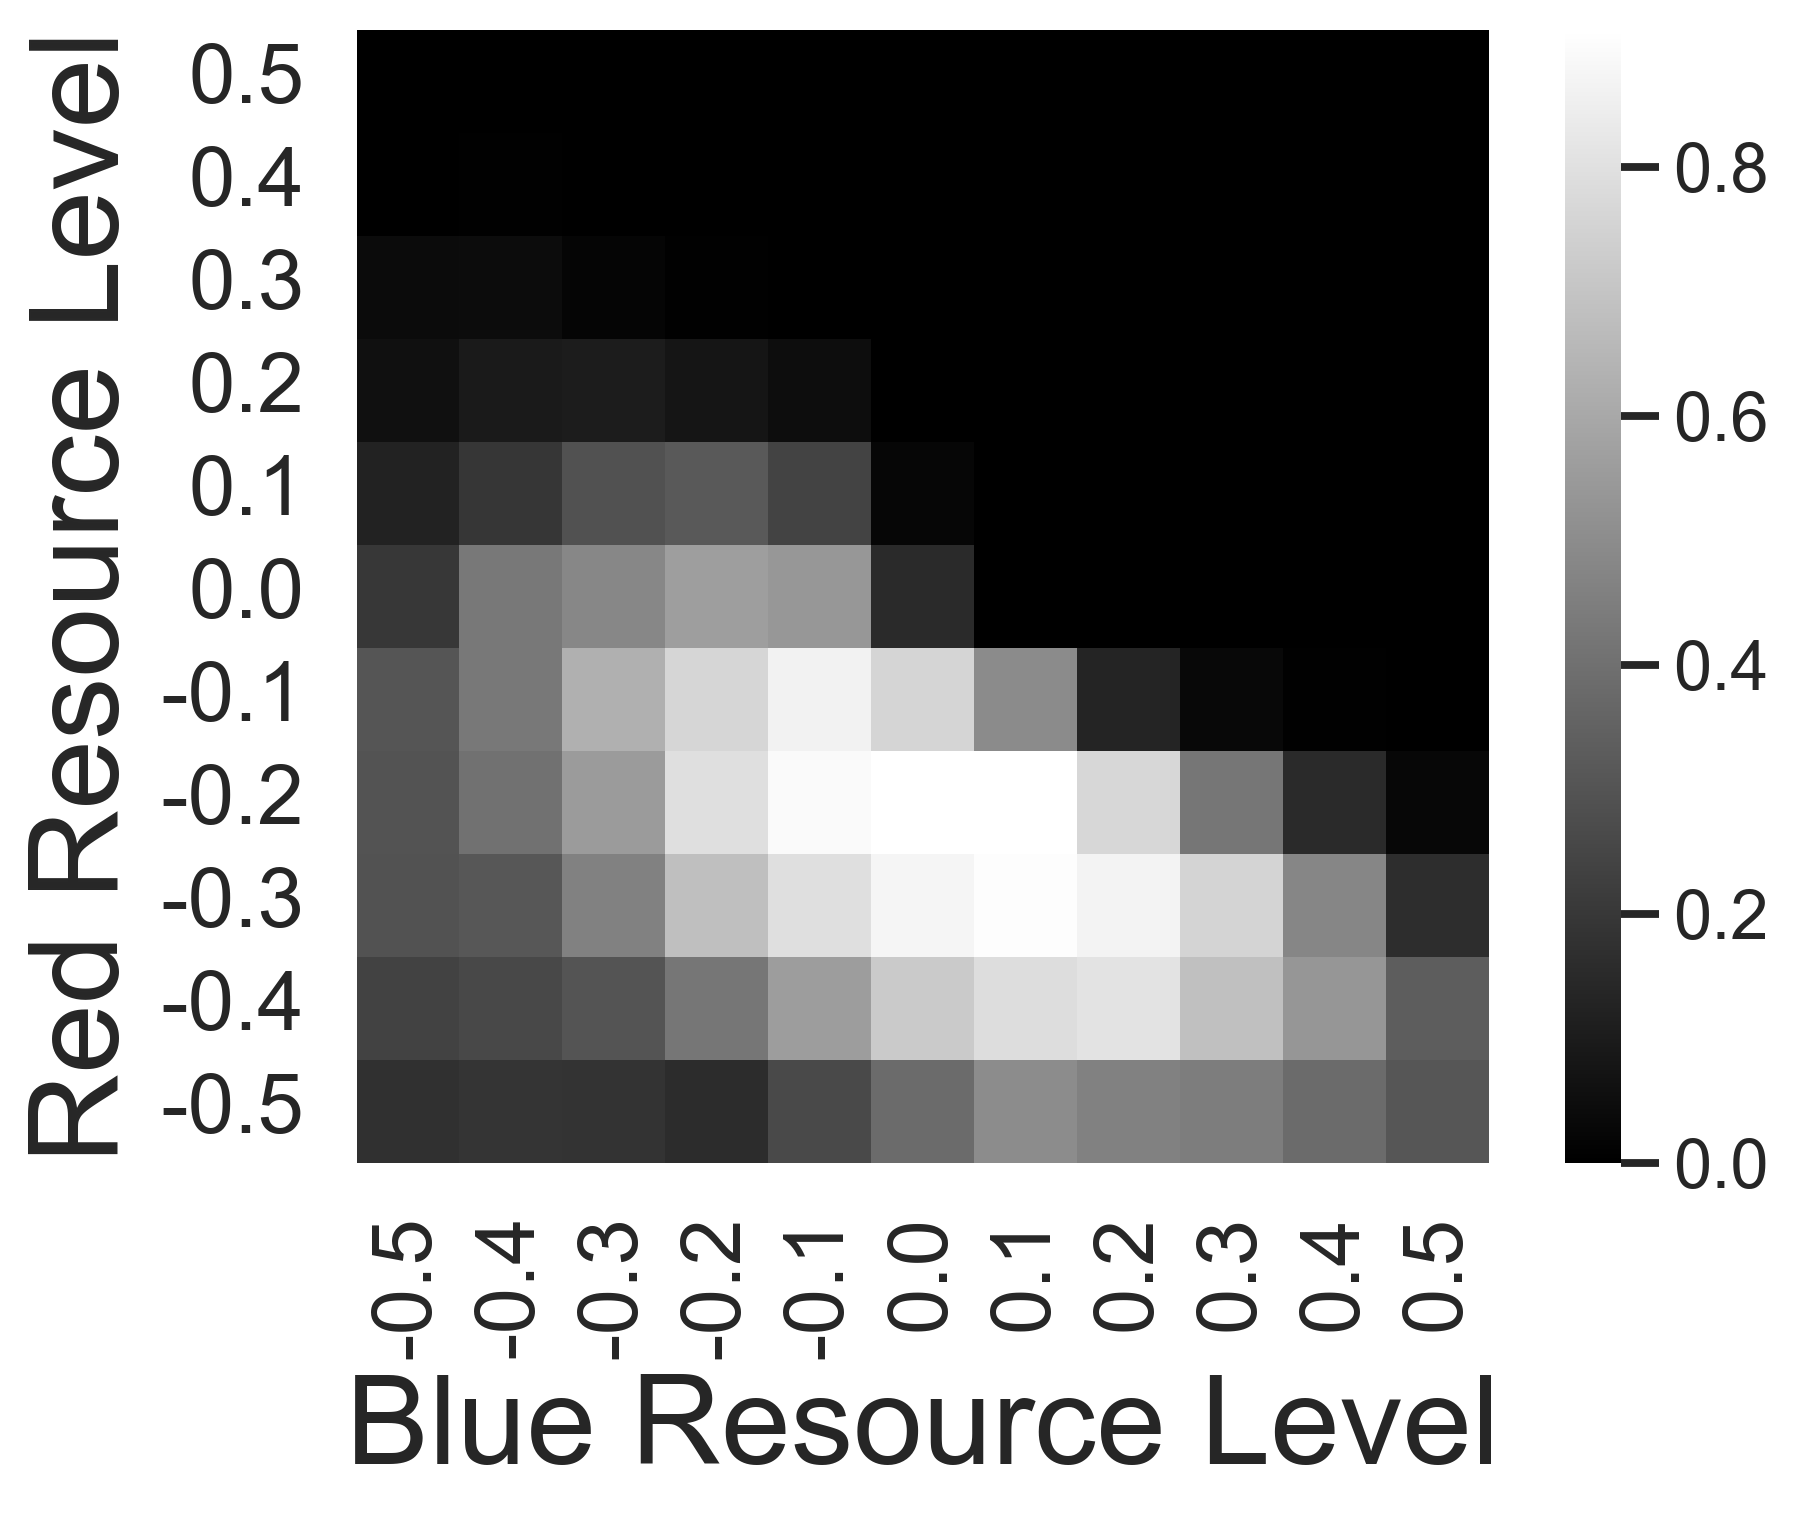

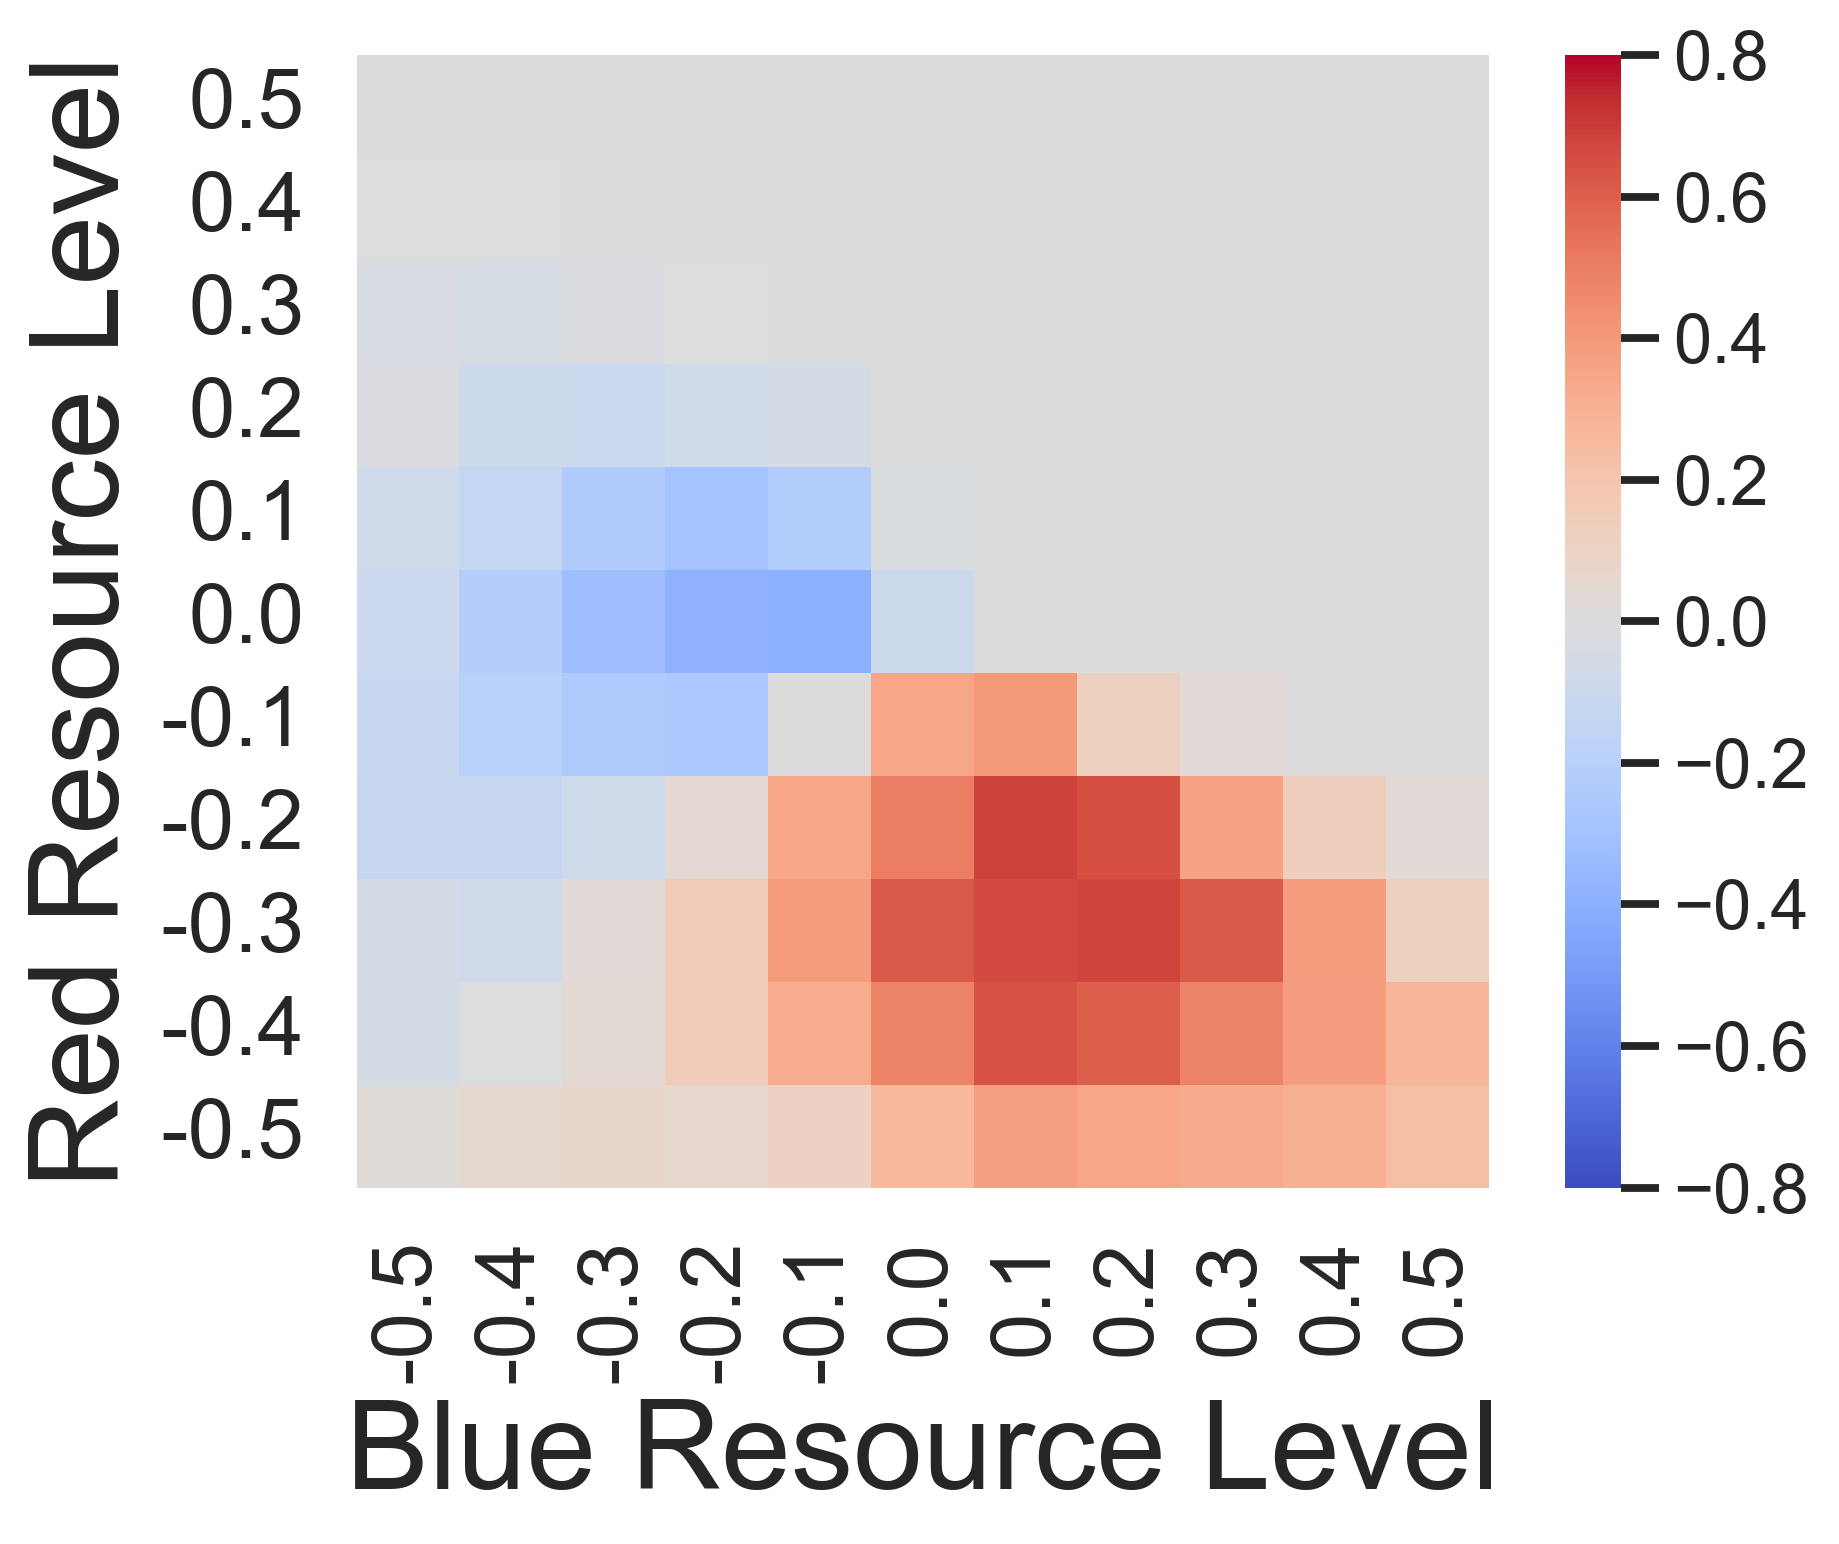

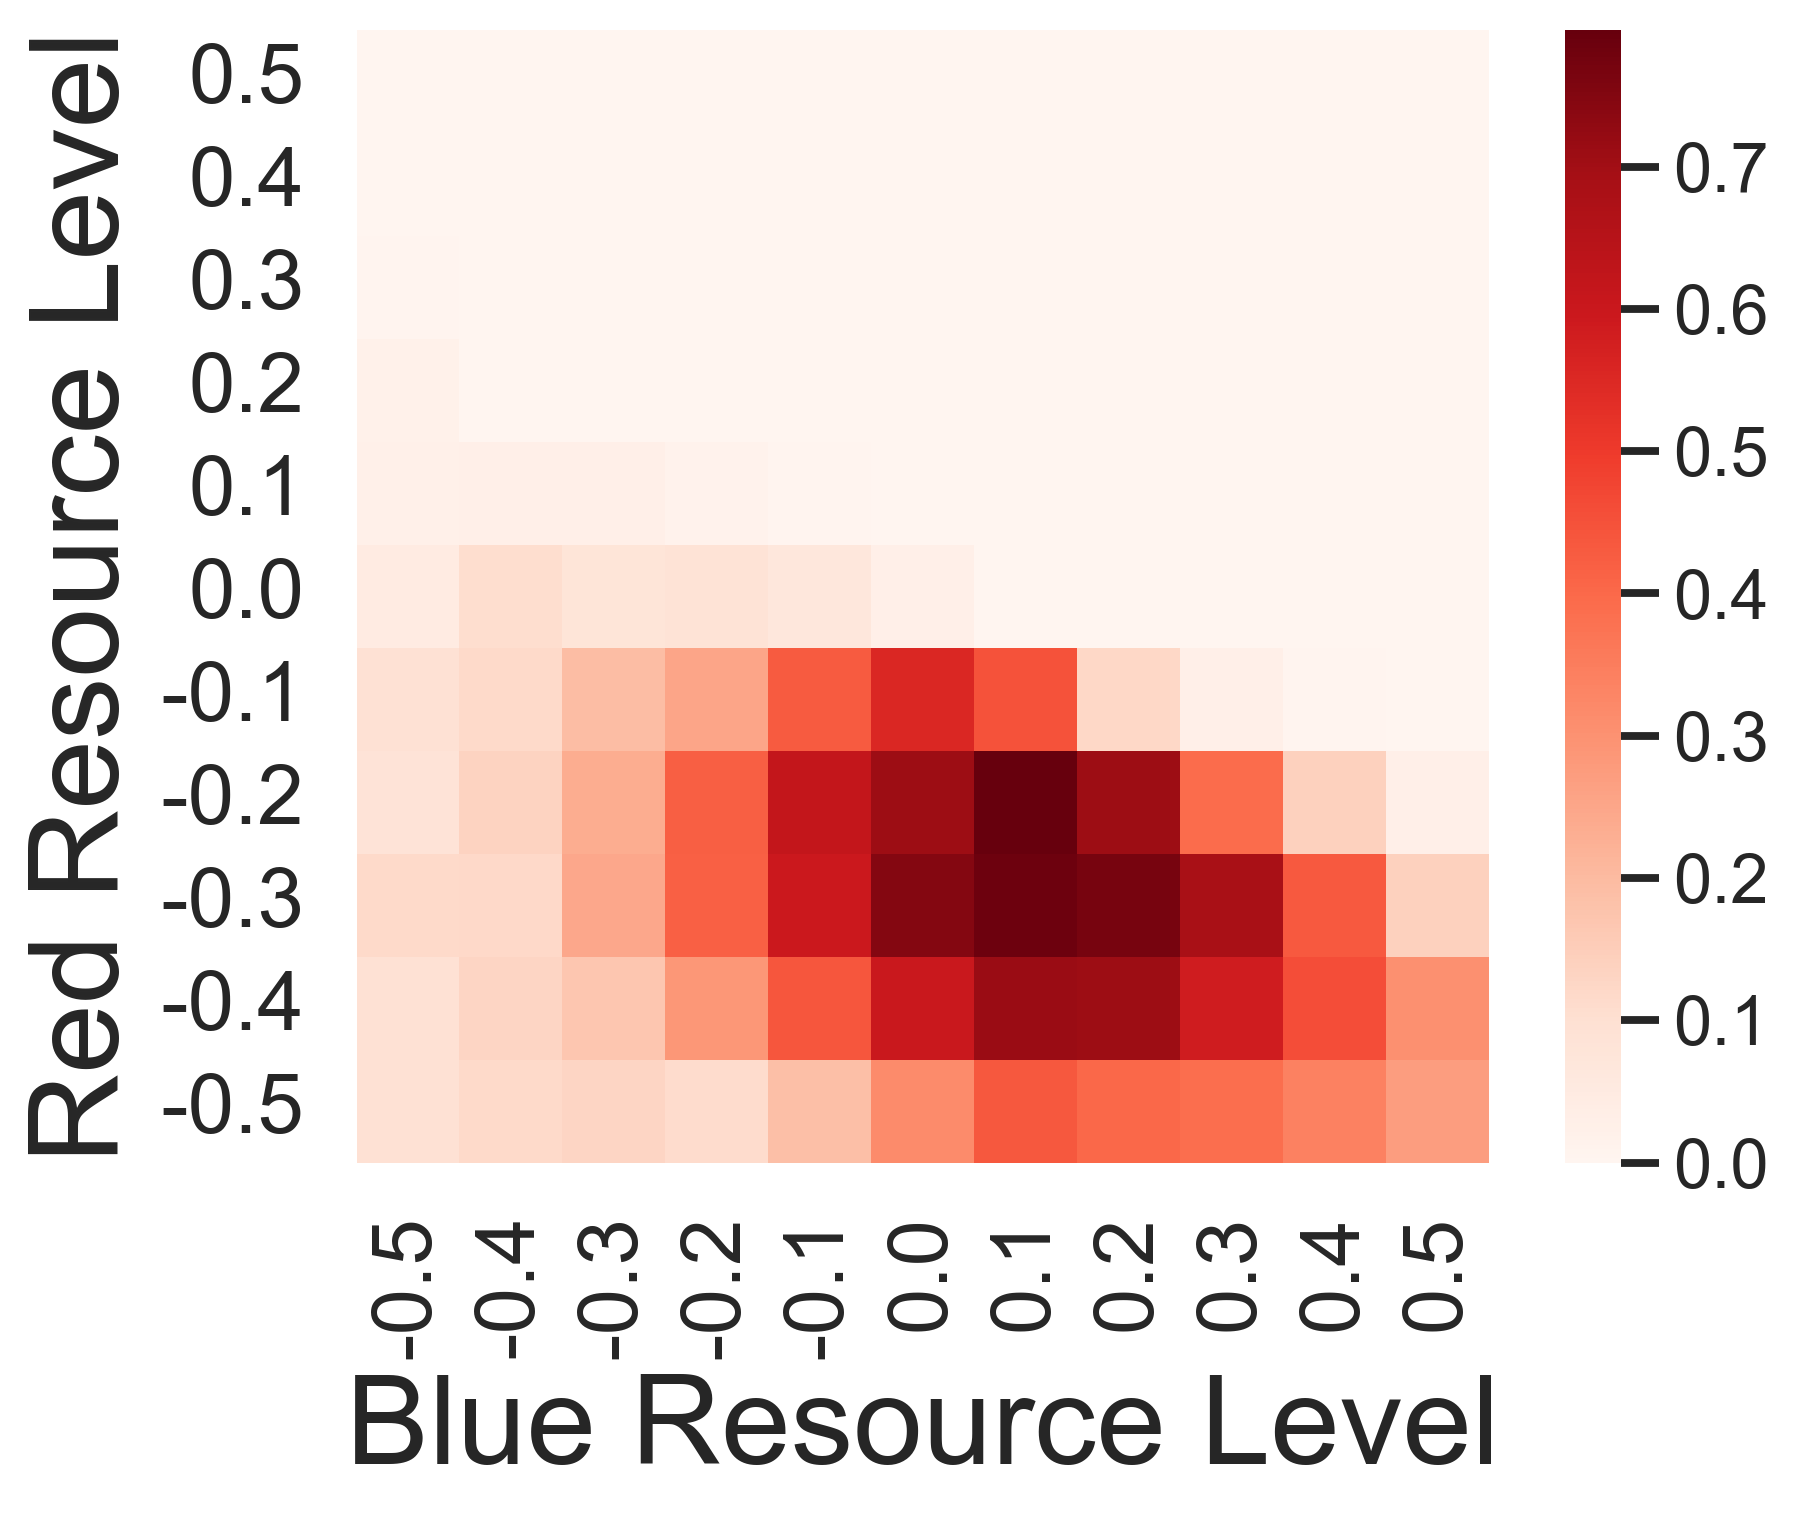

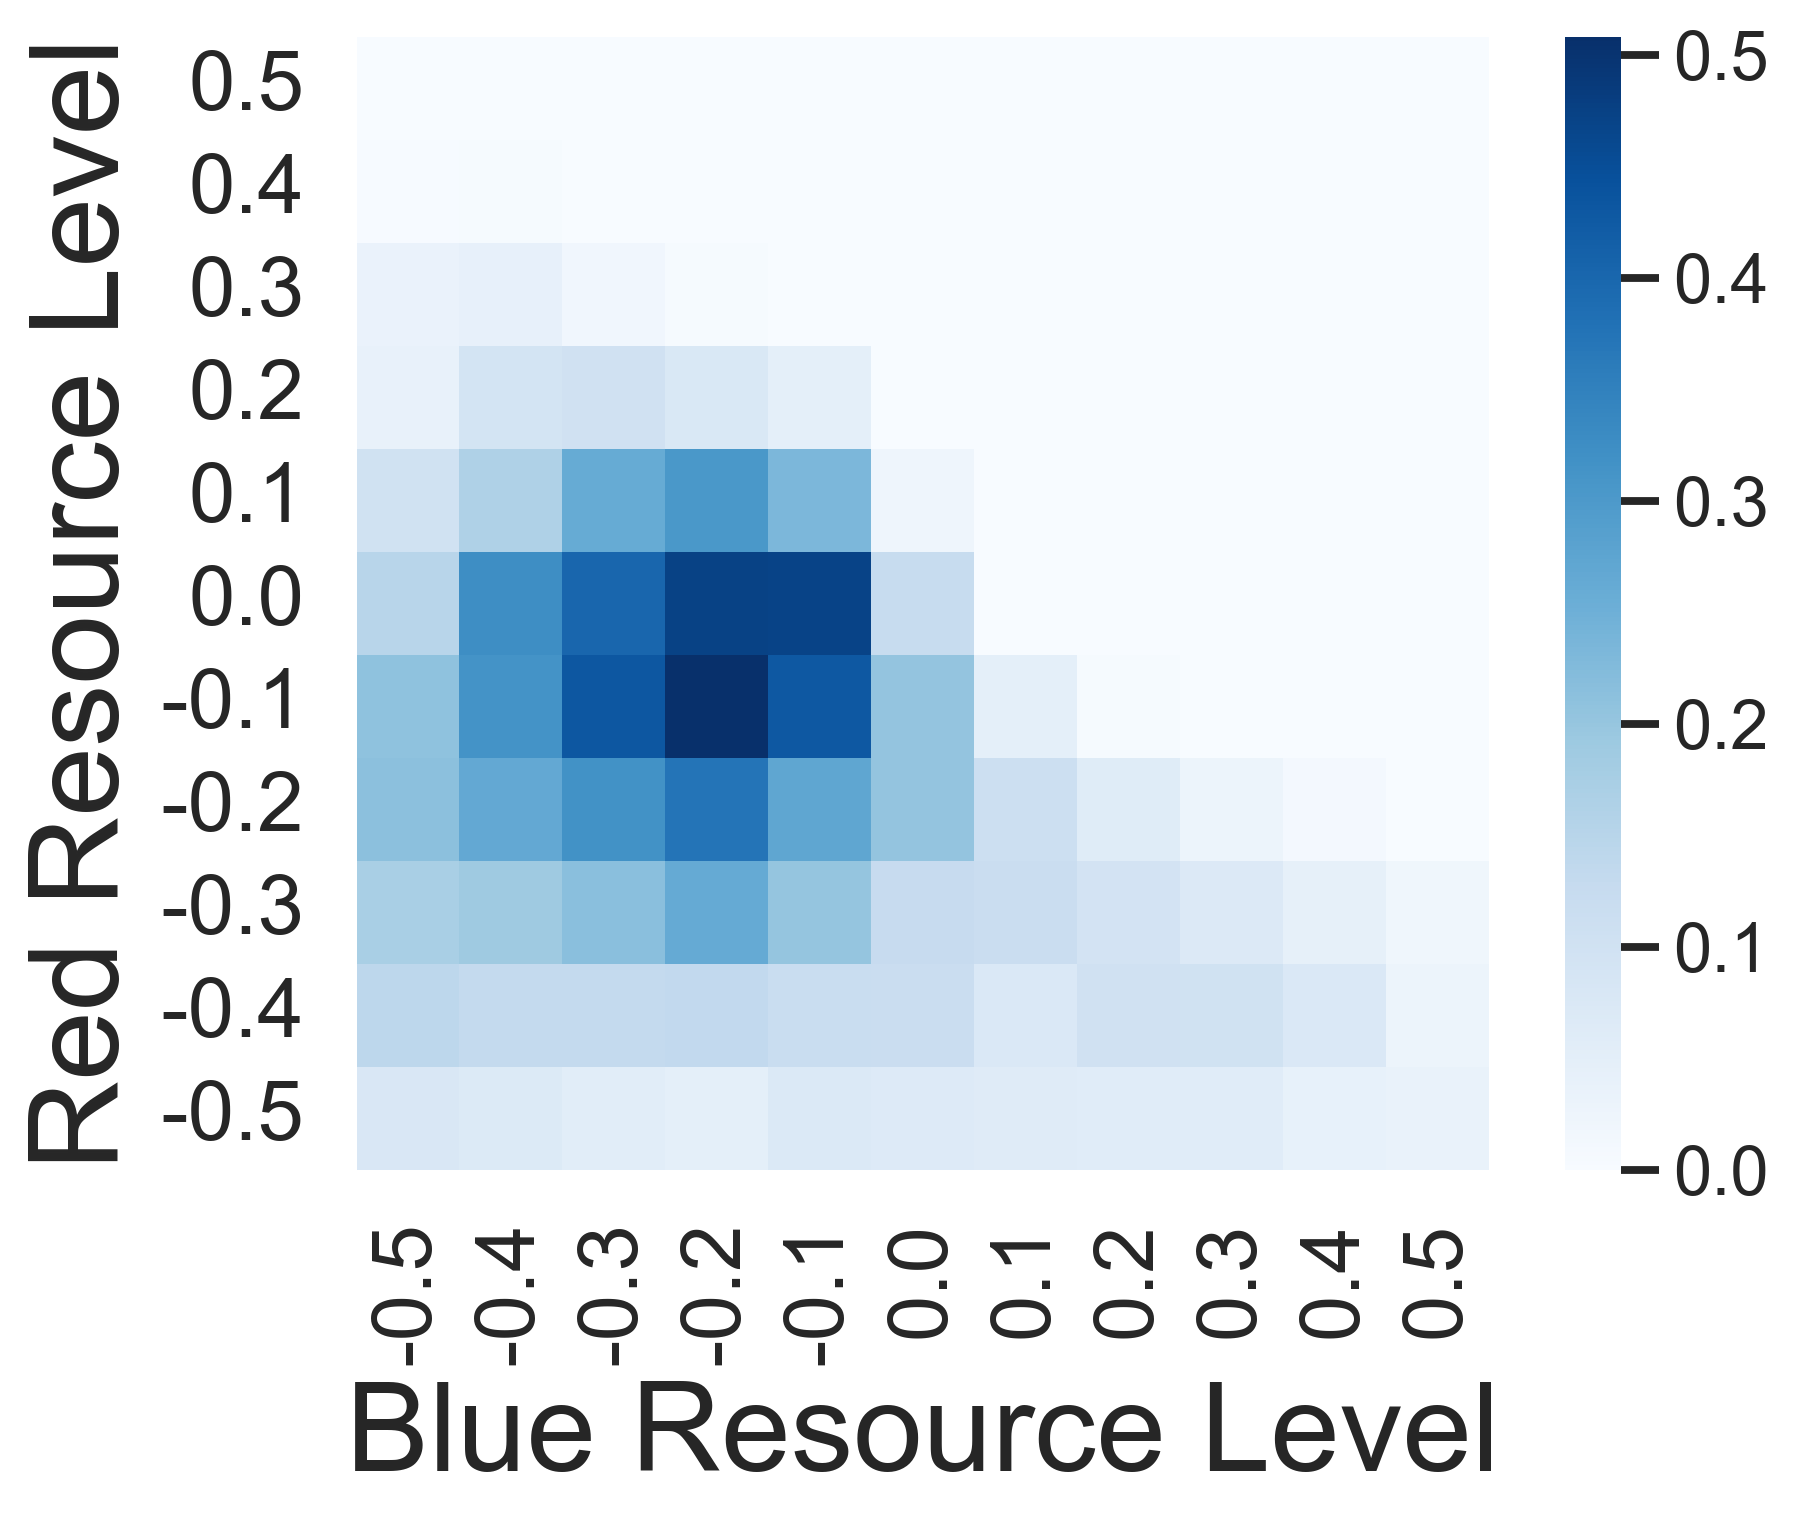

In [8]:
sns.set_context("talk")


plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix_ave_8x2.mean(axis=0) + data_blue_matrix_ave_8x2.mean(axis=0)).transpose(),
                 cmap="binary_r",
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)
ax.invert_yaxis()

plt.savefig("ba_collection_average_8x2.png", bbox_inches='tight')



plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap((data_red_matrix_ave_8x2.mean(axis=0) - data_blue_matrix_ave_8x2.mean(axis=0)).transpose(),
                 cmap='coolwarm',
                 center=0,
                 vmin=-0.8,
                 vmax=0.8,
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("ba_ratio_average_8x2.png", bbox_inches='tight')



plt.figure(figsize=(6.5, 5), dpi=300)
ax = sns.heatmap(data_red_matrix_ave_8x2.mean(axis=0).transpose(),
                 cmap="Reds", #"binary_r",
                 square=True,
                 xticklabels=blue_ticks.round(2),
                 yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("red_matrix_average_8x2.png", bbox_inches='tight')
plt.show()



plt.figure(figsize=(6.5, 5), dpi=300)
ax =sns.heatmap(data_blue_matrix_ave_8x2.mean(axis=0).transpose(),
                cmap="Blues", #"binary_r",
                square=True,
                xticklabels=blue_ticks.round(2),
                yticklabels=red_ticks.round(2))
ax.invert_yaxis()
ax.set_ylabel("Red Resource Level", fontsize=30)
ax.set_xlabel("Blue Resource Level", fontsize=30)
plt.tick_params(labelsize=20)

plt.savefig("blue_matrix_average_8x2.png", bbox_inches='tight')


plt.show()